In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [4]:
train.shape

(27481, 4)

In [5]:
train[train.text.isnull()]

textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral

In [6]:
#remove nan entries
train = train[train.text.isnull()==False].reset_index()

In [7]:
train.shape

(27480, 5)

In [8]:
%matplotlib inline

In [9]:
from matplotlib import pyplot as plt

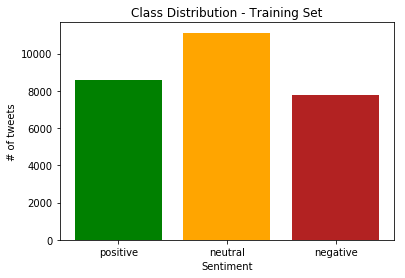

In [10]:
plt.bar(x=[0,1,2], height=[len(train[train.sentiment=='positive']),len(train[train.sentiment=='neutral']),len(train[train.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Training Set')
plt.show()

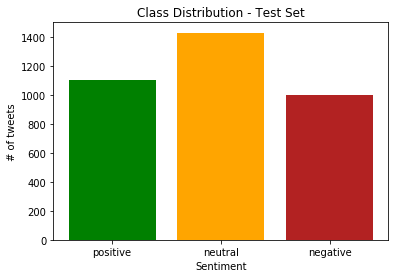

In [11]:
plt.bar(x=[0,1,2], height=[len(test[test.sentiment=='positive']),len(test[test.sentiment=='neutral']),len(test[test.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Test Set')
plt.show()

### Text pre-processing ###

We will create a bag of words - a matrix where there is a row corresonding to each tweet and a column for each word in all the tweets, with 1s and 0s indicating whether a given tween contains a given word or not.   

But first let's consider a common issue with tweets. Twitter users tend to use repeated letters to emphasize words. For example one may write 'I looove this pizza' or 'This movie is sooo goood!'. We would ideally want our classifier to understand that 'looove' is the same as 'love' and 'sooo goood' is the same as 'so good'. Therefore, we need to pre-process the text of each tweet to remove duplicate letters. However, we must be careful because some English words actually have repeating letters - for example 'goood' must be interpreted as 'good' and not 'god'.

Note: some of the next cells are commented to avoid running computationally intensive calculations multiple times. In contrast, the following code has been ran once and the results were stored in a .pkl file so that they can be loaded every time the notebook is used.

In [12]:
# #create count_vector and fit it to the train data
# from sklearn.feature_extraction.text import CountVectorizer
# count_vector = CountVectorizer(lowercase=True, stop_words='english') #  exclude common words in English
# count_vector.fit(train['text'].get_values())

In [13]:
# #transform train to bag of words matrix
# train_matrix = count_vector.transform(train['text']).toarray()
# words_matrix =  pd.DataFrame(train_matrix, columns = count_vector.get_feature_names())

In [14]:
#functions to write and save object (so that we don't have to run computationally intensive algorithms every time the notebook is re-opened)
import pickle
def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [15]:
# #Algorithm to obtain a dictionary of non-existent words with repeated letters to correct English words
# import re
# all_words = words_matrix.columns.values
# word_dict = {}
# for word in all_words:
#     word_a = re.sub(r'(.)\1+', r'\1', word) #word with repeated characters reduced to 1 character
#     word_b = re.sub(r'(.)\1+', r'\1\1', word) #word with repeated characters reduced to 2 characters
    
#     #get count of each of the variations of the word in all sentences
#     count_ = words_matrix.word.sum(axis=0)
#     count_a = words_matrix[word_a].sum(axis=0) if word_a in all_words else 0
#     count_b = words_matrix[word_b].sum(axis=0) if word_b in all_words else 0
    
#     #determine which is the most common variation of the word
#     if count_ < count_a and count_a > count_b:
#         word_dict[word] = word_a
#     elif count_ < count_b and count_b > count_a:
#         word_dict[word] =  word_b
#     else:
#         word_dict[word] = word

# save_obj(word_dict, 'repeated_letters_dict')

In [16]:
word_dict = load_obj('repeated_letters_dict') #load pre-calculated dictionary

In [17]:
word_dict['goood']

'good'

In [18]:
word_dict['looove']

'love'

In [19]:
def remove_repeated_chars(sentence, word_dict):
    import string
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) #remove punctuation from string 
    translated = []
    #translate each word using word_dict - i.e. convert non-existent words with repeating letters to correct words
    for x in list(sentence.split()):
        t = word_dict.get(x.lower(), x)
        translated.append(t)
    newphrase = ' '.join(translated)
    return newphrase

In [20]:
#store copy of training and test sets' text field with no repeating characters
train_text_norm = train.text.apply(lambda x: remove_repeated_chars(x, word_dict))
test_text_norm = test.text.apply(lambda x: remove_repeated_chars(x, word_dict))

In [21]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector.fit(train_text_norm.get_values())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [22]:
#transform train to bag of words matrix
train_matrix_norm = count_vector.transform(train_text_norm)
train_df_norm =  pd.DataFrame(train_matrix_norm.toarray(), columns = count_vector.get_feature_names())

In [23]:
#transform test to bag of words matrix, using count vectorizer fitted to train data
test_matrix_norm = count_vector.transform(test_text_norm)
test_df_norm =  pd.DataFrame(test_matrix_norm.toarray(), columns = count_vector.get_feature_names())

In [24]:
# # erase pre-normalisation bags of words from memory
# train_matrix= None
# words_matrix = None

Do the same for the selected phrases in the training set:

In [25]:
#store copy of training set's selected_text field with no repeating characters
train_selected_norm = train.selected_text.apply(lambda x: remove_repeated_chars(x, word_dict))

In [26]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector_selected = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector_selected.fit(train_selected_norm.get_values())

#transform train to bag of words matrix
selected_matrix_norm = count_vector_selected.transform(train_selected_norm)
selected_df_norm =  pd.DataFrame(selected_matrix_norm.toarray(), columns = count_vector_selected.get_feature_names())

---

### Baseline Model ###

We will first test a simple model which is based on the balance between the count of words that are commonly encountered in positive sentiment tweets and words commonly used in negative sentiment tweets. If a given tweet contains more 'positive' words than 'negative' words it is classified as positive while if it contains more 'negative' words it is classified as negative. If there is the same number of 'positive' and 'negative' words (or the difference between the two counts is not greater than a pre-defined limit) then the tweet is classified as 'neutral'.

Let's first calculate some statistics about the frequency of occurrence of each word. We start by counting the number of samples that contain each word in the entire training dataset and in positive and negative samples seperately:

In [27]:
def get_word_stats(matrix, labels, thres_pct=0.5):
    #thres_pct: minimum percentage of occurence in a particular class for word to be retained
    
    #Count total occurences of each word
    total_freq = matrix.astype(bool).sum(axis=0).sort_values(ascending=False)
    
    #Count occurences of each word in positive and negative sentiment samples
    matrix['sentiment'] = labels    #add label column to word_matrix
    positive_freq = matrix[matrix.sentiment == 'positive'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
    negative_freq = matrix[matrix.sentiment == 'negative'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
    
    #Concatenate frequency counts into a single dataframe
    words_stats = pd.concat([total_freq, positive_freq.reindex(total_freq.index), negative_freq.reindex(total_freq.index)], axis=1)
    words_stats = words_stats.rename(columns={0: 'total_count', 1: 'pos_count', 2: 'neg_count'})
    
    #Calculate percentage of phrases that contain each word that have pos or neg sentiment
    words_stats['pos_pct'] = words_stats['pos_count']/words_stats['total_count']
    words_stats['neg_pct'] = words_stats['neg_count']/words_stats['total_count']
    
    #Remove words that do not have a particular class (pos or neg) mainly associated with them
    words_stats_reduced = words_stats[(words_stats.pos_pct>=thres_pct)|(words_stats.neg_pct>=thres_pct)]
    
    #Store words that appear frequently in positive or negative tweets
    pos_words = words_stats_reduced[words_stats_reduced.pos_pct>words_stats_reduced.neg_pct].index.values
    neg_words = words_stats_reduced[words_stats_reduced.pos_pct<words_stats_reduced.neg_pct].index.values
    
    return words_stats_reduced, pos_words, neg_words

In [28]:
word_stats, pos_words, neg_words = get_word_stats(train_df_norm, train.sentiment, thres_pct=0.5)
save_obj(word_stats, 'word_stats')
save_obj(pos_words, 'pos_words')
save_obj(neg_words, 'neg_words')

In [28]:
#load pre-calculated stats and pos & neg words
word_stats = load_obj('word_stats')
pos_words = load_obj('pos_words')
neg_words = load_obj('neg_words')

Let's see some of the most common words appearing in positive and negative sentiment tweets:

In [29]:
word_stats[word_stats.pos_pct>word_stats.neg_pct].sort_values('pos_count',ascending=False).head(10)

total_count  pos_count  neg_count   pos_pct   neg_pct
day             1924       1141        308  0.593035  0.160083
good            1507       1018        198  0.675514  0.131387
love            1106        861         47  0.778481  0.042495
happy            953        817         43  0.857293  0.045121
mothers          636        555         13  0.872642  0.020440
thanks           655        550         19  0.839695  0.029008
great            599        467         33  0.779633  0.055092
hope             580        389         52  0.670690  0.089655
fun              515        337         68  0.654369  0.132039
nice             424        329         29  0.775943  0.068396

In [30]:
word_stats[word_stats.neg_pct>word_stats.pos_pct].sort_values('neg_count',ascending=False).head(10)

total_count  pos_count  neg_count   pos_pct   neg_pct
miss           600         50        414  0.083333  0.690000
sad            469          6        384  0.012793  0.818763
sorry          470         21        336  0.044681  0.714894
bad            464         46        291  0.099138  0.627155
feel           515        109        283  0.211650  0.549515
hate           316          7        255  0.022152  0.806962
sick           252         11        196  0.043651  0.777778
sucks          207          2        177  0.009662  0.855072
tired          257         20        172  0.077821  0.669261
ugh            217         15        165  0.069124  0.760369

An additional useful statistic: the number of words in each text:

In [142]:
train_text_len = train.text.apply(lambda x: len(x.split()))
test_text_len = test.text.apply(lambda x: len(x.split()))

We now create a function for the baseline model:

In [69]:
def intersection(list1, list2): 
    return list(set(list1) & set(list2)) 

def baseline_classifier(matrix, text_len, pos_words, neg_words, limit=0, show_metrics=False, plot_confusion=False, correct_labels=None):
    #Remove words that appear in pos_words or neg_word but not in the texts to be classified
    pos_words = intersection(pos_words, matrix.columns.values)
    neg_words = intersection(neg_words, matrix.columns.values)
    #Calculate balance of 'positive' and 'negative' words in each text
    words_balance = pd.DataFrame(matrix[pos_words].sum(axis=1)-matrix[neg_words].sum(axis=1)).rename(columns={0:'balance'})
    #Calculate balance of 'positive' and 'negative' words as a percentage of the total number of words in the text
    words_balance['len'] = text_len #add total lenght of the text to words_balance
    words_balance['balance_pct'] = words_balance['balance']/words_balance['len'] #calculate percentage
    
    #Classify text based on balance. If abs(balance_pct)<limit then 'neutral'
    pred = words_balance.balance_pct.apply(lambda x: 'positive' if x>limit else ('negative' if x<-limit else 'neutral')).values
    #Calculate probability that text is in predicted class
    prob = words_balance.balance_pct.apply(lambda x: abs(x) if abs(x)>limit else 1-abs(x))
    
    if show_metrics and correct_labels is not None:
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        print('Results')
        print('Accuracy score: ', format(accuracy_score(correct_labels, pred)))
        print('Precision score: ', format(precision_score(correct_labels, pred,average=None)))
        print('Recall score: ', format(recall_score(correct_labels, pred,average=None)))
        print('F1 score: ', format(f1_score(correct_labels, pred,average=None)))
    
    if plot_confusion and correct_labels is not None:
        from sklearn.metrics import confusion_matrix
        import seaborn as sns

        #Calculate confusion matrix
        cm = confusion_matrix(correct_labels, pred, ['positive','neutral','negative'])
        
        #Plot confusion matrix heatmap
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix') 
        ax.xaxis.set_ticklabels(['positive','neutral','negative'])
        ax.yaxis.set_ticklabels(['positive','neutral','negative'])
        plt.show()
        
    
    return pred, prob

**Baseline Model using full text**

Run on training set with limit=0 (i.e. if n_pos>n_neg then 'positive'):

Results
Accuracy score:  0.7433406113537118
Precision score:  [0.75558167 0.79406769 0.69983211]
Recall score:  [0.82637193 0.54664028 0.9228618 ]
F1 score:  [0.78939292 0.64752264 0.7960199 ]


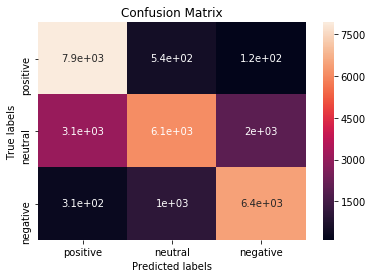

In [60]:
train_pred, prob = baseline_classifier(train_df_norm,train_text_len,pos_words,neg_words,limit=0,show_metrics=True,plot_confusion=True,correct_labels=train.sentiment.values)

Run on training set with limit=0.1 (i.e. if (n_pos-n_neg)/len > 0.1 then 'positive'):

Results
Accuracy score:  0.7599344978165938
Precision score:  [0.869272   0.67603839 0.81816007]
Recall score:  [0.64606092 0.81110012 0.79690049]
F1 score:  [0.74122678 0.73743611 0.80739035]


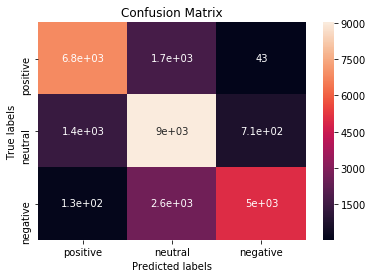

In [66]:
train_pred, prob = baseline_classifier(train_df_norm,train_text_len,pos_words,neg_words,limit=0.1,show_metrics=True,plot_confusion=True,correct_labels=train.sentiment.values)

While recall improves for 'neutral' when lim>0, it drops for 'positive' and 'negative' tweets.

Run on test set with limit=0:

Results
Accuracy score:  0.6120543293718166
Precision score:  [0.62085308 0.61137441 0.60603933]
Recall score:  [0.65434565 0.45104895 0.7824116 ]
F1 score:  [0.63715953 0.51911469 0.68302335]


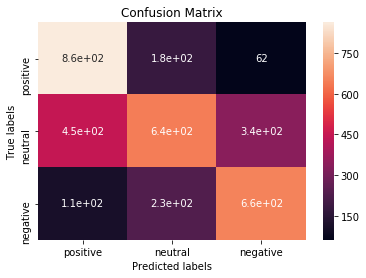

In [67]:
test_pred, prob = baseline_classifier(test_df_norm,test_text_len,pos_words,neg_words,limit=0,show_metrics=True,plot_confusion=True,correct_labels=test.sentiment.values)

**Baseline Model using selected_text**

We will now try training the baseline classifier with the selected_text from the training set instead of the full text of each document. This will help to only identify words that are truely associated with a given sentiment.

In [43]:
word_stats_selected, pos_words_selected, neg_words_selected = get_word_stats(selected_df_norm, train.sentiment, thres_pct=0.5)
save_obj(word_stats_selected, 'word_stats_selected')
save_obj(pos_words_selected, 'pos_words_selected')
save_obj(neg_words_selected, 'neg_words_selected')

In [34]:
#load pre-calculated stats and pos & neg words
word_stats_selected = load_obj('word_stats_selected')
pos_words_selected = load_obj('pos_words_selected')
neg_words_selected = load_obj('neg_words_selected')

Results
Accuracy score:  0.6997736276174307
Precision score:  [0.70238095 0.65743243 0.75309735]
Recall score:  [0.64835165 0.68041958 0.77153218]
F1 score:  [0.67428571 0.66872852 0.76220331]


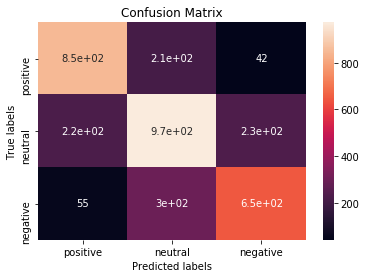

In [70]:
test_pred,prob = baseline_classifier(test_df_norm,test_text_len,pos_words_selected,neg_words_selected,limit=0,show_metrics=True,plot_confusion=True,correct_labels=test.sentiment.values)

The performance is indeed improved when we only focus on the words in the selected_text field.

---

### Training and evaluation of different Machine Learning models ###

**Model pipeline**

Create pipeline to test the performance of different machine learning models:

In [29]:
#encode training labels to an integer format that is interpretable by all sklearn classification models
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(train.sentiment.values.astype(str))

In [30]:
def run_model(model, model_name, train_data, train_labels, test_data, test_labels, label_encoder, tf_idf=False):
    
    if tf_idf:
        from sklearn.feature_extraction.text import TfidfTransformer
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(train_data)
        train_data = tfidf_transformer.transform(train_data)
        test_data = tfidf_transformer.transform(test_data)
    
    train_labels_encoded = label_encoder.transform(train_labels.astype(str))
    
    #Fit model to training data
    model.fit(train_matrix_norm, train_labels_encoded)
    
    #Test model's performance on training data
    train_pred = model.predict(train_data)
    train_pred = le.inverse_transform(train_pred)
    
    #Test model's performance on test data
    test_pred = model.predict(test_data) 
    test_pred = le.inverse_transform(test_pred)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    #Prin performance metrics
    print(model_name)
    print()
    print('Results on training set:')
    print('Accuracy score: ', format(accuracy_score(train_labels, train_pred)))
    print('Precision score: ', format(precision_score(train_labels, train_pred,average=None)))
    print('Recall score: ', format(recall_score(train_labels, train_pred,average=None)))
    print('F1 score: ', format(f1_score(train_labels, train_pred,average=None)))
    print('---------------------------------------------------------------------')
    print('Results on test set:')
    print('Accuracy score: ', format(accuracy_score(test_labels, test_pred)))
    print('Precision score: ', format(precision_score(test_labels, test_pred,average=None)))
    print('Recall score: ', format(recall_score(test_labels, test_pred,average=None)))
    print('F1 score: ', format(f1_score(test_labels, test_pred,average=None)))
    print('---------------------------------------------------------------------')
    
    #Plot confusion matrix for test set
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(test.sentiment.values, test_pred, ['positive','neutral','negative'])

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - Test Set') 
    ax.xaxis.set_ticklabels(le.inverse_transform([0,1,2]))
    ax.yaxis.set_ticklabels(le.inverse_transform([0,1,2]))
    plt.show()
    
    return train_pred, test_pred, model, accuracy_score(test_labels,test_pred)

In [215]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

models = dict()

models['Multinomial Naive Bayes'] = MultinomialNB()
models['Bernoulli Naive Bayes'] = BernoulliNB()
models['Gaussian Naive Bayes'] = GaussianNB()
models['Logistic Regression'] = LogisticRegression(random_state=42, multi_class='auto')
models['KNN'] = KNeighborsClassifier(n_neighbors=5)
models['Decision Tree'] = DecisionTreeClassifier(random_state=42)
models['Bagging'] = BaggingClassifier(n_estimators=50 ,random_state=42)


**Naive Bayes**

Multinomial Naive Bayes

Results on training set:
Accuracy score:  0.8448689956331877
Precision score:  [0.87955025 0.81405415 0.85842461]
Recall score:  [0.8042668  0.8628227  0.85842461]
F1 score:  [0.84022556 0.83772926 0.85842461]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6550650820599887
Precision score:  [0.68287037 0.59900683 0.71765817]
Recall score:  [0.58941059 0.67482517 0.68902992]
F1 score:  [0.63270777 0.63465965 0.70305273]
---------------------------------------------------------------------


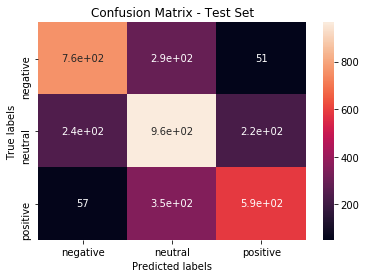

In [222]:
train_pred, test_pred, m_nb_model, m_nb_test_accuracy = run_model(models['Multinomial Naive Bayes'],'Multinomial Naive Bayes',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values,le,tf_idf=False)
save_obj(m_nb_model, 'm_nb_model')

In [224]:
train_pred, test_pred, b_nb_model, b_nb_test_accuracy = run_model(models['Bernoulli Naive Bayes'],'Bernoulli Naive Bayes',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values,le,tf_idf=False)
save_obj(b_nb_model, 'b_nb_model')

Bernoulli Naive Bayes

Results on training set:
Accuracy score:  0.8109170305676856
Precision score:  [0.91520417 0.71987153 0.90598406]
Recall score:  [0.67690528 0.92740847 0.78151946]
F1 score:  [0.77822104 0.81056645 0.83916171]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6346915676287493
Precision score:  [0.74300699 0.54709977 0.79182156]
Recall score:  [0.42457542 0.82447552 0.5793291 ]
F1 score:  [0.54036872 0.65774059 0.66910995]
---------------------------------------------------------------------


**Logistic Regression**

In [226]:
train_pred, test_pred, log_model, log_test_accuracy = run_model(models['Logistic Regression'],'Logistic Regression',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values,le,tf_idf=False)
save_obj(log_model, 'log_model')

Logistic Regression

Results on training set:
Accuracy score:  0.867467248908297
Precision score:  [0.89618172 0.83700366 0.8852862 ]
Recall score:  [0.82650045 0.88549069 0.88126311]
F1 score:  [0.8599318  0.86056473 0.88327007]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6955291454442558
Precision score:  [0.70866142 0.63368162 0.78290766]
Recall score:  [0.62937063 0.72097902 0.7225748 ]
F1 score:  [0.66666667 0.6745175  0.7515323 ]
---------------------------------------------------------------------


**K-Nearest Neighbors**

In [77]:
train_pred, test_pred, knn_model, knn_test_accuracy = run_model(models['KNN'],'KNN',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values,le,tf_idf=False)
save_obj(knn_model, 'knn_model')

KNN

Results on training set:
Accuracy score:  0.6556040756914119
Precision score:  [0.77242789 0.56445202 0.85513078]
Recall score:  [0.43709035 0.89412611 0.54474481]
F1 score:  [0.55827315 0.69203189 0.6655278 ]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.5735710243350312
Precision score:  [0.64236902 0.49897246 0.8021148 ]
Recall score:  [0.28171828 0.84895105 0.48141432]
F1 score:  [0.39166667 0.62852705 0.60169972]
---------------------------------------------------------------------


**Decision Tree & Bagging**

Decision Tree

Results on training set:
Accuracy score:  0.995924308588064
Precision score:  [0.9960144  0.99408019 0.99824623]
Recall score:  [0.99563038 0.99694162 0.99487299]
F1 score:  [0.99582235 0.99550885 0.99655676]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6644029428409735
Precision score:  [0.63529412 0.63942308 0.7268431 ]
Recall score:  [0.64735265 0.65104895 0.69718948]
F1 score:  [0.6412667  0.64518365 0.71170754]
---------------------------------------------------------------------


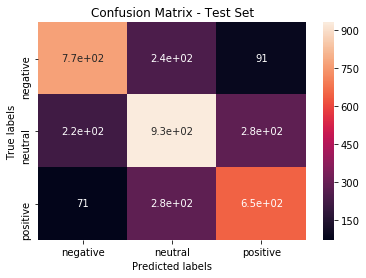

In [76]:
train_pred, test_pred, tree_model, tree_test_accuracy = run_model(models['Decision Tree'],'Decision Tree',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values,le,tf_idf=False)
save_obj(tree_model, 'tree_model')

Bagging

Results on training set:
Accuracy score:  0.9941048034934498
Precision score:  [0.99574523 0.99184295 0.99556489]
Recall score:  [0.99254595 0.99532248 0.99394081]
F1 score:  [0.99414301 0.99357967 0.99475219]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6884550084889643
Precision score:  [0.68824164 0.64721311 0.74676525]
Recall score:  [0.63736264 0.69020979 0.7325476 ]
F1 score:  [0.66182573 0.6680203  0.7395881 ]
---------------------------------------------------------------------


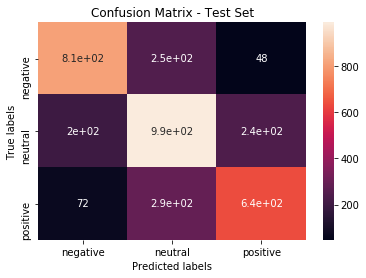

In [74]:
train_pred, test_pred, bagging_model, bagging_test_accuracy = run_model(models['Bagging'],'Bagging',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values,le,tf_idf=False)
save_obj(bagging_model, 'bagging_model')

---

### Ensemble Model ###

We will now combine the results of a selection of the models trained above to obtain a stronger classifier.

In [31]:
#Load pre-trained models
log_model = load_obj('log_model')
m_nb_model = load_obj('m_nb_model')
tree_model = load_obj('tree_model')
bagging_model = load_obj('bagging_model')

In [71]:
#Load baseline model parameters
pos_words_selected = load_obj('pos_words_selected')
neg_words_selected = load_obj('neg_words_selected')
test_text_len = test.text.apply(lambda x: len(x.split()))

#Baseline model results and parameters passed to ensemble model
baseline_model = {'text_len':test_text_len, 'pos_words':pos_words_selected, 
                  'neg_words':neg_words_selected, 'limit':0,'weight':0.75} 

In [46]:
def calc_train_accuracies(models, train_data, train_labels, label_encoder,):
    from sklearn.metrics import accuracy_score
    accuracies = []
    for model in models:
        accuracies.append(accuracy_score(train_labels, le.inverse_transform(model.predict(train_data))))
    return accuracies    

In [77]:
def ensemble_model(data, models, model_accuracies, label_encoder, baseline=None):
    #Combine results of multiple models based on their accuracy scores
    #data: bag of words dataframe, label_encoder: pretrained on training dataset (used to train ML models) 
    
    #Convert bag of words dataframe to sparse matrix 
    from scipy.sparse import csr_matrix
    data_sparse = csr_matrix(data.values)
    
    #Initialize array to hold ensembe probabilities
    ensemble_probs = np.zeros((data_sparse.shape[0],len(le.classes_)))
    
    #Compute ensemble classification probabilities: weighted sum of probabilities of each model (weighted by model's accuracy) 
    i = 0
    for model in models:         
        prob = model.predict_proba(data_sparse)
        accuracy = model_accuracies[i]
        ensemble_probs += (np.log(accuracy)/np.log(1-accuracy))*prob
        i += 1
        
    if baseline is not None:        
        #Run baseline model
        baseline_pred,baseline_prob = baseline_classifier(data, baseline['text_len'],baseline['pos_words'],
                                                          baseline['neg_words'],baseline['limit'],
                                                          show_metrics=False,plot_confusion=False,correct_labels=None)    
        
        #Convert prediction probability for each text from a single float to an array of 2 zeros and 1 float 
        #(at the correct position for computing ensemble with other models)
        baseline_pred = label_encoder.transform(baseline_pred)
        baseline_probs = np.zeros((len(baseline_prob),3))
        for i in range(len(baseline_prob)):
            j = baseline_pred[i]
            baseline_probs[i,j] = baseline_prob[i]
        
        #Add baseline model probabilities to ensemble probabilities
        ensemble_probs += baseline['weight']*baseline_probs
    
    #Normalize probs
    ensemble_probs = ensemble_probs/np.sum(ensemble_probs,axis=1)[:,None]
    
    pred = label_encoder.classes_[np.argmax(ensemble_probs,axis=1)]
    prob = np.max(ensemble_probs,axis=1)
    
    return pred, prob, ensemble_probs

In [73]:
#Select models
selected_models = [log_model,m_nb_model,bagging_model]

#Calculate model accuracies on training set (to obtain weights for ensemble model)
model_accuracies = calc_train_accuracies(selected_models, train_matrix_norm,train.sentiment.values, le)

In [78]:
pred, prob, probs_all = ensemble_model(test_df_norm, selected_models, model_accuracies, le, baseline=baseline_model)

Results on test set:
Accuracy score: 0.70996
Precision score:  [0.7459926  0.63673469 0.80555556]
Recall score:  [0.6043956  0.76363636 0.73617407]
F1 score:  [0.66777042 0.69443561 0.76930365]
---------------------------------------------------------------------


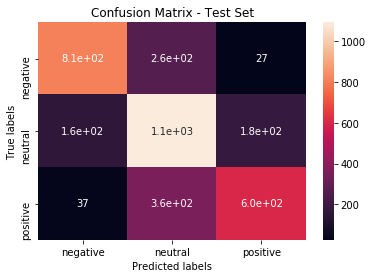

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Results on test set:')
print('Accuracy score: {:.5f}'.format(accuracy_score(test.sentiment.values, pred)))
print('Precision score: ', format(precision_score(test.sentiment.values, pred, average=None)))
print('Recall score: ', format(recall_score(test.sentiment.values, pred, average=None)))
print('F1 score: ', format(f1_score(test.sentiment.values, pred, average=None)))
print('---------------------------------------------------------------------')

#Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test.sentiment.values, pred, ['positive','neutral','negative'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Set') 
ax.xaxis.set_ticklabels(le.inverse_transform([0,1,2]))
ax.yaxis.set_ticklabels(le.inverse_transform([0,1,2]))
plt.show()

---

### Deep Learning ###

In [130]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [230]:
max_words = 10000

In [231]:
tokenizer = Tokenizer(num_words=max_words,lower=True)

In [232]:
#fit tokenizer to training texts
tokenizer.fit_on_texts(train_text_norm.values)

In [233]:
word_index = tokenizer.word_index

In [234]:
#convert training texts to sequences of tokens
x_train = tokenizer.texts_to_sequences(train_text_norm.values)

In [235]:
len(word_index)

28551

In [236]:
x_train[0]

[295, 16, 69, 1, 119, 46]

Make the length of all sequences the same (by padding the start of each sequence) 

In [237]:
max_length = train_text_norm.apply(lambda x: len(x.split())).max()
print('Max tweet length: {} words'.format(max_length))

Max tweet length: 33 words


In [238]:
x_train = pad_sequences(x_train,max_length)

In [239]:
x_train.shape

(27480, 33)

In [240]:
#one-hot encode labels
y_train = pd.get_dummies(train.sentiment.values)

Load pre-trained embedding:

In [299]:
f = open('glove.twitter.27B.50d.txt',"r", encoding="utf-8")
count = 0
for line in f:
    count+=1
f.close()
print('Number of words in embedding:', count)

Number of words in embedding: 1193514


In [301]:
i=0
embeddings_index = dict()
f = open('glove.twitter.27B.50d.txt',"r", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    if word in list(word_index.keys()): 
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    print('{}/{}'.format(i,count))
    i+=1
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

0/1193514
1/1193514
2/1193514
3/1193514
4/1193514
5/1193514
6/1193514
7/1193514
8/1193514
9/1193514
10/1193514
11/1193514
12/1193514
13/1193514
14/1193514
15/1193514
16/1193514
17/1193514
18/1193514
19/1193514
20/1193514
21/1193514
22/1193514
23/1193514
24/1193514
25/1193514
26/1193514
27/1193514
28/1193514
29/1193514
30/1193514
31/1193514
32/1193514
33/1193514
34/1193514
35/1193514
36/1193514
37/1193514
38/1193514
39/1193514
40/1193514
41/1193514
42/1193514
43/1193514
44/1193514
45/1193514
46/1193514
47/1193514
48/1193514
49/1193514
50/1193514
51/1193514
52/1193514
53/1193514
54/1193514
55/1193514
56/1193514
57/1193514
58/1193514
59/1193514
60/1193514
61/1193514
62/1193514
63/1193514
64/1193514
65/1193514
66/1193514
67/1193514
68/1193514
69/1193514
70/1193514
71/1193514
72/1193514
73/1193514
74/1193514
75/1193514
76/1193514
77/1193514
78/1193514
79/1193514
80/1193514
81/1193514
82/1193514
83/1193514
84/1193514
85/1193514
86/1193514
87/1193514
88/1193514
89/1193514
90/1193514
91/119351

711/1193514
712/1193514
713/1193514
714/1193514
715/1193514
716/1193514
717/1193514
718/1193514
719/1193514
720/1193514
721/1193514
722/1193514
723/1193514
724/1193514
725/1193514
726/1193514
727/1193514
728/1193514
729/1193514
730/1193514
731/1193514
732/1193514
733/1193514
734/1193514
735/1193514
736/1193514
737/1193514
738/1193514
739/1193514
740/1193514
741/1193514
742/1193514
743/1193514
744/1193514
745/1193514
746/1193514
747/1193514
748/1193514
749/1193514
750/1193514
751/1193514
752/1193514
753/1193514
754/1193514
755/1193514
756/1193514
757/1193514
758/1193514
759/1193514
760/1193514
761/1193514
762/1193514
763/1193514
764/1193514
765/1193514
766/1193514
767/1193514
768/1193514
769/1193514
770/1193514
771/1193514
772/1193514
773/1193514
774/1193514
775/1193514
776/1193514
777/1193514
778/1193514
779/1193514
780/1193514
781/1193514
782/1193514
783/1193514
784/1193514
785/1193514
786/1193514
787/1193514
788/1193514
789/1193514
790/1193514
791/1193514
792/1193514
793/1193514
794/

1391/1193514
1392/1193514
1393/1193514
1394/1193514
1395/1193514
1396/1193514
1397/1193514
1398/1193514
1399/1193514
1400/1193514
1401/1193514
1402/1193514
1403/1193514
1404/1193514
1405/1193514
1406/1193514
1407/1193514
1408/1193514
1409/1193514
1410/1193514
1411/1193514
1412/1193514
1413/1193514
1414/1193514
1415/1193514
1416/1193514
1417/1193514
1418/1193514
1419/1193514
1420/1193514
1421/1193514
1422/1193514
1423/1193514
1424/1193514
1425/1193514
1426/1193514
1427/1193514
1428/1193514
1429/1193514
1430/1193514
1431/1193514
1432/1193514
1433/1193514
1434/1193514
1435/1193514
1436/1193514
1437/1193514
1438/1193514
1439/1193514
1440/1193514
1441/1193514
1442/1193514
1443/1193514
1444/1193514
1445/1193514
1446/1193514
1447/1193514
1448/1193514
1449/1193514
1450/1193514
1451/1193514
1452/1193514
1453/1193514
1454/1193514
1455/1193514
1456/1193514
1457/1193514
1458/1193514
1459/1193514
1460/1193514
1461/1193514
1462/1193514
1463/1193514
1464/1193514
1465/1193514
1466/1193514
1467/1193514

2063/1193514
2064/1193514
2065/1193514
2066/1193514
2067/1193514
2068/1193514
2069/1193514
2070/1193514
2071/1193514
2072/1193514
2073/1193514
2074/1193514
2075/1193514
2076/1193514
2077/1193514
2078/1193514
2079/1193514
2080/1193514
2081/1193514
2082/1193514
2083/1193514
2084/1193514
2085/1193514
2086/1193514
2087/1193514
2088/1193514
2089/1193514
2090/1193514
2091/1193514
2092/1193514
2093/1193514
2094/1193514
2095/1193514
2096/1193514
2097/1193514
2098/1193514
2099/1193514
2100/1193514
2101/1193514
2102/1193514
2103/1193514
2104/1193514
2105/1193514
2106/1193514
2107/1193514
2108/1193514
2109/1193514
2110/1193514
2111/1193514
2112/1193514
2113/1193514
2114/1193514
2115/1193514
2116/1193514
2117/1193514
2118/1193514
2119/1193514
2120/1193514
2121/1193514
2122/1193514
2123/1193514
2124/1193514
2125/1193514
2126/1193514
2127/1193514
2128/1193514
2129/1193514
2130/1193514
2131/1193514
2132/1193514
2133/1193514
2134/1193514
2135/1193514
2136/1193514
2137/1193514
2138/1193514
2139/1193514

2746/1193514
2747/1193514
2748/1193514
2749/1193514
2750/1193514
2751/1193514
2752/1193514
2753/1193514
2754/1193514
2755/1193514
2756/1193514
2757/1193514
2758/1193514
2759/1193514
2760/1193514
2761/1193514
2762/1193514
2763/1193514
2764/1193514
2765/1193514
2766/1193514
2767/1193514
2768/1193514
2769/1193514
2770/1193514
2771/1193514
2772/1193514
2773/1193514
2774/1193514
2775/1193514
2776/1193514
2777/1193514
2778/1193514
2779/1193514
2780/1193514
2781/1193514
2782/1193514
2783/1193514
2784/1193514
2785/1193514
2786/1193514
2787/1193514
2788/1193514
2789/1193514
2790/1193514
2791/1193514
2792/1193514
2793/1193514
2794/1193514
2795/1193514
2796/1193514
2797/1193514
2798/1193514
2799/1193514
2800/1193514
2801/1193514
2802/1193514
2803/1193514
2804/1193514
2805/1193514
2806/1193514
2807/1193514
2808/1193514
2809/1193514
2810/1193514
2811/1193514
2812/1193514
2813/1193514
2814/1193514
2815/1193514
2816/1193514
2817/1193514
2818/1193514
2819/1193514
2820/1193514
2821/1193514
2822/1193514

3531/1193514
3532/1193514
3533/1193514
3534/1193514
3535/1193514
3536/1193514
3537/1193514
3538/1193514
3539/1193514
3540/1193514
3541/1193514
3542/1193514
3543/1193514
3544/1193514
3545/1193514
3546/1193514
3547/1193514
3548/1193514
3549/1193514
3550/1193514
3551/1193514
3552/1193514
3553/1193514
3554/1193514
3555/1193514
3556/1193514
3557/1193514
3558/1193514
3559/1193514
3560/1193514
3561/1193514
3562/1193514
3563/1193514
3564/1193514
3565/1193514
3566/1193514
3567/1193514
3568/1193514
3569/1193514
3570/1193514
3571/1193514
3572/1193514
3573/1193514
3574/1193514
3575/1193514
3576/1193514
3577/1193514
3578/1193514
3579/1193514
3580/1193514
3581/1193514
3582/1193514
3583/1193514
3584/1193514
3585/1193514
3586/1193514
3587/1193514
3588/1193514
3589/1193514
3590/1193514
3591/1193514
3592/1193514
3593/1193514
3594/1193514
3595/1193514
3596/1193514
3597/1193514
3598/1193514
3599/1193514
3600/1193514
3601/1193514
3602/1193514
3603/1193514
3604/1193514
3605/1193514
3606/1193514
3607/1193514

4179/1193514
4180/1193514
4181/1193514
4182/1193514
4183/1193514
4184/1193514
4185/1193514
4186/1193514
4187/1193514
4188/1193514
4189/1193514
4190/1193514
4191/1193514
4192/1193514
4193/1193514
4194/1193514
4195/1193514
4196/1193514
4197/1193514
4198/1193514
4199/1193514
4200/1193514
4201/1193514
4202/1193514
4203/1193514
4204/1193514
4205/1193514
4206/1193514
4207/1193514
4208/1193514
4209/1193514
4210/1193514
4211/1193514
4212/1193514
4213/1193514
4214/1193514
4215/1193514
4216/1193514
4217/1193514
4218/1193514
4219/1193514
4220/1193514
4221/1193514
4222/1193514
4223/1193514
4224/1193514
4225/1193514
4226/1193514
4227/1193514
4228/1193514
4229/1193514
4230/1193514
4231/1193514
4232/1193514
4233/1193514
4234/1193514
4235/1193514
4236/1193514
4237/1193514
4238/1193514
4239/1193514
4240/1193514
4241/1193514
4242/1193514
4243/1193514
4244/1193514
4245/1193514
4246/1193514
4247/1193514
4248/1193514
4249/1193514
4250/1193514
4251/1193514
4252/1193514
4253/1193514
4254/1193514
4255/1193514

4823/1193514
4824/1193514
4825/1193514
4826/1193514
4827/1193514
4828/1193514
4829/1193514
4830/1193514
4831/1193514
4832/1193514
4833/1193514
4834/1193514
4835/1193514
4836/1193514
4837/1193514
4838/1193514
4839/1193514
4840/1193514
4841/1193514
4842/1193514
4843/1193514
4844/1193514
4845/1193514
4846/1193514
4847/1193514
4848/1193514
4849/1193514
4850/1193514
4851/1193514
4852/1193514
4853/1193514
4854/1193514
4855/1193514
4856/1193514
4857/1193514
4858/1193514
4859/1193514
4860/1193514
4861/1193514
4862/1193514
4863/1193514
4864/1193514
4865/1193514
4866/1193514
4867/1193514
4868/1193514
4869/1193514
4870/1193514
4871/1193514
4872/1193514
4873/1193514
4874/1193514
4875/1193514
4876/1193514
4877/1193514
4878/1193514
4879/1193514
4880/1193514
4881/1193514
4882/1193514
4883/1193514
4884/1193514
4885/1193514
4886/1193514
4887/1193514
4888/1193514
4889/1193514
4890/1193514
4891/1193514
4892/1193514
4893/1193514
4894/1193514
4895/1193514
4896/1193514
4897/1193514
4898/1193514
4899/1193514

5603/1193514
5604/1193514
5605/1193514
5606/1193514
5607/1193514
5608/1193514
5609/1193514
5610/1193514
5611/1193514
5612/1193514
5613/1193514
5614/1193514
5615/1193514
5616/1193514
5617/1193514
5618/1193514
5619/1193514
5620/1193514
5621/1193514
5622/1193514
5623/1193514
5624/1193514
5625/1193514
5626/1193514
5627/1193514
5628/1193514
5629/1193514
5630/1193514
5631/1193514
5632/1193514
5633/1193514
5634/1193514
5635/1193514
5636/1193514
5637/1193514
5638/1193514
5639/1193514
5640/1193514
5641/1193514
5642/1193514
5643/1193514
5644/1193514
5645/1193514
5646/1193514
5647/1193514
5648/1193514
5649/1193514
5650/1193514
5651/1193514
5652/1193514
5653/1193514
5654/1193514
5655/1193514
5656/1193514
5657/1193514
5658/1193514
5659/1193514
5660/1193514
5661/1193514
5662/1193514
5663/1193514
5664/1193514
5665/1193514
5666/1193514
5667/1193514
5668/1193514
5669/1193514
5670/1193514
5671/1193514
5672/1193514
5673/1193514
5674/1193514
5675/1193514
5676/1193514
5677/1193514
5678/1193514
5679/1193514

6346/1193514
6347/1193514
6348/1193514
6349/1193514
6350/1193514
6351/1193514
6352/1193514
6353/1193514
6354/1193514
6355/1193514
6356/1193514
6357/1193514
6358/1193514
6359/1193514
6360/1193514
6361/1193514
6362/1193514
6363/1193514
6364/1193514
6365/1193514
6366/1193514
6367/1193514
6368/1193514
6369/1193514
6370/1193514
6371/1193514
6372/1193514
6373/1193514
6374/1193514
6375/1193514
6376/1193514
6377/1193514
6378/1193514
6379/1193514
6380/1193514
6381/1193514
6382/1193514
6383/1193514
6384/1193514
6385/1193514
6386/1193514
6387/1193514
6388/1193514
6389/1193514
6390/1193514
6391/1193514
6392/1193514
6393/1193514
6394/1193514
6395/1193514
6396/1193514
6397/1193514
6398/1193514
6399/1193514
6400/1193514
6401/1193514
6402/1193514
6403/1193514
6404/1193514
6405/1193514
6406/1193514
6407/1193514
6408/1193514
6409/1193514
6410/1193514
6411/1193514
6412/1193514
6413/1193514
6414/1193514
6415/1193514
6416/1193514
6417/1193514
6418/1193514
6419/1193514
6420/1193514
6421/1193514
6422/1193514

7095/1193514
7096/1193514
7097/1193514
7098/1193514
7099/1193514
7100/1193514
7101/1193514
7102/1193514
7103/1193514
7104/1193514
7105/1193514
7106/1193514
7107/1193514
7108/1193514
7109/1193514
7110/1193514
7111/1193514
7112/1193514
7113/1193514
7114/1193514
7115/1193514
7116/1193514
7117/1193514
7118/1193514
7119/1193514
7120/1193514
7121/1193514
7122/1193514
7123/1193514
7124/1193514
7125/1193514
7126/1193514
7127/1193514
7128/1193514
7129/1193514
7130/1193514
7131/1193514
7132/1193514
7133/1193514
7134/1193514
7135/1193514
7136/1193514
7137/1193514
7138/1193514
7139/1193514
7140/1193514
7141/1193514
7142/1193514
7143/1193514
7144/1193514
7145/1193514
7146/1193514
7147/1193514
7148/1193514
7149/1193514
7150/1193514
7151/1193514
7152/1193514
7153/1193514
7154/1193514
7155/1193514
7156/1193514
7157/1193514
7158/1193514
7159/1193514
7160/1193514
7161/1193514
7162/1193514
7163/1193514
7164/1193514
7165/1193514
7166/1193514
7167/1193514
7168/1193514
7169/1193514
7170/1193514
7171/1193514

7840/1193514
7841/1193514
7842/1193514
7843/1193514
7844/1193514
7845/1193514
7846/1193514
7847/1193514
7848/1193514
7849/1193514
7850/1193514
7851/1193514
7852/1193514
7853/1193514
7854/1193514
7855/1193514
7856/1193514
7857/1193514
7858/1193514
7859/1193514
7860/1193514
7861/1193514
7862/1193514
7863/1193514
7864/1193514
7865/1193514
7866/1193514
7867/1193514
7868/1193514
7869/1193514
7870/1193514
7871/1193514
7872/1193514
7873/1193514
7874/1193514
7875/1193514
7876/1193514
7877/1193514
7878/1193514
7879/1193514
7880/1193514
7881/1193514
7882/1193514
7883/1193514
7884/1193514
7885/1193514
7886/1193514
7887/1193514
7888/1193514
7889/1193514
7890/1193514
7891/1193514
7892/1193514
7893/1193514
7894/1193514
7895/1193514
7896/1193514
7897/1193514
7898/1193514
7899/1193514
7900/1193514
7901/1193514
7902/1193514
7903/1193514
7904/1193514
7905/1193514
7906/1193514
7907/1193514
7908/1193514
7909/1193514
7910/1193514
7911/1193514
7912/1193514
7913/1193514
7914/1193514
7915/1193514
7916/1193514

8527/1193514
8528/1193514
8529/1193514
8530/1193514
8531/1193514
8532/1193514
8533/1193514
8534/1193514
8535/1193514
8536/1193514
8537/1193514
8538/1193514
8539/1193514
8540/1193514
8541/1193514
8542/1193514
8543/1193514
8544/1193514
8545/1193514
8546/1193514
8547/1193514
8548/1193514
8549/1193514
8550/1193514
8551/1193514
8552/1193514
8553/1193514
8554/1193514
8555/1193514
8556/1193514
8557/1193514
8558/1193514
8559/1193514
8560/1193514
8561/1193514
8562/1193514
8563/1193514
8564/1193514
8565/1193514
8566/1193514
8567/1193514
8568/1193514
8569/1193514
8570/1193514
8571/1193514
8572/1193514
8573/1193514
8574/1193514
8575/1193514
8576/1193514
8577/1193514
8578/1193514
8579/1193514
8580/1193514
8581/1193514
8582/1193514
8583/1193514
8584/1193514
8585/1193514
8586/1193514
8587/1193514
8588/1193514
8589/1193514
8590/1193514
8591/1193514
8592/1193514
8593/1193514
8594/1193514
8595/1193514
8596/1193514
8597/1193514
8598/1193514
8599/1193514
8600/1193514
8601/1193514
8602/1193514
8603/1193514

9325/1193514
9326/1193514
9327/1193514
9328/1193514
9329/1193514
9330/1193514
9331/1193514
9332/1193514
9333/1193514
9334/1193514
9335/1193514
9336/1193514
9337/1193514
9338/1193514
9339/1193514
9340/1193514
9341/1193514
9342/1193514
9343/1193514
9344/1193514
9345/1193514
9346/1193514
9347/1193514
9348/1193514
9349/1193514
9350/1193514
9351/1193514
9352/1193514
9353/1193514
9354/1193514
9355/1193514
9356/1193514
9357/1193514
9358/1193514
9359/1193514
9360/1193514
9361/1193514
9362/1193514
9363/1193514
9364/1193514
9365/1193514
9366/1193514
9367/1193514
9368/1193514
9369/1193514
9370/1193514
9371/1193514
9372/1193514
9373/1193514
9374/1193514
9375/1193514
9376/1193514
9377/1193514
9378/1193514
9379/1193514
9380/1193514
9381/1193514
9382/1193514
9383/1193514
9384/1193514
9385/1193514
9386/1193514
9387/1193514
9388/1193514
9389/1193514
9390/1193514
9391/1193514
9392/1193514
9393/1193514
9394/1193514
9395/1193514
9396/1193514
9397/1193514
9398/1193514
9399/1193514
9400/1193514
9401/1193514

10021/1193514
10022/1193514
10023/1193514
10024/1193514
10025/1193514
10026/1193514
10027/1193514
10028/1193514
10029/1193514
10030/1193514
10031/1193514
10032/1193514
10033/1193514
10034/1193514
10035/1193514
10036/1193514
10037/1193514
10038/1193514
10039/1193514
10040/1193514
10041/1193514
10042/1193514
10043/1193514
10044/1193514
10045/1193514
10046/1193514
10047/1193514
10048/1193514
10049/1193514
10050/1193514
10051/1193514
10052/1193514
10053/1193514
10054/1193514
10055/1193514
10056/1193514
10057/1193514
10058/1193514
10059/1193514
10060/1193514
10061/1193514
10062/1193514
10063/1193514
10064/1193514
10065/1193514
10066/1193514
10067/1193514
10068/1193514
10069/1193514
10070/1193514
10071/1193514
10072/1193514
10073/1193514
10074/1193514
10075/1193514
10076/1193514
10077/1193514
10078/1193514
10079/1193514
10080/1193514
10081/1193514
10082/1193514
10083/1193514
10084/1193514
10085/1193514
10086/1193514
10087/1193514
10088/1193514
10089/1193514
10090/1193514
10091/1193514
10092/

10742/1193514
10743/1193514
10744/1193514
10745/1193514
10746/1193514
10747/1193514
10748/1193514
10749/1193514
10750/1193514
10751/1193514
10752/1193514
10753/1193514
10754/1193514
10755/1193514
10756/1193514
10757/1193514
10758/1193514
10759/1193514
10760/1193514
10761/1193514
10762/1193514
10763/1193514
10764/1193514
10765/1193514
10766/1193514
10767/1193514
10768/1193514
10769/1193514
10770/1193514
10771/1193514
10772/1193514
10773/1193514
10774/1193514
10775/1193514
10776/1193514
10777/1193514
10778/1193514
10779/1193514
10780/1193514
10781/1193514
10782/1193514
10783/1193514
10784/1193514
10785/1193514
10786/1193514
10787/1193514
10788/1193514
10789/1193514
10790/1193514
10791/1193514
10792/1193514
10793/1193514
10794/1193514
10795/1193514
10796/1193514
10797/1193514
10798/1193514
10799/1193514
10800/1193514
10801/1193514
10802/1193514
10803/1193514
10804/1193514
10805/1193514
10806/1193514
10807/1193514
10808/1193514
10809/1193514
10810/1193514
10811/1193514
10812/1193514
10813/

11345/1193514
11346/1193514
11347/1193514
11348/1193514
11349/1193514
11350/1193514
11351/1193514
11352/1193514
11353/1193514
11354/1193514
11355/1193514
11356/1193514
11357/1193514
11358/1193514
11359/1193514
11360/1193514
11361/1193514
11362/1193514
11363/1193514
11364/1193514
11365/1193514
11366/1193514
11367/1193514
11368/1193514
11369/1193514
11370/1193514
11371/1193514
11372/1193514
11373/1193514
11374/1193514
11375/1193514
11376/1193514
11377/1193514
11378/1193514
11379/1193514
11380/1193514
11381/1193514
11382/1193514
11383/1193514
11384/1193514
11385/1193514
11386/1193514
11387/1193514
11388/1193514
11389/1193514
11390/1193514
11391/1193514
11392/1193514
11393/1193514
11394/1193514
11395/1193514
11396/1193514
11397/1193514
11398/1193514
11399/1193514
11400/1193514
11401/1193514
11402/1193514
11403/1193514
11404/1193514
11405/1193514
11406/1193514
11407/1193514
11408/1193514
11409/1193514
11410/1193514
11411/1193514
11412/1193514
11413/1193514
11414/1193514
11415/1193514
11416/

12113/1193514
12114/1193514
12115/1193514
12116/1193514
12117/1193514
12118/1193514
12119/1193514
12120/1193514
12121/1193514
12122/1193514
12123/1193514
12124/1193514
12125/1193514
12126/1193514
12127/1193514
12128/1193514
12129/1193514
12130/1193514
12131/1193514
12132/1193514
12133/1193514
12134/1193514
12135/1193514
12136/1193514
12137/1193514
12138/1193514
12139/1193514
12140/1193514
12141/1193514
12142/1193514
12143/1193514
12144/1193514
12145/1193514
12146/1193514
12147/1193514
12148/1193514
12149/1193514
12150/1193514
12151/1193514
12152/1193514
12153/1193514
12154/1193514
12155/1193514
12156/1193514
12157/1193514
12158/1193514
12159/1193514
12160/1193514
12161/1193514
12162/1193514
12163/1193514
12164/1193514
12165/1193514
12166/1193514
12167/1193514
12168/1193514
12169/1193514
12170/1193514
12171/1193514
12172/1193514
12173/1193514
12174/1193514
12175/1193514
12176/1193514
12177/1193514
12178/1193514
12179/1193514
12180/1193514
12181/1193514
12182/1193514
12183/1193514
12184/

12753/1193514
12754/1193514
12755/1193514
12756/1193514
12757/1193514
12758/1193514
12759/1193514
12760/1193514
12761/1193514
12762/1193514
12763/1193514
12764/1193514
12765/1193514
12766/1193514
12767/1193514
12768/1193514
12769/1193514
12770/1193514
12771/1193514
12772/1193514
12773/1193514
12774/1193514
12775/1193514
12776/1193514
12777/1193514
12778/1193514
12779/1193514
12780/1193514
12781/1193514
12782/1193514
12783/1193514
12784/1193514
12785/1193514
12786/1193514
12787/1193514
12788/1193514
12789/1193514
12790/1193514
12791/1193514
12792/1193514
12793/1193514
12794/1193514
12795/1193514
12796/1193514
12797/1193514
12798/1193514
12799/1193514
12800/1193514
12801/1193514
12802/1193514
12803/1193514
12804/1193514
12805/1193514
12806/1193514
12807/1193514
12808/1193514
12809/1193514
12810/1193514
12811/1193514
12812/1193514
12813/1193514
12814/1193514
12815/1193514
12816/1193514
12817/1193514
12818/1193514
12819/1193514
12820/1193514
12821/1193514
12822/1193514
12823/1193514
12824/

13341/1193514
13342/1193514
13343/1193514
13344/1193514
13345/1193514
13346/1193514
13347/1193514
13348/1193514
13349/1193514
13350/1193514
13351/1193514
13352/1193514
13353/1193514
13354/1193514
13355/1193514
13356/1193514
13357/1193514
13358/1193514
13359/1193514
13360/1193514
13361/1193514
13362/1193514
13363/1193514
13364/1193514
13365/1193514
13366/1193514
13367/1193514
13368/1193514
13369/1193514
13370/1193514
13371/1193514
13372/1193514
13373/1193514
13374/1193514
13375/1193514
13376/1193514
13377/1193514
13378/1193514
13379/1193514
13380/1193514
13381/1193514
13382/1193514
13383/1193514
13384/1193514
13385/1193514
13386/1193514
13387/1193514
13388/1193514
13389/1193514
13390/1193514
13391/1193514
13392/1193514
13393/1193514
13394/1193514
13395/1193514
13396/1193514
13397/1193514
13398/1193514
13399/1193514
13400/1193514
13401/1193514
13402/1193514
13403/1193514
13404/1193514
13405/1193514
13406/1193514
13407/1193514
13408/1193514
13409/1193514
13410/1193514
13411/1193514
13412/

14074/1193514
14075/1193514
14076/1193514
14077/1193514
14078/1193514
14079/1193514
14080/1193514
14081/1193514
14082/1193514
14083/1193514
14084/1193514
14085/1193514
14086/1193514
14087/1193514
14088/1193514
14089/1193514
14090/1193514
14091/1193514
14092/1193514
14093/1193514
14094/1193514
14095/1193514
14096/1193514
14097/1193514
14098/1193514
14099/1193514
14100/1193514
14101/1193514
14102/1193514
14103/1193514
14104/1193514
14105/1193514
14106/1193514
14107/1193514
14108/1193514
14109/1193514
14110/1193514
14111/1193514
14112/1193514
14113/1193514
14114/1193514
14115/1193514
14116/1193514
14117/1193514
14118/1193514
14119/1193514
14120/1193514
14121/1193514
14122/1193514
14123/1193514
14124/1193514
14125/1193514
14126/1193514
14127/1193514
14128/1193514
14129/1193514
14130/1193514
14131/1193514
14132/1193514
14133/1193514
14134/1193514
14135/1193514
14136/1193514
14137/1193514
14138/1193514
14139/1193514
14140/1193514
14141/1193514
14142/1193514
14143/1193514
14144/1193514
14145/

14661/1193514
14662/1193514
14663/1193514
14664/1193514
14665/1193514
14666/1193514
14667/1193514
14668/1193514
14669/1193514
14670/1193514
14671/1193514
14672/1193514
14673/1193514
14674/1193514
14675/1193514
14676/1193514
14677/1193514
14678/1193514
14679/1193514
14680/1193514
14681/1193514
14682/1193514
14683/1193514
14684/1193514
14685/1193514
14686/1193514
14687/1193514
14688/1193514
14689/1193514
14690/1193514
14691/1193514
14692/1193514
14693/1193514
14694/1193514
14695/1193514
14696/1193514
14697/1193514
14698/1193514
14699/1193514
14700/1193514
14701/1193514
14702/1193514
14703/1193514
14704/1193514
14705/1193514
14706/1193514
14707/1193514
14708/1193514
14709/1193514
14710/1193514
14711/1193514
14712/1193514
14713/1193514
14714/1193514
14715/1193514
14716/1193514
14717/1193514
14718/1193514
14719/1193514
14720/1193514
14721/1193514
14722/1193514
14723/1193514
14724/1193514
14725/1193514
14726/1193514
14727/1193514
14728/1193514
14729/1193514
14730/1193514
14731/1193514
14732/

15274/1193514
15275/1193514
15276/1193514
15277/1193514
15278/1193514
15279/1193514
15280/1193514
15281/1193514
15282/1193514
15283/1193514
15284/1193514
15285/1193514
15286/1193514
15287/1193514
15288/1193514
15289/1193514
15290/1193514
15291/1193514
15292/1193514
15293/1193514
15294/1193514
15295/1193514
15296/1193514
15297/1193514
15298/1193514
15299/1193514
15300/1193514
15301/1193514
15302/1193514
15303/1193514
15304/1193514
15305/1193514
15306/1193514
15307/1193514
15308/1193514
15309/1193514
15310/1193514
15311/1193514
15312/1193514
15313/1193514
15314/1193514
15315/1193514
15316/1193514
15317/1193514
15318/1193514
15319/1193514
15320/1193514
15321/1193514
15322/1193514
15323/1193514
15324/1193514
15325/1193514
15326/1193514
15327/1193514
15328/1193514
15329/1193514
15330/1193514
15331/1193514
15332/1193514
15333/1193514
15334/1193514
15335/1193514
15336/1193514
15337/1193514
15338/1193514
15339/1193514
15340/1193514
15341/1193514
15342/1193514
15343/1193514
15344/1193514
15345/

16180/1193514
16181/1193514
16182/1193514
16183/1193514
16184/1193514
16185/1193514
16186/1193514
16187/1193514
16188/1193514
16189/1193514
16190/1193514
16191/1193514
16192/1193514
16193/1193514
16194/1193514
16195/1193514
16196/1193514
16197/1193514
16198/1193514
16199/1193514
16200/1193514
16201/1193514
16202/1193514
16203/1193514
16204/1193514
16205/1193514
16206/1193514
16207/1193514
16208/1193514
16209/1193514
16210/1193514
16211/1193514
16212/1193514
16213/1193514
16214/1193514
16215/1193514
16216/1193514
16217/1193514
16218/1193514
16219/1193514
16220/1193514
16221/1193514
16222/1193514
16223/1193514
16224/1193514
16225/1193514
16226/1193514
16227/1193514
16228/1193514
16229/1193514
16230/1193514
16231/1193514
16232/1193514
16233/1193514
16234/1193514
16235/1193514
16236/1193514
16237/1193514
16238/1193514
16239/1193514
16240/1193514
16241/1193514
16242/1193514
16243/1193514
16244/1193514
16245/1193514
16246/1193514
16247/1193514
16248/1193514
16249/1193514
16250/1193514
16251/

16790/1193514
16791/1193514
16792/1193514
16793/1193514
16794/1193514
16795/1193514
16796/1193514
16797/1193514
16798/1193514
16799/1193514
16800/1193514
16801/1193514
16802/1193514
16803/1193514
16804/1193514
16805/1193514
16806/1193514
16807/1193514
16808/1193514
16809/1193514
16810/1193514
16811/1193514
16812/1193514
16813/1193514
16814/1193514
16815/1193514
16816/1193514
16817/1193514
16818/1193514
16819/1193514
16820/1193514
16821/1193514
16822/1193514
16823/1193514
16824/1193514
16825/1193514
16826/1193514
16827/1193514
16828/1193514
16829/1193514
16830/1193514
16831/1193514
16832/1193514
16833/1193514
16834/1193514
16835/1193514
16836/1193514
16837/1193514
16838/1193514
16839/1193514
16840/1193514
16841/1193514
16842/1193514
16843/1193514
16844/1193514
16845/1193514
16846/1193514
16847/1193514
16848/1193514
16849/1193514
16850/1193514
16851/1193514
16852/1193514
16853/1193514
16854/1193514
16855/1193514
16856/1193514
16857/1193514
16858/1193514
16859/1193514
16860/1193514
16861/

17508/1193514
17509/1193514
17510/1193514
17511/1193514
17512/1193514
17513/1193514
17514/1193514
17515/1193514
17516/1193514
17517/1193514
17518/1193514
17519/1193514
17520/1193514
17521/1193514
17522/1193514
17523/1193514
17524/1193514
17525/1193514
17526/1193514
17527/1193514
17528/1193514
17529/1193514
17530/1193514
17531/1193514
17532/1193514
17533/1193514
17534/1193514
17535/1193514
17536/1193514
17537/1193514
17538/1193514
17539/1193514
17540/1193514
17541/1193514
17542/1193514
17543/1193514
17544/1193514
17545/1193514
17546/1193514
17547/1193514
17548/1193514
17549/1193514
17550/1193514
17551/1193514
17552/1193514
17553/1193514
17554/1193514
17555/1193514
17556/1193514
17557/1193514
17558/1193514
17559/1193514
17560/1193514
17561/1193514
17562/1193514
17563/1193514
17564/1193514
17565/1193514
17566/1193514
17567/1193514
17568/1193514
17569/1193514
17570/1193514
17571/1193514
17572/1193514
17573/1193514
17574/1193514
17575/1193514
17576/1193514
17577/1193514
17578/1193514
17579/

18272/1193514
18273/1193514
18274/1193514
18275/1193514
18276/1193514
18277/1193514
18278/1193514
18279/1193514
18280/1193514
18281/1193514
18282/1193514
18283/1193514
18284/1193514
18285/1193514
18286/1193514
18287/1193514
18288/1193514
18289/1193514
18290/1193514
18291/1193514
18292/1193514
18293/1193514
18294/1193514
18295/1193514
18296/1193514
18297/1193514
18298/1193514
18299/1193514
18300/1193514
18301/1193514
18302/1193514
18303/1193514
18304/1193514
18305/1193514
18306/1193514
18307/1193514
18308/1193514
18309/1193514
18310/1193514
18311/1193514
18312/1193514
18313/1193514
18314/1193514
18315/1193514
18316/1193514
18317/1193514
18318/1193514
18319/1193514
18320/1193514
18321/1193514
18322/1193514
18323/1193514
18324/1193514
18325/1193514
18326/1193514
18327/1193514
18328/1193514
18329/1193514
18330/1193514
18331/1193514
18332/1193514
18333/1193514
18334/1193514
18335/1193514
18336/1193514
18337/1193514
18338/1193514
18339/1193514
18340/1193514
18341/1193514
18342/1193514
18343/

19269/1193514
19270/1193514
19271/1193514
19272/1193514
19273/1193514
19274/1193514
19275/1193514
19276/1193514
19277/1193514
19278/1193514
19279/1193514
19280/1193514
19281/1193514
19282/1193514
19283/1193514
19284/1193514
19285/1193514
19286/1193514
19287/1193514
19288/1193514
19289/1193514
19290/1193514
19291/1193514
19292/1193514
19293/1193514
19294/1193514
19295/1193514
19296/1193514
19297/1193514
19298/1193514
19299/1193514
19300/1193514
19301/1193514
19302/1193514
19303/1193514
19304/1193514
19305/1193514
19306/1193514
19307/1193514
19308/1193514
19309/1193514
19310/1193514
19311/1193514
19312/1193514
19313/1193514
19314/1193514
19315/1193514
19316/1193514
19317/1193514
19318/1193514
19319/1193514
19320/1193514
19321/1193514
19322/1193514
19323/1193514
19324/1193514
19325/1193514
19326/1193514
19327/1193514
19328/1193514
19329/1193514
19330/1193514
19331/1193514
19332/1193514
19333/1193514
19334/1193514
19335/1193514
19336/1193514
19337/1193514
19338/1193514
19339/1193514
19340/

20180/1193514
20181/1193514
20182/1193514
20183/1193514
20184/1193514
20185/1193514
20186/1193514
20187/1193514
20188/1193514
20189/1193514
20190/1193514
20191/1193514
20192/1193514
20193/1193514
20194/1193514
20195/1193514
20196/1193514
20197/1193514
20198/1193514
20199/1193514
20200/1193514
20201/1193514
20202/1193514
20203/1193514
20204/1193514
20205/1193514
20206/1193514
20207/1193514
20208/1193514
20209/1193514
20210/1193514
20211/1193514
20212/1193514
20213/1193514
20214/1193514
20215/1193514
20216/1193514
20217/1193514
20218/1193514
20219/1193514
20220/1193514
20221/1193514
20222/1193514
20223/1193514
20224/1193514
20225/1193514
20226/1193514
20227/1193514
20228/1193514
20229/1193514
20230/1193514
20231/1193514
20232/1193514
20233/1193514
20234/1193514
20235/1193514
20236/1193514
20237/1193514
20238/1193514
20239/1193514
20240/1193514
20241/1193514
20242/1193514
20243/1193514
20244/1193514
20245/1193514
20246/1193514
20247/1193514
20248/1193514
20249/1193514
20250/1193514
20251/

21135/1193514
21136/1193514
21137/1193514
21138/1193514
21139/1193514
21140/1193514
21141/1193514
21142/1193514
21143/1193514
21144/1193514
21145/1193514
21146/1193514
21147/1193514
21148/1193514
21149/1193514
21150/1193514
21151/1193514
21152/1193514
21153/1193514
21154/1193514
21155/1193514
21156/1193514
21157/1193514
21158/1193514
21159/1193514
21160/1193514
21161/1193514
21162/1193514
21163/1193514
21164/1193514
21165/1193514
21166/1193514
21167/1193514
21168/1193514
21169/1193514
21170/1193514
21171/1193514
21172/1193514
21173/1193514
21174/1193514
21175/1193514
21176/1193514
21177/1193514
21178/1193514
21179/1193514
21180/1193514
21181/1193514
21182/1193514
21183/1193514
21184/1193514
21185/1193514
21186/1193514
21187/1193514
21188/1193514
21189/1193514
21190/1193514
21191/1193514
21192/1193514
21193/1193514
21194/1193514
21195/1193514
21196/1193514
21197/1193514
21198/1193514
21199/1193514
21200/1193514
21201/1193514
21202/1193514
21203/1193514
21204/1193514
21205/1193514
21206/

21825/1193514
21826/1193514
21827/1193514
21828/1193514
21829/1193514
21830/1193514
21831/1193514
21832/1193514
21833/1193514
21834/1193514
21835/1193514
21836/1193514
21837/1193514
21838/1193514
21839/1193514
21840/1193514
21841/1193514
21842/1193514
21843/1193514
21844/1193514
21845/1193514
21846/1193514
21847/1193514
21848/1193514
21849/1193514
21850/1193514
21851/1193514
21852/1193514
21853/1193514
21854/1193514
21855/1193514
21856/1193514
21857/1193514
21858/1193514
21859/1193514
21860/1193514
21861/1193514
21862/1193514
21863/1193514
21864/1193514
21865/1193514
21866/1193514
21867/1193514
21868/1193514
21869/1193514
21870/1193514
21871/1193514
21872/1193514
21873/1193514
21874/1193514
21875/1193514
21876/1193514
21877/1193514
21878/1193514
21879/1193514
21880/1193514
21881/1193514
21882/1193514
21883/1193514
21884/1193514
21885/1193514
21886/1193514
21887/1193514
21888/1193514
21889/1193514
21890/1193514
21891/1193514
21892/1193514
21893/1193514
21894/1193514
21895/1193514
21896/

22784/1193514
22785/1193514
22786/1193514
22787/1193514
22788/1193514
22789/1193514
22790/1193514
22791/1193514
22792/1193514
22793/1193514
22794/1193514
22795/1193514
22796/1193514
22797/1193514
22798/1193514
22799/1193514
22800/1193514
22801/1193514
22802/1193514
22803/1193514
22804/1193514
22805/1193514
22806/1193514
22807/1193514
22808/1193514
22809/1193514
22810/1193514
22811/1193514
22812/1193514
22813/1193514
22814/1193514
22815/1193514
22816/1193514
22817/1193514
22818/1193514
22819/1193514
22820/1193514
22821/1193514
22822/1193514
22823/1193514
22824/1193514
22825/1193514
22826/1193514
22827/1193514
22828/1193514
22829/1193514
22830/1193514
22831/1193514
22832/1193514
22833/1193514
22834/1193514
22835/1193514
22836/1193514
22837/1193514
22838/1193514
22839/1193514
22840/1193514
22841/1193514
22842/1193514
22843/1193514
22844/1193514
22845/1193514
22846/1193514
22847/1193514
22848/1193514
22849/1193514
22850/1193514
22851/1193514
22852/1193514
22853/1193514
22854/1193514
22855/

23517/1193514
23518/1193514
23519/1193514
23520/1193514
23521/1193514
23522/1193514
23523/1193514
23524/1193514
23525/1193514
23526/1193514
23527/1193514
23528/1193514
23529/1193514
23530/1193514
23531/1193514
23532/1193514
23533/1193514
23534/1193514
23535/1193514
23536/1193514
23537/1193514
23538/1193514
23539/1193514
23540/1193514
23541/1193514
23542/1193514
23543/1193514
23544/1193514
23545/1193514
23546/1193514
23547/1193514
23548/1193514
23549/1193514
23550/1193514
23551/1193514
23552/1193514
23553/1193514
23554/1193514
23555/1193514
23556/1193514
23557/1193514
23558/1193514
23559/1193514
23560/1193514
23561/1193514
23562/1193514
23563/1193514
23564/1193514
23565/1193514
23566/1193514
23567/1193514
23568/1193514
23569/1193514
23570/1193514
23571/1193514
23572/1193514
23573/1193514
23574/1193514
23575/1193514
23576/1193514
23577/1193514
23578/1193514
23579/1193514
23580/1193514
23581/1193514
23582/1193514
23583/1193514
23584/1193514
23585/1193514
23586/1193514
23587/1193514
23588/

24298/1193514
24299/1193514
24300/1193514
24301/1193514
24302/1193514
24303/1193514
24304/1193514
24305/1193514
24306/1193514
24307/1193514
24308/1193514
24309/1193514
24310/1193514
24311/1193514
24312/1193514
24313/1193514
24314/1193514
24315/1193514
24316/1193514
24317/1193514
24318/1193514
24319/1193514
24320/1193514
24321/1193514
24322/1193514
24323/1193514
24324/1193514
24325/1193514
24326/1193514
24327/1193514
24328/1193514
24329/1193514
24330/1193514
24331/1193514
24332/1193514
24333/1193514
24334/1193514
24335/1193514
24336/1193514
24337/1193514
24338/1193514
24339/1193514
24340/1193514
24341/1193514
24342/1193514
24343/1193514
24344/1193514
24345/1193514
24346/1193514
24347/1193514
24348/1193514
24349/1193514
24350/1193514
24351/1193514
24352/1193514
24353/1193514
24354/1193514
24355/1193514
24356/1193514
24357/1193514
24358/1193514
24359/1193514
24360/1193514
24361/1193514
24362/1193514
24363/1193514
24364/1193514
24365/1193514
24366/1193514
24367/1193514
24368/1193514
24369/

25055/1193514
25056/1193514
25057/1193514
25058/1193514
25059/1193514
25060/1193514
25061/1193514
25062/1193514
25063/1193514
25064/1193514
25065/1193514
25066/1193514
25067/1193514
25068/1193514
25069/1193514
25070/1193514
25071/1193514
25072/1193514
25073/1193514
25074/1193514
25075/1193514
25076/1193514
25077/1193514
25078/1193514
25079/1193514
25080/1193514
25081/1193514
25082/1193514
25083/1193514
25084/1193514
25085/1193514
25086/1193514
25087/1193514
25088/1193514
25089/1193514
25090/1193514
25091/1193514
25092/1193514
25093/1193514
25094/1193514
25095/1193514
25096/1193514
25097/1193514
25098/1193514
25099/1193514
25100/1193514
25101/1193514
25102/1193514
25103/1193514
25104/1193514
25105/1193514
25106/1193514
25107/1193514
25108/1193514
25109/1193514
25110/1193514
25111/1193514
25112/1193514
25113/1193514
25114/1193514
25115/1193514
25116/1193514
25117/1193514
25118/1193514
25119/1193514
25120/1193514
25121/1193514
25122/1193514
25123/1193514
25124/1193514
25125/1193514
25126/

25694/1193514
25695/1193514
25696/1193514
25697/1193514
25698/1193514
25699/1193514
25700/1193514
25701/1193514
25702/1193514
25703/1193514
25704/1193514
25705/1193514
25706/1193514
25707/1193514
25708/1193514
25709/1193514
25710/1193514
25711/1193514
25712/1193514
25713/1193514
25714/1193514
25715/1193514
25716/1193514
25717/1193514
25718/1193514
25719/1193514
25720/1193514
25721/1193514
25722/1193514
25723/1193514
25724/1193514
25725/1193514
25726/1193514
25727/1193514
25728/1193514
25729/1193514
25730/1193514
25731/1193514
25732/1193514
25733/1193514
25734/1193514
25735/1193514
25736/1193514
25737/1193514
25738/1193514
25739/1193514
25740/1193514
25741/1193514
25742/1193514
25743/1193514
25744/1193514
25745/1193514
25746/1193514
25747/1193514
25748/1193514
25749/1193514
25750/1193514
25751/1193514
25752/1193514
25753/1193514
25754/1193514
25755/1193514
25756/1193514
25757/1193514
25758/1193514
25759/1193514
25760/1193514
25761/1193514
25762/1193514
25763/1193514
25764/1193514
25765/

26776/1193514
26777/1193514
26778/1193514
26779/1193514
26780/1193514
26781/1193514
26782/1193514
26783/1193514
26784/1193514
26785/1193514
26786/1193514
26787/1193514
26788/1193514
26789/1193514
26790/1193514
26791/1193514
26792/1193514
26793/1193514
26794/1193514
26795/1193514
26796/1193514
26797/1193514
26798/1193514
26799/1193514
26800/1193514
26801/1193514
26802/1193514
26803/1193514
26804/1193514
26805/1193514
26806/1193514
26807/1193514
26808/1193514
26809/1193514
26810/1193514
26811/1193514
26812/1193514
26813/1193514
26814/1193514
26815/1193514
26816/1193514
26817/1193514
26818/1193514
26819/1193514
26820/1193514
26821/1193514
26822/1193514
26823/1193514
26824/1193514
26825/1193514
26826/1193514
26827/1193514
26828/1193514
26829/1193514
26830/1193514
26831/1193514
26832/1193514
26833/1193514
26834/1193514
26835/1193514
26836/1193514
26837/1193514
26838/1193514
26839/1193514
26840/1193514
26841/1193514
26842/1193514
26843/1193514
26844/1193514
26845/1193514
26846/1193514
26847/

27656/1193514
27657/1193514
27658/1193514
27659/1193514
27660/1193514
27661/1193514
27662/1193514
27663/1193514
27664/1193514
27665/1193514
27666/1193514
27667/1193514
27668/1193514
27669/1193514
27670/1193514
27671/1193514
27672/1193514
27673/1193514
27674/1193514
27675/1193514
27676/1193514
27677/1193514
27678/1193514
27679/1193514
27680/1193514
27681/1193514
27682/1193514
27683/1193514
27684/1193514
27685/1193514
27686/1193514
27687/1193514
27688/1193514
27689/1193514
27690/1193514
27691/1193514
27692/1193514
27693/1193514
27694/1193514
27695/1193514
27696/1193514
27697/1193514
27698/1193514
27699/1193514
27700/1193514
27701/1193514
27702/1193514
27703/1193514
27704/1193514
27705/1193514
27706/1193514
27707/1193514
27708/1193514
27709/1193514
27710/1193514
27711/1193514
27712/1193514
27713/1193514
27714/1193514
27715/1193514
27716/1193514
27717/1193514
27718/1193514
27719/1193514
27720/1193514
27721/1193514
27722/1193514
27723/1193514
27724/1193514
27725/1193514
27726/1193514
27727/

28314/1193514
28315/1193514
28316/1193514
28317/1193514
28318/1193514
28319/1193514
28320/1193514
28321/1193514
28322/1193514
28323/1193514
28324/1193514
28325/1193514
28326/1193514
28327/1193514
28328/1193514
28329/1193514
28330/1193514
28331/1193514
28332/1193514
28333/1193514
28334/1193514
28335/1193514
28336/1193514
28337/1193514
28338/1193514
28339/1193514
28340/1193514
28341/1193514
28342/1193514
28343/1193514
28344/1193514
28345/1193514
28346/1193514
28347/1193514
28348/1193514
28349/1193514
28350/1193514
28351/1193514
28352/1193514
28353/1193514
28354/1193514
28355/1193514
28356/1193514
28357/1193514
28358/1193514
28359/1193514
28360/1193514
28361/1193514
28362/1193514
28363/1193514
28364/1193514
28365/1193514
28366/1193514
28367/1193514
28368/1193514
28369/1193514
28370/1193514
28371/1193514
28372/1193514
28373/1193514
28374/1193514
28375/1193514
28376/1193514
28377/1193514
28378/1193514
28379/1193514
28380/1193514
28381/1193514
28382/1193514
28383/1193514
28384/1193514
28385/

29071/1193514
29072/1193514
29073/1193514
29074/1193514
29075/1193514
29076/1193514
29077/1193514
29078/1193514
29079/1193514
29080/1193514
29081/1193514
29082/1193514
29083/1193514
29084/1193514
29085/1193514
29086/1193514
29087/1193514
29088/1193514
29089/1193514
29090/1193514
29091/1193514
29092/1193514
29093/1193514
29094/1193514
29095/1193514
29096/1193514
29097/1193514
29098/1193514
29099/1193514
29100/1193514
29101/1193514
29102/1193514
29103/1193514
29104/1193514
29105/1193514
29106/1193514
29107/1193514
29108/1193514
29109/1193514
29110/1193514
29111/1193514
29112/1193514
29113/1193514
29114/1193514
29115/1193514
29116/1193514
29117/1193514
29118/1193514
29119/1193514
29120/1193514
29121/1193514
29122/1193514
29123/1193514
29124/1193514
29125/1193514
29126/1193514
29127/1193514
29128/1193514
29129/1193514
29130/1193514
29131/1193514
29132/1193514
29133/1193514
29134/1193514
29135/1193514
29136/1193514
29137/1193514
29138/1193514
29139/1193514
29140/1193514
29141/1193514
29142/

29658/1193514
29659/1193514
29660/1193514
29661/1193514
29662/1193514
29663/1193514
29664/1193514
29665/1193514
29666/1193514
29667/1193514
29668/1193514
29669/1193514
29670/1193514
29671/1193514
29672/1193514
29673/1193514
29674/1193514
29675/1193514
29676/1193514
29677/1193514
29678/1193514
29679/1193514
29680/1193514
29681/1193514
29682/1193514
29683/1193514
29684/1193514
29685/1193514
29686/1193514
29687/1193514
29688/1193514
29689/1193514
29690/1193514
29691/1193514
29692/1193514
29693/1193514
29694/1193514
29695/1193514
29696/1193514
29697/1193514
29698/1193514
29699/1193514
29700/1193514
29701/1193514
29702/1193514
29703/1193514
29704/1193514
29705/1193514
29706/1193514
29707/1193514
29708/1193514
29709/1193514
29710/1193514
29711/1193514
29712/1193514
29713/1193514
29714/1193514
29715/1193514
29716/1193514
29717/1193514
29718/1193514
29719/1193514
29720/1193514
29721/1193514
29722/1193514
29723/1193514
29724/1193514
29725/1193514
29726/1193514
29727/1193514
29728/1193514
29729/

30250/1193514
30251/1193514
30252/1193514
30253/1193514
30254/1193514
30255/1193514
30256/1193514
30257/1193514
30258/1193514
30259/1193514
30260/1193514
30261/1193514
30262/1193514
30263/1193514
30264/1193514
30265/1193514
30266/1193514
30267/1193514
30268/1193514
30269/1193514
30270/1193514
30271/1193514
30272/1193514
30273/1193514
30274/1193514
30275/1193514
30276/1193514
30277/1193514
30278/1193514
30279/1193514
30280/1193514
30281/1193514
30282/1193514
30283/1193514
30284/1193514
30285/1193514
30286/1193514
30287/1193514
30288/1193514
30289/1193514
30290/1193514
30291/1193514
30292/1193514
30293/1193514
30294/1193514
30295/1193514
30296/1193514
30297/1193514
30298/1193514
30299/1193514
30300/1193514
30301/1193514
30302/1193514
30303/1193514
30304/1193514
30305/1193514
30306/1193514
30307/1193514
30308/1193514
30309/1193514
30310/1193514
30311/1193514
30312/1193514
30313/1193514
30314/1193514
30315/1193514
30316/1193514
30317/1193514
30318/1193514
30319/1193514
30320/1193514
30321/

31309/1193514
31310/1193514
31311/1193514
31312/1193514
31313/1193514
31314/1193514
31315/1193514
31316/1193514
31317/1193514
31318/1193514
31319/1193514
31320/1193514
31321/1193514
31322/1193514
31323/1193514
31324/1193514
31325/1193514
31326/1193514
31327/1193514
31328/1193514
31329/1193514
31330/1193514
31331/1193514
31332/1193514
31333/1193514
31334/1193514
31335/1193514
31336/1193514
31337/1193514
31338/1193514
31339/1193514
31340/1193514
31341/1193514
31342/1193514
31343/1193514
31344/1193514
31345/1193514
31346/1193514
31347/1193514
31348/1193514
31349/1193514
31350/1193514
31351/1193514
31352/1193514
31353/1193514
31354/1193514
31355/1193514
31356/1193514
31357/1193514
31358/1193514
31359/1193514
31360/1193514
31361/1193514
31362/1193514
31363/1193514
31364/1193514
31365/1193514
31366/1193514
31367/1193514
31368/1193514
31369/1193514
31370/1193514
31371/1193514
31372/1193514
31373/1193514
31374/1193514
31375/1193514
31376/1193514
31377/1193514
31378/1193514
31379/1193514
31380/

32308/1193514
32309/1193514
32310/1193514
32311/1193514
32312/1193514
32313/1193514
32314/1193514
32315/1193514
32316/1193514
32317/1193514
32318/1193514
32319/1193514
32320/1193514
32321/1193514
32322/1193514
32323/1193514
32324/1193514
32325/1193514
32326/1193514
32327/1193514
32328/1193514
32329/1193514
32330/1193514
32331/1193514
32332/1193514
32333/1193514
32334/1193514
32335/1193514
32336/1193514
32337/1193514
32338/1193514
32339/1193514
32340/1193514
32341/1193514
32342/1193514
32343/1193514
32344/1193514
32345/1193514
32346/1193514
32347/1193514
32348/1193514
32349/1193514
32350/1193514
32351/1193514
32352/1193514
32353/1193514
32354/1193514
32355/1193514
32356/1193514
32357/1193514
32358/1193514
32359/1193514
32360/1193514
32361/1193514
32362/1193514
32363/1193514
32364/1193514
32365/1193514
32366/1193514
32367/1193514
32368/1193514
32369/1193514
32370/1193514
32371/1193514
32372/1193514
32373/1193514
32374/1193514
32375/1193514
32376/1193514
32377/1193514
32378/1193514
32379/

33208/1193514
33209/1193514
33210/1193514
33211/1193514
33212/1193514
33213/1193514
33214/1193514
33215/1193514
33216/1193514
33217/1193514
33218/1193514
33219/1193514
33220/1193514
33221/1193514
33222/1193514
33223/1193514
33224/1193514
33225/1193514
33226/1193514
33227/1193514
33228/1193514
33229/1193514
33230/1193514
33231/1193514
33232/1193514
33233/1193514
33234/1193514
33235/1193514
33236/1193514
33237/1193514
33238/1193514
33239/1193514
33240/1193514
33241/1193514
33242/1193514
33243/1193514
33244/1193514
33245/1193514
33246/1193514
33247/1193514
33248/1193514
33249/1193514
33250/1193514
33251/1193514
33252/1193514
33253/1193514
33254/1193514
33255/1193514
33256/1193514
33257/1193514
33258/1193514
33259/1193514
33260/1193514
33261/1193514
33262/1193514
33263/1193514
33264/1193514
33265/1193514
33266/1193514
33267/1193514
33268/1193514
33269/1193514
33270/1193514
33271/1193514
33272/1193514
33273/1193514
33274/1193514
33275/1193514
33276/1193514
33277/1193514
33278/1193514
33279/

34151/1193514
34152/1193514
34153/1193514
34154/1193514
34155/1193514
34156/1193514
34157/1193514
34158/1193514
34159/1193514
34160/1193514
34161/1193514
34162/1193514
34163/1193514
34164/1193514
34165/1193514
34166/1193514
34167/1193514
34168/1193514
34169/1193514
34170/1193514
34171/1193514
34172/1193514
34173/1193514
34174/1193514
34175/1193514
34176/1193514
34177/1193514
34178/1193514
34179/1193514
34180/1193514
34181/1193514
34182/1193514
34183/1193514
34184/1193514
34185/1193514
34186/1193514
34187/1193514
34188/1193514
34189/1193514
34190/1193514
34191/1193514
34192/1193514
34193/1193514
34194/1193514
34195/1193514
34196/1193514
34197/1193514
34198/1193514
34199/1193514
34200/1193514
34201/1193514
34202/1193514
34203/1193514
34204/1193514
34205/1193514
34206/1193514
34207/1193514
34208/1193514
34209/1193514
34210/1193514
34211/1193514
34212/1193514
34213/1193514
34214/1193514
34215/1193514
34216/1193514
34217/1193514
34218/1193514
34219/1193514
34220/1193514
34221/1193514
34222/

34791/1193514
34792/1193514
34793/1193514
34794/1193514
34795/1193514
34796/1193514
34797/1193514
34798/1193514
34799/1193514
34800/1193514
34801/1193514
34802/1193514
34803/1193514
34804/1193514
34805/1193514
34806/1193514
34807/1193514
34808/1193514
34809/1193514
34810/1193514
34811/1193514
34812/1193514
34813/1193514
34814/1193514
34815/1193514
34816/1193514
34817/1193514
34818/1193514
34819/1193514
34820/1193514
34821/1193514
34822/1193514
34823/1193514
34824/1193514
34825/1193514
34826/1193514
34827/1193514
34828/1193514
34829/1193514
34830/1193514
34831/1193514
34832/1193514
34833/1193514
34834/1193514
34835/1193514
34836/1193514
34837/1193514
34838/1193514
34839/1193514
34840/1193514
34841/1193514
34842/1193514
34843/1193514
34844/1193514
34845/1193514
34846/1193514
34847/1193514
34848/1193514
34849/1193514
34850/1193514
34851/1193514
34852/1193514
34853/1193514
34854/1193514
34855/1193514
34856/1193514
34857/1193514
34858/1193514
34859/1193514
34860/1193514
34861/1193514
34862/

35803/1193514
35804/1193514
35805/1193514
35806/1193514
35807/1193514
35808/1193514
35809/1193514
35810/1193514
35811/1193514
35812/1193514
35813/1193514
35814/1193514
35815/1193514
35816/1193514
35817/1193514
35818/1193514
35819/1193514
35820/1193514
35821/1193514
35822/1193514
35823/1193514
35824/1193514
35825/1193514
35826/1193514
35827/1193514
35828/1193514
35829/1193514
35830/1193514
35831/1193514
35832/1193514
35833/1193514
35834/1193514
35835/1193514
35836/1193514
35837/1193514
35838/1193514
35839/1193514
35840/1193514
35841/1193514
35842/1193514
35843/1193514
35844/1193514
35845/1193514
35846/1193514
35847/1193514
35848/1193514
35849/1193514
35850/1193514
35851/1193514
35852/1193514
35853/1193514
35854/1193514
35855/1193514
35856/1193514
35857/1193514
35858/1193514
35859/1193514
35860/1193514
35861/1193514
35862/1193514
35863/1193514
35864/1193514
35865/1193514
35866/1193514
35867/1193514
35868/1193514
35869/1193514
35870/1193514
35871/1193514
35872/1193514
35873/1193514
35874/

36796/1193514
36797/1193514
36798/1193514
36799/1193514
36800/1193514
36801/1193514
36802/1193514
36803/1193514
36804/1193514
36805/1193514
36806/1193514
36807/1193514
36808/1193514
36809/1193514
36810/1193514
36811/1193514
36812/1193514
36813/1193514
36814/1193514
36815/1193514
36816/1193514
36817/1193514
36818/1193514
36819/1193514
36820/1193514
36821/1193514
36822/1193514
36823/1193514
36824/1193514
36825/1193514
36826/1193514
36827/1193514
36828/1193514
36829/1193514
36830/1193514
36831/1193514
36832/1193514
36833/1193514
36834/1193514
36835/1193514
36836/1193514
36837/1193514
36838/1193514
36839/1193514
36840/1193514
36841/1193514
36842/1193514
36843/1193514
36844/1193514
36845/1193514
36846/1193514
36847/1193514
36848/1193514
36849/1193514
36850/1193514
36851/1193514
36852/1193514
36853/1193514
36854/1193514
36855/1193514
36856/1193514
36857/1193514
36858/1193514
36859/1193514
36860/1193514
36861/1193514
36862/1193514
36863/1193514
36864/1193514
36865/1193514
36866/1193514
36867/

37538/1193514
37539/1193514
37540/1193514
37541/1193514
37542/1193514
37543/1193514
37544/1193514
37545/1193514
37546/1193514
37547/1193514
37548/1193514
37549/1193514
37550/1193514
37551/1193514
37552/1193514
37553/1193514
37554/1193514
37555/1193514
37556/1193514
37557/1193514
37558/1193514
37559/1193514
37560/1193514
37561/1193514
37562/1193514
37563/1193514
37564/1193514
37565/1193514
37566/1193514
37567/1193514
37568/1193514
37569/1193514
37570/1193514
37571/1193514
37572/1193514
37573/1193514
37574/1193514
37575/1193514
37576/1193514
37577/1193514
37578/1193514
37579/1193514
37580/1193514
37581/1193514
37582/1193514
37583/1193514
37584/1193514
37585/1193514
37586/1193514
37587/1193514
37588/1193514
37589/1193514
37590/1193514
37591/1193514
37592/1193514
37593/1193514
37594/1193514
37595/1193514
37596/1193514
37597/1193514
37598/1193514
37599/1193514
37600/1193514
37601/1193514
37602/1193514
37603/1193514
37604/1193514
37605/1193514
37606/1193514
37607/1193514
37608/1193514
37609/

38266/1193514
38267/1193514
38268/1193514
38269/1193514
38270/1193514
38271/1193514
38272/1193514
38273/1193514
38274/1193514
38275/1193514
38276/1193514
38277/1193514
38278/1193514
38279/1193514
38280/1193514
38281/1193514
38282/1193514
38283/1193514
38284/1193514
38285/1193514
38286/1193514
38287/1193514
38288/1193514
38289/1193514
38290/1193514
38291/1193514
38292/1193514
38293/1193514
38294/1193514
38295/1193514
38296/1193514
38297/1193514
38298/1193514
38299/1193514
38300/1193514
38301/1193514
38302/1193514
38303/1193514
38304/1193514
38305/1193514
38306/1193514
38307/1193514
38308/1193514
38309/1193514
38310/1193514
38311/1193514
38312/1193514
38313/1193514
38314/1193514
38315/1193514
38316/1193514
38317/1193514
38318/1193514
38319/1193514
38320/1193514
38321/1193514
38322/1193514
38323/1193514
38324/1193514
38325/1193514
38326/1193514
38327/1193514
38328/1193514
38329/1193514
38330/1193514
38331/1193514
38332/1193514
38333/1193514
38334/1193514
38335/1193514
38336/1193514
38337/

39298/1193514
39299/1193514
39300/1193514
39301/1193514
39302/1193514
39303/1193514
39304/1193514
39305/1193514
39306/1193514
39307/1193514
39308/1193514
39309/1193514
39310/1193514
39311/1193514
39312/1193514
39313/1193514
39314/1193514
39315/1193514
39316/1193514
39317/1193514
39318/1193514
39319/1193514
39320/1193514
39321/1193514
39322/1193514
39323/1193514
39324/1193514
39325/1193514
39326/1193514
39327/1193514
39328/1193514
39329/1193514
39330/1193514
39331/1193514
39332/1193514
39333/1193514
39334/1193514
39335/1193514
39336/1193514
39337/1193514
39338/1193514
39339/1193514
39340/1193514
39341/1193514
39342/1193514
39343/1193514
39344/1193514
39345/1193514
39346/1193514
39347/1193514
39348/1193514
39349/1193514
39350/1193514
39351/1193514
39352/1193514
39353/1193514
39354/1193514
39355/1193514
39356/1193514
39357/1193514
39358/1193514
39359/1193514
39360/1193514
39361/1193514
39362/1193514
39363/1193514
39364/1193514
39365/1193514
39366/1193514
39367/1193514
39368/1193514
39369/

40297/1193514
40298/1193514
40299/1193514
40300/1193514
40301/1193514
40302/1193514
40303/1193514
40304/1193514
40305/1193514
40306/1193514
40307/1193514
40308/1193514
40309/1193514
40310/1193514
40311/1193514
40312/1193514
40313/1193514
40314/1193514
40315/1193514
40316/1193514
40317/1193514
40318/1193514
40319/1193514
40320/1193514
40321/1193514
40322/1193514
40323/1193514
40324/1193514
40325/1193514
40326/1193514
40327/1193514
40328/1193514
40329/1193514
40330/1193514
40331/1193514
40332/1193514
40333/1193514
40334/1193514
40335/1193514
40336/1193514
40337/1193514
40338/1193514
40339/1193514
40340/1193514
40341/1193514
40342/1193514
40343/1193514
40344/1193514
40345/1193514
40346/1193514
40347/1193514
40348/1193514
40349/1193514
40350/1193514
40351/1193514
40352/1193514
40353/1193514
40354/1193514
40355/1193514
40356/1193514
40357/1193514
40358/1193514
40359/1193514
40360/1193514
40361/1193514
40362/1193514
40363/1193514
40364/1193514
40365/1193514
40366/1193514
40367/1193514
40368/

41239/1193514
41240/1193514
41241/1193514
41242/1193514
41243/1193514
41244/1193514
41245/1193514
41246/1193514
41247/1193514
41248/1193514
41249/1193514
41250/1193514
41251/1193514
41252/1193514
41253/1193514
41254/1193514
41255/1193514
41256/1193514
41257/1193514
41258/1193514
41259/1193514
41260/1193514
41261/1193514
41262/1193514
41263/1193514
41264/1193514
41265/1193514
41266/1193514
41267/1193514
41268/1193514
41269/1193514
41270/1193514
41271/1193514
41272/1193514
41273/1193514
41274/1193514
41275/1193514
41276/1193514
41277/1193514
41278/1193514
41279/1193514
41280/1193514
41281/1193514
41282/1193514
41283/1193514
41284/1193514
41285/1193514
41286/1193514
41287/1193514
41288/1193514
41289/1193514
41290/1193514
41291/1193514
41292/1193514
41293/1193514
41294/1193514
41295/1193514
41296/1193514
41297/1193514
41298/1193514
41299/1193514
41300/1193514
41301/1193514
41302/1193514
41303/1193514
41304/1193514
41305/1193514
41306/1193514
41307/1193514
41308/1193514
41309/1193514
41310/

42295/1193514
42296/1193514
42297/1193514
42298/1193514
42299/1193514
42300/1193514
42301/1193514
42302/1193514
42303/1193514
42304/1193514
42305/1193514
42306/1193514
42307/1193514
42308/1193514
42309/1193514
42310/1193514
42311/1193514
42312/1193514
42313/1193514
42314/1193514
42315/1193514
42316/1193514
42317/1193514
42318/1193514
42319/1193514
42320/1193514
42321/1193514
42322/1193514
42323/1193514
42324/1193514
42325/1193514
42326/1193514
42327/1193514
42328/1193514
42329/1193514
42330/1193514
42331/1193514
42332/1193514
42333/1193514
42334/1193514
42335/1193514
42336/1193514
42337/1193514
42338/1193514
42339/1193514
42340/1193514
42341/1193514
42342/1193514
42343/1193514
42344/1193514
42345/1193514
42346/1193514
42347/1193514
42348/1193514
42349/1193514
42350/1193514
42351/1193514
42352/1193514
42353/1193514
42354/1193514
42355/1193514
42356/1193514
42357/1193514
42358/1193514
42359/1193514
42360/1193514
42361/1193514
42362/1193514
42363/1193514
42364/1193514
42365/1193514
42366/

43294/1193514
43295/1193514
43296/1193514
43297/1193514
43298/1193514
43299/1193514
43300/1193514
43301/1193514
43302/1193514
43303/1193514
43304/1193514
43305/1193514
43306/1193514
43307/1193514
43308/1193514
43309/1193514
43310/1193514
43311/1193514
43312/1193514
43313/1193514
43314/1193514
43315/1193514
43316/1193514
43317/1193514
43318/1193514
43319/1193514
43320/1193514
43321/1193514
43322/1193514
43323/1193514
43324/1193514
43325/1193514
43326/1193514
43327/1193514
43328/1193514
43329/1193514
43330/1193514
43331/1193514
43332/1193514
43333/1193514
43334/1193514
43335/1193514
43336/1193514
43337/1193514
43338/1193514
43339/1193514
43340/1193514
43341/1193514
43342/1193514
43343/1193514
43344/1193514
43345/1193514
43346/1193514
43347/1193514
43348/1193514
43349/1193514
43350/1193514
43351/1193514
43352/1193514
43353/1193514
43354/1193514
43355/1193514
43356/1193514
43357/1193514
43358/1193514
43359/1193514
43360/1193514
43361/1193514
43362/1193514
43363/1193514
43364/1193514
43365/

44114/1193514
44115/1193514
44116/1193514
44117/1193514
44118/1193514
44119/1193514
44120/1193514
44121/1193514
44122/1193514
44123/1193514
44124/1193514
44125/1193514
44126/1193514
44127/1193514
44128/1193514
44129/1193514
44130/1193514
44131/1193514
44132/1193514
44133/1193514
44134/1193514
44135/1193514
44136/1193514
44137/1193514
44138/1193514
44139/1193514
44140/1193514
44141/1193514
44142/1193514
44143/1193514
44144/1193514
44145/1193514
44146/1193514
44147/1193514
44148/1193514
44149/1193514
44150/1193514
44151/1193514
44152/1193514
44153/1193514
44154/1193514
44155/1193514
44156/1193514
44157/1193514
44158/1193514
44159/1193514
44160/1193514
44161/1193514
44162/1193514
44163/1193514
44164/1193514
44165/1193514
44166/1193514
44167/1193514
44168/1193514
44169/1193514
44170/1193514
44171/1193514
44172/1193514
44173/1193514
44174/1193514
44175/1193514
44176/1193514
44177/1193514
44178/1193514
44179/1193514
44180/1193514
44181/1193514
44182/1193514
44183/1193514
44184/1193514
44185/

44791/1193514
44792/1193514
44793/1193514
44794/1193514
44795/1193514
44796/1193514
44797/1193514
44798/1193514
44799/1193514
44800/1193514
44801/1193514
44802/1193514
44803/1193514
44804/1193514
44805/1193514
44806/1193514
44807/1193514
44808/1193514
44809/1193514
44810/1193514
44811/1193514
44812/1193514
44813/1193514
44814/1193514
44815/1193514
44816/1193514
44817/1193514
44818/1193514
44819/1193514
44820/1193514
44821/1193514
44822/1193514
44823/1193514
44824/1193514
44825/1193514
44826/1193514
44827/1193514
44828/1193514
44829/1193514
44830/1193514
44831/1193514
44832/1193514
44833/1193514
44834/1193514
44835/1193514
44836/1193514
44837/1193514
44838/1193514
44839/1193514
44840/1193514
44841/1193514
44842/1193514
44843/1193514
44844/1193514
44845/1193514
44846/1193514
44847/1193514
44848/1193514
44849/1193514
44850/1193514
44851/1193514
44852/1193514
44853/1193514
44854/1193514
44855/1193514
44856/1193514
44857/1193514
44858/1193514
44859/1193514
44860/1193514
44861/1193514
44862/

45790/1193514
45791/1193514
45792/1193514
45793/1193514
45794/1193514
45795/1193514
45796/1193514
45797/1193514
45798/1193514
45799/1193514
45800/1193514
45801/1193514
45802/1193514
45803/1193514
45804/1193514
45805/1193514
45806/1193514
45807/1193514
45808/1193514
45809/1193514
45810/1193514
45811/1193514
45812/1193514
45813/1193514
45814/1193514
45815/1193514
45816/1193514
45817/1193514
45818/1193514
45819/1193514
45820/1193514
45821/1193514
45822/1193514
45823/1193514
45824/1193514
45825/1193514
45826/1193514
45827/1193514
45828/1193514
45829/1193514
45830/1193514
45831/1193514
45832/1193514
45833/1193514
45834/1193514
45835/1193514
45836/1193514
45837/1193514
45838/1193514
45839/1193514
45840/1193514
45841/1193514
45842/1193514
45843/1193514
45844/1193514
45845/1193514
45846/1193514
45847/1193514
45848/1193514
45849/1193514
45850/1193514
45851/1193514
45852/1193514
45853/1193514
45854/1193514
45855/1193514
45856/1193514
45857/1193514
45858/1193514
45859/1193514
45860/1193514
45861/

46713/1193514
46714/1193514
46715/1193514
46716/1193514
46717/1193514
46718/1193514
46719/1193514
46720/1193514
46721/1193514
46722/1193514
46723/1193514
46724/1193514
46725/1193514
46726/1193514
46727/1193514
46728/1193514
46729/1193514
46730/1193514
46731/1193514
46732/1193514
46733/1193514
46734/1193514
46735/1193514
46736/1193514
46737/1193514
46738/1193514
46739/1193514
46740/1193514
46741/1193514
46742/1193514
46743/1193514
46744/1193514
46745/1193514
46746/1193514
46747/1193514
46748/1193514
46749/1193514
46750/1193514
46751/1193514
46752/1193514
46753/1193514
46754/1193514
46755/1193514
46756/1193514
46757/1193514
46758/1193514
46759/1193514
46760/1193514
46761/1193514
46762/1193514
46763/1193514
46764/1193514
46765/1193514
46766/1193514
46767/1193514
46768/1193514
46769/1193514
46770/1193514
46771/1193514
46772/1193514
46773/1193514
46774/1193514
46775/1193514
46776/1193514
46777/1193514
46778/1193514
46779/1193514
46780/1193514
46781/1193514
46782/1193514
46783/1193514
46784/

47372/1193514
47373/1193514
47374/1193514
47375/1193514
47376/1193514
47377/1193514
47378/1193514
47379/1193514
47380/1193514
47381/1193514
47382/1193514
47383/1193514
47384/1193514
47385/1193514
47386/1193514
47387/1193514
47388/1193514
47389/1193514
47390/1193514
47391/1193514
47392/1193514
47393/1193514
47394/1193514
47395/1193514
47396/1193514
47397/1193514
47398/1193514
47399/1193514
47400/1193514
47401/1193514
47402/1193514
47403/1193514
47404/1193514
47405/1193514
47406/1193514
47407/1193514
47408/1193514
47409/1193514
47410/1193514
47411/1193514
47412/1193514
47413/1193514
47414/1193514
47415/1193514
47416/1193514
47417/1193514
47418/1193514
47419/1193514
47420/1193514
47421/1193514
47422/1193514
47423/1193514
47424/1193514
47425/1193514
47426/1193514
47427/1193514
47428/1193514
47429/1193514
47430/1193514
47431/1193514
47432/1193514
47433/1193514
47434/1193514
47435/1193514
47436/1193514
47437/1193514
47438/1193514
47439/1193514
47440/1193514
47441/1193514
47442/1193514
47443/

48287/1193514
48288/1193514
48289/1193514
48290/1193514
48291/1193514
48292/1193514
48293/1193514
48294/1193514
48295/1193514
48296/1193514
48297/1193514
48298/1193514
48299/1193514
48300/1193514
48301/1193514
48302/1193514
48303/1193514
48304/1193514
48305/1193514
48306/1193514
48307/1193514
48308/1193514
48309/1193514
48310/1193514
48311/1193514
48312/1193514
48313/1193514
48314/1193514
48315/1193514
48316/1193514
48317/1193514
48318/1193514
48319/1193514
48320/1193514
48321/1193514
48322/1193514
48323/1193514
48324/1193514
48325/1193514
48326/1193514
48327/1193514
48328/1193514
48329/1193514
48330/1193514
48331/1193514
48332/1193514
48333/1193514
48334/1193514
48335/1193514
48336/1193514
48337/1193514
48338/1193514
48339/1193514
48340/1193514
48341/1193514
48342/1193514
48343/1193514
48344/1193514
48345/1193514
48346/1193514
48347/1193514
48348/1193514
48349/1193514
48350/1193514
48351/1193514
48352/1193514
48353/1193514
48354/1193514
48355/1193514
48356/1193514
48357/1193514
48358/

49286/1193514
49287/1193514
49288/1193514
49289/1193514
49290/1193514
49291/1193514
49292/1193514
49293/1193514
49294/1193514
49295/1193514
49296/1193514
49297/1193514
49298/1193514
49299/1193514
49300/1193514
49301/1193514
49302/1193514
49303/1193514
49304/1193514
49305/1193514
49306/1193514
49307/1193514
49308/1193514
49309/1193514
49310/1193514
49311/1193514
49312/1193514
49313/1193514
49314/1193514
49315/1193514
49316/1193514
49317/1193514
49318/1193514
49319/1193514
49320/1193514
49321/1193514
49322/1193514
49323/1193514
49324/1193514
49325/1193514
49326/1193514
49327/1193514
49328/1193514
49329/1193514
49330/1193514
49331/1193514
49332/1193514
49333/1193514
49334/1193514
49335/1193514
49336/1193514
49337/1193514
49338/1193514
49339/1193514
49340/1193514
49341/1193514
49342/1193514
49343/1193514
49344/1193514
49345/1193514
49346/1193514
49347/1193514
49348/1193514
49349/1193514
49350/1193514
49351/1193514
49352/1193514
49353/1193514
49354/1193514
49355/1193514
49356/1193514
49357/

50141/1193514
50142/1193514
50143/1193514
50144/1193514
50145/1193514
50146/1193514
50147/1193514
50148/1193514
50149/1193514
50150/1193514
50151/1193514
50152/1193514
50153/1193514
50154/1193514
50155/1193514
50156/1193514
50157/1193514
50158/1193514
50159/1193514
50160/1193514
50161/1193514
50162/1193514
50163/1193514
50164/1193514
50165/1193514
50166/1193514
50167/1193514
50168/1193514
50169/1193514
50170/1193514
50171/1193514
50172/1193514
50173/1193514
50174/1193514
50175/1193514
50176/1193514
50177/1193514
50178/1193514
50179/1193514
50180/1193514
50181/1193514
50182/1193514
50183/1193514
50184/1193514
50185/1193514
50186/1193514
50187/1193514
50188/1193514
50189/1193514
50190/1193514
50191/1193514
50192/1193514
50193/1193514
50194/1193514
50195/1193514
50196/1193514
50197/1193514
50198/1193514
50199/1193514
50200/1193514
50201/1193514
50202/1193514
50203/1193514
50204/1193514
50205/1193514
50206/1193514
50207/1193514
50208/1193514
50209/1193514
50210/1193514
50211/1193514
50212/

50783/1193514
50784/1193514
50785/1193514
50786/1193514
50787/1193514
50788/1193514
50789/1193514
50790/1193514
50791/1193514
50792/1193514
50793/1193514
50794/1193514
50795/1193514
50796/1193514
50797/1193514
50798/1193514
50799/1193514
50800/1193514
50801/1193514
50802/1193514
50803/1193514
50804/1193514
50805/1193514
50806/1193514
50807/1193514
50808/1193514
50809/1193514
50810/1193514
50811/1193514
50812/1193514
50813/1193514
50814/1193514
50815/1193514
50816/1193514
50817/1193514
50818/1193514
50819/1193514
50820/1193514
50821/1193514
50822/1193514
50823/1193514
50824/1193514
50825/1193514
50826/1193514
50827/1193514
50828/1193514
50829/1193514
50830/1193514
50831/1193514
50832/1193514
50833/1193514
50834/1193514
50835/1193514
50836/1193514
50837/1193514
50838/1193514
50839/1193514
50840/1193514
50841/1193514
50842/1193514
50843/1193514
50844/1193514
50845/1193514
50846/1193514
50847/1193514
50848/1193514
50849/1193514
50850/1193514
50851/1193514
50852/1193514
50853/1193514
50854/

51782/1193514
51783/1193514
51784/1193514
51785/1193514
51786/1193514
51787/1193514
51788/1193514
51789/1193514
51790/1193514
51791/1193514
51792/1193514
51793/1193514
51794/1193514
51795/1193514
51796/1193514
51797/1193514
51798/1193514
51799/1193514
51800/1193514
51801/1193514
51802/1193514
51803/1193514
51804/1193514
51805/1193514
51806/1193514
51807/1193514
51808/1193514
51809/1193514
51810/1193514
51811/1193514
51812/1193514
51813/1193514
51814/1193514
51815/1193514
51816/1193514
51817/1193514
51818/1193514
51819/1193514
51820/1193514
51821/1193514
51822/1193514
51823/1193514
51824/1193514
51825/1193514
51826/1193514
51827/1193514
51828/1193514
51829/1193514
51830/1193514
51831/1193514
51832/1193514
51833/1193514
51834/1193514
51835/1193514
51836/1193514
51837/1193514
51838/1193514
51839/1193514
51840/1193514
51841/1193514
51842/1193514
51843/1193514
51844/1193514
51845/1193514
51846/1193514
51847/1193514
51848/1193514
51849/1193514
51850/1193514
51851/1193514
51852/1193514
51853/

52781/1193514
52782/1193514
52783/1193514
52784/1193514
52785/1193514
52786/1193514
52787/1193514
52788/1193514
52789/1193514
52790/1193514
52791/1193514
52792/1193514
52793/1193514
52794/1193514
52795/1193514
52796/1193514
52797/1193514
52798/1193514
52799/1193514
52800/1193514
52801/1193514
52802/1193514
52803/1193514
52804/1193514
52805/1193514
52806/1193514
52807/1193514
52808/1193514
52809/1193514
52810/1193514
52811/1193514
52812/1193514
52813/1193514
52814/1193514
52815/1193514
52816/1193514
52817/1193514
52818/1193514
52819/1193514
52820/1193514
52821/1193514
52822/1193514
52823/1193514
52824/1193514
52825/1193514
52826/1193514
52827/1193514
52828/1193514
52829/1193514
52830/1193514
52831/1193514
52832/1193514
52833/1193514
52834/1193514
52835/1193514
52836/1193514
52837/1193514
52838/1193514
52839/1193514
52840/1193514
52841/1193514
52842/1193514
52843/1193514
52844/1193514
52845/1193514
52846/1193514
52847/1193514
52848/1193514
52849/1193514
52850/1193514
52851/1193514
52852/

53674/1193514
53675/1193514
53676/1193514
53677/1193514
53678/1193514
53679/1193514
53680/1193514
53681/1193514
53682/1193514
53683/1193514
53684/1193514
53685/1193514
53686/1193514
53687/1193514
53688/1193514
53689/1193514
53690/1193514
53691/1193514
53692/1193514
53693/1193514
53694/1193514
53695/1193514
53696/1193514
53697/1193514
53698/1193514
53699/1193514
53700/1193514
53701/1193514
53702/1193514
53703/1193514
53704/1193514
53705/1193514
53706/1193514
53707/1193514
53708/1193514
53709/1193514
53710/1193514
53711/1193514
53712/1193514
53713/1193514
53714/1193514
53715/1193514
53716/1193514
53717/1193514
53718/1193514
53719/1193514
53720/1193514
53721/1193514
53722/1193514
53723/1193514
53724/1193514
53725/1193514
53726/1193514
53727/1193514
53728/1193514
53729/1193514
53730/1193514
53731/1193514
53732/1193514
53733/1193514
53734/1193514
53735/1193514
53736/1193514
53737/1193514
53738/1193514
53739/1193514
53740/1193514
53741/1193514
53742/1193514
53743/1193514
53744/1193514
53745/

54779/1193514
54780/1193514
54781/1193514
54782/1193514
54783/1193514
54784/1193514
54785/1193514
54786/1193514
54787/1193514
54788/1193514
54789/1193514
54790/1193514
54791/1193514
54792/1193514
54793/1193514
54794/1193514
54795/1193514
54796/1193514
54797/1193514
54798/1193514
54799/1193514
54800/1193514
54801/1193514
54802/1193514
54803/1193514
54804/1193514
54805/1193514
54806/1193514
54807/1193514
54808/1193514
54809/1193514
54810/1193514
54811/1193514
54812/1193514
54813/1193514
54814/1193514
54815/1193514
54816/1193514
54817/1193514
54818/1193514
54819/1193514
54820/1193514
54821/1193514
54822/1193514
54823/1193514
54824/1193514
54825/1193514
54826/1193514
54827/1193514
54828/1193514
54829/1193514
54830/1193514
54831/1193514
54832/1193514
54833/1193514
54834/1193514
54835/1193514
54836/1193514
54837/1193514
54838/1193514
54839/1193514
54840/1193514
54841/1193514
54842/1193514
54843/1193514
54844/1193514
54845/1193514
54846/1193514
54847/1193514
54848/1193514
54849/1193514
54850/

55778/1193514
55779/1193514
55780/1193514
55781/1193514
55782/1193514
55783/1193514
55784/1193514
55785/1193514
55786/1193514
55787/1193514
55788/1193514
55789/1193514
55790/1193514
55791/1193514
55792/1193514
55793/1193514
55794/1193514
55795/1193514
55796/1193514
55797/1193514
55798/1193514
55799/1193514
55800/1193514
55801/1193514
55802/1193514
55803/1193514
55804/1193514
55805/1193514
55806/1193514
55807/1193514
55808/1193514
55809/1193514
55810/1193514
55811/1193514
55812/1193514
55813/1193514
55814/1193514
55815/1193514
55816/1193514
55817/1193514
55818/1193514
55819/1193514
55820/1193514
55821/1193514
55822/1193514
55823/1193514
55824/1193514
55825/1193514
55826/1193514
55827/1193514
55828/1193514
55829/1193514
55830/1193514
55831/1193514
55832/1193514
55833/1193514
55834/1193514
55835/1193514
55836/1193514
55837/1193514
55838/1193514
55839/1193514
55840/1193514
55841/1193514
55842/1193514
55843/1193514
55844/1193514
55845/1193514
55846/1193514
55847/1193514
55848/1193514
55849/

56715/1193514
56716/1193514
56717/1193514
56718/1193514
56719/1193514
56720/1193514
56721/1193514
56722/1193514
56723/1193514
56724/1193514
56725/1193514
56726/1193514
56727/1193514
56728/1193514
56729/1193514
56730/1193514
56731/1193514
56732/1193514
56733/1193514
56734/1193514
56735/1193514
56736/1193514
56737/1193514
56738/1193514
56739/1193514
56740/1193514
56741/1193514
56742/1193514
56743/1193514
56744/1193514
56745/1193514
56746/1193514
56747/1193514
56748/1193514
56749/1193514
56750/1193514
56751/1193514
56752/1193514
56753/1193514
56754/1193514
56755/1193514
56756/1193514
56757/1193514
56758/1193514
56759/1193514
56760/1193514
56761/1193514
56762/1193514
56763/1193514
56764/1193514
56765/1193514
56766/1193514
56767/1193514
56768/1193514
56769/1193514
56770/1193514
56771/1193514
56772/1193514
56773/1193514
56774/1193514
56775/1193514
56776/1193514
56777/1193514
56778/1193514
56779/1193514
56780/1193514
56781/1193514
56782/1193514
56783/1193514
56784/1193514
56785/1193514
56786/

57775/1193514
57776/1193514
57777/1193514
57778/1193514
57779/1193514
57780/1193514
57781/1193514
57782/1193514
57783/1193514
57784/1193514
57785/1193514
57786/1193514
57787/1193514
57788/1193514
57789/1193514
57790/1193514
57791/1193514
57792/1193514
57793/1193514
57794/1193514
57795/1193514
57796/1193514
57797/1193514
57798/1193514
57799/1193514
57800/1193514
57801/1193514
57802/1193514
57803/1193514
57804/1193514
57805/1193514
57806/1193514
57807/1193514
57808/1193514
57809/1193514
57810/1193514
57811/1193514
57812/1193514
57813/1193514
57814/1193514
57815/1193514
57816/1193514
57817/1193514
57818/1193514
57819/1193514
57820/1193514
57821/1193514
57822/1193514
57823/1193514
57824/1193514
57825/1193514
57826/1193514
57827/1193514
57828/1193514
57829/1193514
57830/1193514
57831/1193514
57832/1193514
57833/1193514
57834/1193514
57835/1193514
57836/1193514
57837/1193514
57838/1193514
57839/1193514
57840/1193514
57841/1193514
57842/1193514
57843/1193514
57844/1193514
57845/1193514
57846/

58774/1193514
58775/1193514
58776/1193514
58777/1193514
58778/1193514
58779/1193514
58780/1193514
58781/1193514
58782/1193514
58783/1193514
58784/1193514
58785/1193514
58786/1193514
58787/1193514
58788/1193514
58789/1193514
58790/1193514
58791/1193514
58792/1193514
58793/1193514
58794/1193514
58795/1193514
58796/1193514
58797/1193514
58798/1193514
58799/1193514
58800/1193514
58801/1193514
58802/1193514
58803/1193514
58804/1193514
58805/1193514
58806/1193514
58807/1193514
58808/1193514
58809/1193514
58810/1193514
58811/1193514
58812/1193514
58813/1193514
58814/1193514
58815/1193514
58816/1193514
58817/1193514
58818/1193514
58819/1193514
58820/1193514
58821/1193514
58822/1193514
58823/1193514
58824/1193514
58825/1193514
58826/1193514
58827/1193514
58828/1193514
58829/1193514
58830/1193514
58831/1193514
58832/1193514
58833/1193514
58834/1193514
58835/1193514
58836/1193514
58837/1193514
58838/1193514
58839/1193514
58840/1193514
58841/1193514
58842/1193514
58843/1193514
58844/1193514
58845/

59773/1193514
59774/1193514
59775/1193514
59776/1193514
59777/1193514
59778/1193514
59779/1193514
59780/1193514
59781/1193514
59782/1193514
59783/1193514
59784/1193514
59785/1193514
59786/1193514
59787/1193514
59788/1193514
59789/1193514
59790/1193514
59791/1193514
59792/1193514
59793/1193514
59794/1193514
59795/1193514
59796/1193514
59797/1193514
59798/1193514
59799/1193514
59800/1193514
59801/1193514
59802/1193514
59803/1193514
59804/1193514
59805/1193514
59806/1193514
59807/1193514
59808/1193514
59809/1193514
59810/1193514
59811/1193514
59812/1193514
59813/1193514
59814/1193514
59815/1193514
59816/1193514
59817/1193514
59818/1193514
59819/1193514
59820/1193514
59821/1193514
59822/1193514
59823/1193514
59824/1193514
59825/1193514
59826/1193514
59827/1193514
59828/1193514
59829/1193514
59830/1193514
59831/1193514
59832/1193514
59833/1193514
59834/1193514
59835/1193514
59836/1193514
59837/1193514
59838/1193514
59839/1193514
59840/1193514
59841/1193514
59842/1193514
59843/1193514
59844/

60756/1193514
60757/1193514
60758/1193514
60759/1193514
60760/1193514
60761/1193514
60762/1193514
60763/1193514
60764/1193514
60765/1193514
60766/1193514
60767/1193514
60768/1193514
60769/1193514
60770/1193514
60771/1193514
60772/1193514
60773/1193514
60774/1193514
60775/1193514
60776/1193514
60777/1193514
60778/1193514
60779/1193514
60780/1193514
60781/1193514
60782/1193514
60783/1193514
60784/1193514
60785/1193514
60786/1193514
60787/1193514
60788/1193514
60789/1193514
60790/1193514
60791/1193514
60792/1193514
60793/1193514
60794/1193514
60795/1193514
60796/1193514
60797/1193514
60798/1193514
60799/1193514
60800/1193514
60801/1193514
60802/1193514
60803/1193514
60804/1193514
60805/1193514
60806/1193514
60807/1193514
60808/1193514
60809/1193514
60810/1193514
60811/1193514
60812/1193514
60813/1193514
60814/1193514
60815/1193514
60816/1193514
60817/1193514
60818/1193514
60819/1193514
60820/1193514
60821/1193514
60822/1193514
60823/1193514
60824/1193514
60825/1193514
60826/1193514
60827/

61771/1193514
61772/1193514
61773/1193514
61774/1193514
61775/1193514
61776/1193514
61777/1193514
61778/1193514
61779/1193514
61780/1193514
61781/1193514
61782/1193514
61783/1193514
61784/1193514
61785/1193514
61786/1193514
61787/1193514
61788/1193514
61789/1193514
61790/1193514
61791/1193514
61792/1193514
61793/1193514
61794/1193514
61795/1193514
61796/1193514
61797/1193514
61798/1193514
61799/1193514
61800/1193514
61801/1193514
61802/1193514
61803/1193514
61804/1193514
61805/1193514
61806/1193514
61807/1193514
61808/1193514
61809/1193514
61810/1193514
61811/1193514
61812/1193514
61813/1193514
61814/1193514
61815/1193514
61816/1193514
61817/1193514
61818/1193514
61819/1193514
61820/1193514
61821/1193514
61822/1193514
61823/1193514
61824/1193514
61825/1193514
61826/1193514
61827/1193514
61828/1193514
61829/1193514
61830/1193514
61831/1193514
61832/1193514
61833/1193514
61834/1193514
61835/1193514
61836/1193514
61837/1193514
61838/1193514
61839/1193514
61840/1193514
61841/1193514
61842/

62702/1193514
62703/1193514
62704/1193514
62705/1193514
62706/1193514
62707/1193514
62708/1193514
62709/1193514
62710/1193514
62711/1193514
62712/1193514
62713/1193514
62714/1193514
62715/1193514
62716/1193514
62717/1193514
62718/1193514
62719/1193514
62720/1193514
62721/1193514
62722/1193514
62723/1193514
62724/1193514
62725/1193514
62726/1193514
62727/1193514
62728/1193514
62729/1193514
62730/1193514
62731/1193514
62732/1193514
62733/1193514
62734/1193514
62735/1193514
62736/1193514
62737/1193514
62738/1193514
62739/1193514
62740/1193514
62741/1193514
62742/1193514
62743/1193514
62744/1193514
62745/1193514
62746/1193514
62747/1193514
62748/1193514
62749/1193514
62750/1193514
62751/1193514
62752/1193514
62753/1193514
62754/1193514
62755/1193514
62756/1193514
62757/1193514
62758/1193514
62759/1193514
62760/1193514
62761/1193514
62762/1193514
62763/1193514
62764/1193514
62765/1193514
62766/1193514
62767/1193514
62768/1193514
62769/1193514
62770/1193514
62771/1193514
62772/1193514
62773/

63769/1193514
63770/1193514
63771/1193514
63772/1193514
63773/1193514
63774/1193514
63775/1193514
63776/1193514
63777/1193514
63778/1193514
63779/1193514
63780/1193514
63781/1193514
63782/1193514
63783/1193514
63784/1193514
63785/1193514
63786/1193514
63787/1193514
63788/1193514
63789/1193514
63790/1193514
63791/1193514
63792/1193514
63793/1193514
63794/1193514
63795/1193514
63796/1193514
63797/1193514
63798/1193514
63799/1193514
63800/1193514
63801/1193514
63802/1193514
63803/1193514
63804/1193514
63805/1193514
63806/1193514
63807/1193514
63808/1193514
63809/1193514
63810/1193514
63811/1193514
63812/1193514
63813/1193514
63814/1193514
63815/1193514
63816/1193514
63817/1193514
63818/1193514
63819/1193514
63820/1193514
63821/1193514
63822/1193514
63823/1193514
63824/1193514
63825/1193514
63826/1193514
63827/1193514
63828/1193514
63829/1193514
63830/1193514
63831/1193514
63832/1193514
63833/1193514
63834/1193514
63835/1193514
63836/1193514
63837/1193514
63838/1193514
63839/1193514
63840/

64768/1193514
64769/1193514
64770/1193514
64771/1193514
64772/1193514
64773/1193514
64774/1193514
64775/1193514
64776/1193514
64777/1193514
64778/1193514
64779/1193514
64780/1193514
64781/1193514
64782/1193514
64783/1193514
64784/1193514
64785/1193514
64786/1193514
64787/1193514
64788/1193514
64789/1193514
64790/1193514
64791/1193514
64792/1193514
64793/1193514
64794/1193514
64795/1193514
64796/1193514
64797/1193514
64798/1193514
64799/1193514
64800/1193514
64801/1193514
64802/1193514
64803/1193514
64804/1193514
64805/1193514
64806/1193514
64807/1193514
64808/1193514
64809/1193514
64810/1193514
64811/1193514
64812/1193514
64813/1193514
64814/1193514
64815/1193514
64816/1193514
64817/1193514
64818/1193514
64819/1193514
64820/1193514
64821/1193514
64822/1193514
64823/1193514
64824/1193514
64825/1193514
64826/1193514
64827/1193514
64828/1193514
64829/1193514
64830/1193514
64831/1193514
64832/1193514
64833/1193514
64834/1193514
64835/1193514
64836/1193514
64837/1193514
64838/1193514
64839/

65767/1193514
65768/1193514
65769/1193514
65770/1193514
65771/1193514
65772/1193514
65773/1193514
65774/1193514
65775/1193514
65776/1193514
65777/1193514
65778/1193514
65779/1193514
65780/1193514
65781/1193514
65782/1193514
65783/1193514
65784/1193514
65785/1193514
65786/1193514
65787/1193514
65788/1193514
65789/1193514
65790/1193514
65791/1193514
65792/1193514
65793/1193514
65794/1193514
65795/1193514
65796/1193514
65797/1193514
65798/1193514
65799/1193514
65800/1193514
65801/1193514
65802/1193514
65803/1193514
65804/1193514
65805/1193514
65806/1193514
65807/1193514
65808/1193514
65809/1193514
65810/1193514
65811/1193514
65812/1193514
65813/1193514
65814/1193514
65815/1193514
65816/1193514
65817/1193514
65818/1193514
65819/1193514
65820/1193514
65821/1193514
65822/1193514
65823/1193514
65824/1193514
65825/1193514
65826/1193514
65827/1193514
65828/1193514
65829/1193514
65830/1193514
65831/1193514
65832/1193514
65833/1193514
65834/1193514
65835/1193514
65836/1193514
65837/1193514
65838/

66678/1193514
66679/1193514
66680/1193514
66681/1193514
66682/1193514
66683/1193514
66684/1193514
66685/1193514
66686/1193514
66687/1193514
66688/1193514
66689/1193514
66690/1193514
66691/1193514
66692/1193514
66693/1193514
66694/1193514
66695/1193514
66696/1193514
66697/1193514
66698/1193514
66699/1193514
66700/1193514
66701/1193514
66702/1193514
66703/1193514
66704/1193514
66705/1193514
66706/1193514
66707/1193514
66708/1193514
66709/1193514
66710/1193514
66711/1193514
66712/1193514
66713/1193514
66714/1193514
66715/1193514
66716/1193514
66717/1193514
66718/1193514
66719/1193514
66720/1193514
66721/1193514
66722/1193514
66723/1193514
66724/1193514
66725/1193514
66726/1193514
66727/1193514
66728/1193514
66729/1193514
66730/1193514
66731/1193514
66732/1193514
66733/1193514
66734/1193514
66735/1193514
66736/1193514
66737/1193514
66738/1193514
66739/1193514
66740/1193514
66741/1193514
66742/1193514
66743/1193514
66744/1193514
66745/1193514
66746/1193514
66747/1193514
66748/1193514
66749/

67265/1193514
67266/1193514
67267/1193514
67268/1193514
67269/1193514
67270/1193514
67271/1193514
67272/1193514
67273/1193514
67274/1193514
67275/1193514
67276/1193514
67277/1193514
67278/1193514
67279/1193514
67280/1193514
67281/1193514
67282/1193514
67283/1193514
67284/1193514
67285/1193514
67286/1193514
67287/1193514
67288/1193514
67289/1193514
67290/1193514
67291/1193514
67292/1193514
67293/1193514
67294/1193514
67295/1193514
67296/1193514
67297/1193514
67298/1193514
67299/1193514
67300/1193514
67301/1193514
67302/1193514
67303/1193514
67304/1193514
67305/1193514
67306/1193514
67307/1193514
67308/1193514
67309/1193514
67310/1193514
67311/1193514
67312/1193514
67313/1193514
67314/1193514
67315/1193514
67316/1193514
67317/1193514
67318/1193514
67319/1193514
67320/1193514
67321/1193514
67322/1193514
67323/1193514
67324/1193514
67325/1193514
67326/1193514
67327/1193514
67328/1193514
67329/1193514
67330/1193514
67331/1193514
67332/1193514
67333/1193514
67334/1193514
67335/1193514
67336/

68264/1193514
68265/1193514
68266/1193514
68267/1193514
68268/1193514
68269/1193514
68270/1193514
68271/1193514
68272/1193514
68273/1193514
68274/1193514
68275/1193514
68276/1193514
68277/1193514
68278/1193514
68279/1193514
68280/1193514
68281/1193514
68282/1193514
68283/1193514
68284/1193514
68285/1193514
68286/1193514
68287/1193514
68288/1193514
68289/1193514
68290/1193514
68291/1193514
68292/1193514
68293/1193514
68294/1193514
68295/1193514
68296/1193514
68297/1193514
68298/1193514
68299/1193514
68300/1193514
68301/1193514
68302/1193514
68303/1193514
68304/1193514
68305/1193514
68306/1193514
68307/1193514
68308/1193514
68309/1193514
68310/1193514
68311/1193514
68312/1193514
68313/1193514
68314/1193514
68315/1193514
68316/1193514
68317/1193514
68318/1193514
68319/1193514
68320/1193514
68321/1193514
68322/1193514
68323/1193514
68324/1193514
68325/1193514
68326/1193514
68327/1193514
68328/1193514
68329/1193514
68330/1193514
68331/1193514
68332/1193514
68333/1193514
68334/1193514
68335/

69242/1193514
69243/1193514
69244/1193514
69245/1193514
69246/1193514
69247/1193514
69248/1193514
69249/1193514
69250/1193514
69251/1193514
69252/1193514
69253/1193514
69254/1193514
69255/1193514
69256/1193514
69257/1193514
69258/1193514
69259/1193514
69260/1193514
69261/1193514
69262/1193514
69263/1193514
69264/1193514
69265/1193514
69266/1193514
69267/1193514
69268/1193514
69269/1193514
69270/1193514
69271/1193514
69272/1193514
69273/1193514
69274/1193514
69275/1193514
69276/1193514
69277/1193514
69278/1193514
69279/1193514
69280/1193514
69281/1193514
69282/1193514
69283/1193514
69284/1193514
69285/1193514
69286/1193514
69287/1193514
69288/1193514
69289/1193514
69290/1193514
69291/1193514
69292/1193514
69293/1193514
69294/1193514
69295/1193514
69296/1193514
69297/1193514
69298/1193514
69299/1193514
69300/1193514
69301/1193514
69302/1193514
69303/1193514
69304/1193514
69305/1193514
69306/1193514
69307/1193514
69308/1193514
69309/1193514
69310/1193514
69311/1193514
69312/1193514
69313/

70214/1193514
70215/1193514
70216/1193514
70217/1193514
70218/1193514
70219/1193514
70220/1193514
70221/1193514
70222/1193514
70223/1193514
70224/1193514
70225/1193514
70226/1193514
70227/1193514
70228/1193514
70229/1193514
70230/1193514
70231/1193514
70232/1193514
70233/1193514
70234/1193514
70235/1193514
70236/1193514
70237/1193514
70238/1193514
70239/1193514
70240/1193514
70241/1193514
70242/1193514
70243/1193514
70244/1193514
70245/1193514
70246/1193514
70247/1193514
70248/1193514
70249/1193514
70250/1193514
70251/1193514
70252/1193514
70253/1193514
70254/1193514
70255/1193514
70256/1193514
70257/1193514
70258/1193514
70259/1193514
70260/1193514
70261/1193514
70262/1193514
70263/1193514
70264/1193514
70265/1193514
70266/1193514
70267/1193514
70268/1193514
70269/1193514
70270/1193514
70271/1193514
70272/1193514
70273/1193514
70274/1193514
70275/1193514
70276/1193514
70277/1193514
70278/1193514
70279/1193514
70280/1193514
70281/1193514
70282/1193514
70283/1193514
70284/1193514
70285/

71261/1193514
71262/1193514
71263/1193514
71264/1193514
71265/1193514
71266/1193514
71267/1193514
71268/1193514
71269/1193514
71270/1193514
71271/1193514
71272/1193514
71273/1193514
71274/1193514
71275/1193514
71276/1193514
71277/1193514
71278/1193514
71279/1193514
71280/1193514
71281/1193514
71282/1193514
71283/1193514
71284/1193514
71285/1193514
71286/1193514
71287/1193514
71288/1193514
71289/1193514
71290/1193514
71291/1193514
71292/1193514
71293/1193514
71294/1193514
71295/1193514
71296/1193514
71297/1193514
71298/1193514
71299/1193514
71300/1193514
71301/1193514
71302/1193514
71303/1193514
71304/1193514
71305/1193514
71306/1193514
71307/1193514
71308/1193514
71309/1193514
71310/1193514
71311/1193514
71312/1193514
71313/1193514
71314/1193514
71315/1193514
71316/1193514
71317/1193514
71318/1193514
71319/1193514
71320/1193514
71321/1193514
71322/1193514
71323/1193514
71324/1193514
71325/1193514
71326/1193514
71327/1193514
71328/1193514
71329/1193514
71330/1193514
71331/1193514
71332/

72260/1193514
72261/1193514
72262/1193514
72263/1193514
72264/1193514
72265/1193514
72266/1193514
72267/1193514
72268/1193514
72269/1193514
72270/1193514
72271/1193514
72272/1193514
72273/1193514
72274/1193514
72275/1193514
72276/1193514
72277/1193514
72278/1193514
72279/1193514
72280/1193514
72281/1193514
72282/1193514
72283/1193514
72284/1193514
72285/1193514
72286/1193514
72287/1193514
72288/1193514
72289/1193514
72290/1193514
72291/1193514
72292/1193514
72293/1193514
72294/1193514
72295/1193514
72296/1193514
72297/1193514
72298/1193514
72299/1193514
72300/1193514
72301/1193514
72302/1193514
72303/1193514
72304/1193514
72305/1193514
72306/1193514
72307/1193514
72308/1193514
72309/1193514
72310/1193514
72311/1193514
72312/1193514
72313/1193514
72314/1193514
72315/1193514
72316/1193514
72317/1193514
72318/1193514
72319/1193514
72320/1193514
72321/1193514
72322/1193514
72323/1193514
72324/1193514
72325/1193514
72326/1193514
72327/1193514
72328/1193514
72329/1193514
72330/1193514
72331/

73259/1193514
73260/1193514
73261/1193514
73262/1193514
73263/1193514
73264/1193514
73265/1193514
73266/1193514
73267/1193514
73268/1193514
73269/1193514
73270/1193514
73271/1193514
73272/1193514
73273/1193514
73274/1193514
73275/1193514
73276/1193514
73277/1193514
73278/1193514
73279/1193514
73280/1193514
73281/1193514
73282/1193514
73283/1193514
73284/1193514
73285/1193514
73286/1193514
73287/1193514
73288/1193514
73289/1193514
73290/1193514
73291/1193514
73292/1193514
73293/1193514
73294/1193514
73295/1193514
73296/1193514
73297/1193514
73298/1193514
73299/1193514
73300/1193514
73301/1193514
73302/1193514
73303/1193514
73304/1193514
73305/1193514
73306/1193514
73307/1193514
73308/1193514
73309/1193514
73310/1193514
73311/1193514
73312/1193514
73313/1193514
73314/1193514
73315/1193514
73316/1193514
73317/1193514
73318/1193514
73319/1193514
73320/1193514
73321/1193514
73322/1193514
73323/1193514
73324/1193514
73325/1193514
73326/1193514
73327/1193514
73328/1193514
73329/1193514
73330/

74258/1193514
74259/1193514
74260/1193514
74261/1193514
74262/1193514
74263/1193514
74264/1193514
74265/1193514
74266/1193514
74267/1193514
74268/1193514
74269/1193514
74270/1193514
74271/1193514
74272/1193514
74273/1193514
74274/1193514
74275/1193514
74276/1193514
74277/1193514
74278/1193514
74279/1193514
74280/1193514
74281/1193514
74282/1193514
74283/1193514
74284/1193514
74285/1193514
74286/1193514
74287/1193514
74288/1193514
74289/1193514
74290/1193514
74291/1193514
74292/1193514
74293/1193514
74294/1193514
74295/1193514
74296/1193514
74297/1193514
74298/1193514
74299/1193514
74300/1193514
74301/1193514
74302/1193514
74303/1193514
74304/1193514
74305/1193514
74306/1193514
74307/1193514
74308/1193514
74309/1193514
74310/1193514
74311/1193514
74312/1193514
74313/1193514
74314/1193514
74315/1193514
74316/1193514
74317/1193514
74318/1193514
74319/1193514
74320/1193514
74321/1193514
74322/1193514
74323/1193514
74324/1193514
74325/1193514
74326/1193514
74327/1193514
74328/1193514
74329/

75257/1193514
75258/1193514
75259/1193514
75260/1193514
75261/1193514
75262/1193514
75263/1193514
75264/1193514
75265/1193514
75266/1193514
75267/1193514
75268/1193514
75269/1193514
75270/1193514
75271/1193514
75272/1193514
75273/1193514
75274/1193514
75275/1193514
75276/1193514
75277/1193514
75278/1193514
75279/1193514
75280/1193514
75281/1193514
75282/1193514
75283/1193514
75284/1193514
75285/1193514
75286/1193514
75287/1193514
75288/1193514
75289/1193514
75290/1193514
75291/1193514
75292/1193514
75293/1193514
75294/1193514
75295/1193514
75296/1193514
75297/1193514
75298/1193514
75299/1193514
75300/1193514
75301/1193514
75302/1193514
75303/1193514
75304/1193514
75305/1193514
75306/1193514
75307/1193514
75308/1193514
75309/1193514
75310/1193514
75311/1193514
75312/1193514
75313/1193514
75314/1193514
75315/1193514
75316/1193514
75317/1193514
75318/1193514
75319/1193514
75320/1193514
75321/1193514
75322/1193514
75323/1193514
75324/1193514
75325/1193514
75326/1193514
75327/1193514
75328/

76256/1193514
76257/1193514
76258/1193514
76259/1193514
76260/1193514
76261/1193514
76262/1193514
76263/1193514
76264/1193514
76265/1193514
76266/1193514
76267/1193514
76268/1193514
76269/1193514
76270/1193514
76271/1193514
76272/1193514
76273/1193514
76274/1193514
76275/1193514
76276/1193514
76277/1193514
76278/1193514
76279/1193514
76280/1193514
76281/1193514
76282/1193514
76283/1193514
76284/1193514
76285/1193514
76286/1193514
76287/1193514
76288/1193514
76289/1193514
76290/1193514
76291/1193514
76292/1193514
76293/1193514
76294/1193514
76295/1193514
76296/1193514
76297/1193514
76298/1193514
76299/1193514
76300/1193514
76301/1193514
76302/1193514
76303/1193514
76304/1193514
76305/1193514
76306/1193514
76307/1193514
76308/1193514
76309/1193514
76310/1193514
76311/1193514
76312/1193514
76313/1193514
76314/1193514
76315/1193514
76316/1193514
76317/1193514
76318/1193514
76319/1193514
76320/1193514
76321/1193514
76322/1193514
76323/1193514
76324/1193514
76325/1193514
76326/1193514
76327/

77255/1193514
77256/1193514
77257/1193514
77258/1193514
77259/1193514
77260/1193514
77261/1193514
77262/1193514
77263/1193514
77264/1193514
77265/1193514
77266/1193514
77267/1193514
77268/1193514
77269/1193514
77270/1193514
77271/1193514
77272/1193514
77273/1193514
77274/1193514
77275/1193514
77276/1193514
77277/1193514
77278/1193514
77279/1193514
77280/1193514
77281/1193514
77282/1193514
77283/1193514
77284/1193514
77285/1193514
77286/1193514
77287/1193514
77288/1193514
77289/1193514
77290/1193514
77291/1193514
77292/1193514
77293/1193514
77294/1193514
77295/1193514
77296/1193514
77297/1193514
77298/1193514
77299/1193514
77300/1193514
77301/1193514
77302/1193514
77303/1193514
77304/1193514
77305/1193514
77306/1193514
77307/1193514
77308/1193514
77309/1193514
77310/1193514
77311/1193514
77312/1193514
77313/1193514
77314/1193514
77315/1193514
77316/1193514
77317/1193514
77318/1193514
77319/1193514
77320/1193514
77321/1193514
77322/1193514
77323/1193514
77324/1193514
77325/1193514
77326/

78254/1193514
78255/1193514
78256/1193514
78257/1193514
78258/1193514
78259/1193514
78260/1193514
78261/1193514
78262/1193514
78263/1193514
78264/1193514
78265/1193514
78266/1193514
78267/1193514
78268/1193514
78269/1193514
78270/1193514
78271/1193514
78272/1193514
78273/1193514
78274/1193514
78275/1193514
78276/1193514
78277/1193514
78278/1193514
78279/1193514
78280/1193514
78281/1193514
78282/1193514
78283/1193514
78284/1193514
78285/1193514
78286/1193514
78287/1193514
78288/1193514
78289/1193514
78290/1193514
78291/1193514
78292/1193514
78293/1193514
78294/1193514
78295/1193514
78296/1193514
78297/1193514
78298/1193514
78299/1193514
78300/1193514
78301/1193514
78302/1193514
78303/1193514
78304/1193514
78305/1193514
78306/1193514
78307/1193514
78308/1193514
78309/1193514
78310/1193514
78311/1193514
78312/1193514
78313/1193514
78314/1193514
78315/1193514
78316/1193514
78317/1193514
78318/1193514
78319/1193514
78320/1193514
78321/1193514
78322/1193514
78323/1193514
78324/1193514
78325/

79253/1193514
79254/1193514
79255/1193514
79256/1193514
79257/1193514
79258/1193514
79259/1193514
79260/1193514
79261/1193514
79262/1193514
79263/1193514
79264/1193514
79265/1193514
79266/1193514
79267/1193514
79268/1193514
79269/1193514
79270/1193514
79271/1193514
79272/1193514
79273/1193514
79274/1193514
79275/1193514
79276/1193514
79277/1193514
79278/1193514
79279/1193514
79280/1193514
79281/1193514
79282/1193514
79283/1193514
79284/1193514
79285/1193514
79286/1193514
79287/1193514
79288/1193514
79289/1193514
79290/1193514
79291/1193514
79292/1193514
79293/1193514
79294/1193514
79295/1193514
79296/1193514
79297/1193514
79298/1193514
79299/1193514
79300/1193514
79301/1193514
79302/1193514
79303/1193514
79304/1193514
79305/1193514
79306/1193514
79307/1193514
79308/1193514
79309/1193514
79310/1193514
79311/1193514
79312/1193514
79313/1193514
79314/1193514
79315/1193514
79316/1193514
79317/1193514
79318/1193514
79319/1193514
79320/1193514
79321/1193514
79322/1193514
79323/1193514
79324/

80252/1193514
80253/1193514
80254/1193514
80255/1193514
80256/1193514
80257/1193514
80258/1193514
80259/1193514
80260/1193514
80261/1193514
80262/1193514
80263/1193514
80264/1193514
80265/1193514
80266/1193514
80267/1193514
80268/1193514
80269/1193514
80270/1193514
80271/1193514
80272/1193514
80273/1193514
80274/1193514
80275/1193514
80276/1193514
80277/1193514
80278/1193514
80279/1193514
80280/1193514
80281/1193514
80282/1193514
80283/1193514
80284/1193514
80285/1193514
80286/1193514
80287/1193514
80288/1193514
80289/1193514
80290/1193514
80291/1193514
80292/1193514
80293/1193514
80294/1193514
80295/1193514
80296/1193514
80297/1193514
80298/1193514
80299/1193514
80300/1193514
80301/1193514
80302/1193514
80303/1193514
80304/1193514
80305/1193514
80306/1193514
80307/1193514
80308/1193514
80309/1193514
80310/1193514
80311/1193514
80312/1193514
80313/1193514
80314/1193514
80315/1193514
80316/1193514
80317/1193514
80318/1193514
80319/1193514
80320/1193514
80321/1193514
80322/1193514
80323/

81251/1193514
81252/1193514
81253/1193514
81254/1193514
81255/1193514
81256/1193514
81257/1193514
81258/1193514
81259/1193514
81260/1193514
81261/1193514
81262/1193514
81263/1193514
81264/1193514
81265/1193514
81266/1193514
81267/1193514
81268/1193514
81269/1193514
81270/1193514
81271/1193514
81272/1193514
81273/1193514
81274/1193514
81275/1193514
81276/1193514
81277/1193514
81278/1193514
81279/1193514
81280/1193514
81281/1193514
81282/1193514
81283/1193514
81284/1193514
81285/1193514
81286/1193514
81287/1193514
81288/1193514
81289/1193514
81290/1193514
81291/1193514
81292/1193514
81293/1193514
81294/1193514
81295/1193514
81296/1193514
81297/1193514
81298/1193514
81299/1193514
81300/1193514
81301/1193514
81302/1193514
81303/1193514
81304/1193514
81305/1193514
81306/1193514
81307/1193514
81308/1193514
81309/1193514
81310/1193514
81311/1193514
81312/1193514
81313/1193514
81314/1193514
81315/1193514
81316/1193514
81317/1193514
81318/1193514
81319/1193514
81320/1193514
81321/1193514
81322/

82250/1193514
82251/1193514
82252/1193514
82253/1193514
82254/1193514
82255/1193514
82256/1193514
82257/1193514
82258/1193514
82259/1193514
82260/1193514
82261/1193514
82262/1193514
82263/1193514
82264/1193514
82265/1193514
82266/1193514
82267/1193514
82268/1193514
82269/1193514
82270/1193514
82271/1193514
82272/1193514
82273/1193514
82274/1193514
82275/1193514
82276/1193514
82277/1193514
82278/1193514
82279/1193514
82280/1193514
82281/1193514
82282/1193514
82283/1193514
82284/1193514
82285/1193514
82286/1193514
82287/1193514
82288/1193514
82289/1193514
82290/1193514
82291/1193514
82292/1193514
82293/1193514
82294/1193514
82295/1193514
82296/1193514
82297/1193514
82298/1193514
82299/1193514
82300/1193514
82301/1193514
82302/1193514
82303/1193514
82304/1193514
82305/1193514
82306/1193514
82307/1193514
82308/1193514
82309/1193514
82310/1193514
82311/1193514
82312/1193514
82313/1193514
82314/1193514
82315/1193514
82316/1193514
82317/1193514
82318/1193514
82319/1193514
82320/1193514
82321/

83249/1193514
83250/1193514
83251/1193514
83252/1193514
83253/1193514
83254/1193514
83255/1193514
83256/1193514
83257/1193514
83258/1193514
83259/1193514
83260/1193514
83261/1193514
83262/1193514
83263/1193514
83264/1193514
83265/1193514
83266/1193514
83267/1193514
83268/1193514
83269/1193514
83270/1193514
83271/1193514
83272/1193514
83273/1193514
83274/1193514
83275/1193514
83276/1193514
83277/1193514
83278/1193514
83279/1193514
83280/1193514
83281/1193514
83282/1193514
83283/1193514
83284/1193514
83285/1193514
83286/1193514
83287/1193514
83288/1193514
83289/1193514
83290/1193514
83291/1193514
83292/1193514
83293/1193514
83294/1193514
83295/1193514
83296/1193514
83297/1193514
83298/1193514
83299/1193514
83300/1193514
83301/1193514
83302/1193514
83303/1193514
83304/1193514
83305/1193514
83306/1193514
83307/1193514
83308/1193514
83309/1193514
83310/1193514
83311/1193514
83312/1193514
83313/1193514
83314/1193514
83315/1193514
83316/1193514
83317/1193514
83318/1193514
83319/1193514
83320/

84248/1193514
84249/1193514
84250/1193514
84251/1193514
84252/1193514
84253/1193514
84254/1193514
84255/1193514
84256/1193514
84257/1193514
84258/1193514
84259/1193514
84260/1193514
84261/1193514
84262/1193514
84263/1193514
84264/1193514
84265/1193514
84266/1193514
84267/1193514
84268/1193514
84269/1193514
84270/1193514
84271/1193514
84272/1193514
84273/1193514
84274/1193514
84275/1193514
84276/1193514
84277/1193514
84278/1193514
84279/1193514
84280/1193514
84281/1193514
84282/1193514
84283/1193514
84284/1193514
84285/1193514
84286/1193514
84287/1193514
84288/1193514
84289/1193514
84290/1193514
84291/1193514
84292/1193514
84293/1193514
84294/1193514
84295/1193514
84296/1193514
84297/1193514
84298/1193514
84299/1193514
84300/1193514
84301/1193514
84302/1193514
84303/1193514
84304/1193514
84305/1193514
84306/1193514
84307/1193514
84308/1193514
84309/1193514
84310/1193514
84311/1193514
84312/1193514
84313/1193514
84314/1193514
84315/1193514
84316/1193514
84317/1193514
84318/1193514
84319/

85247/1193514
85248/1193514
85249/1193514
85250/1193514
85251/1193514
85252/1193514
85253/1193514
85254/1193514
85255/1193514
85256/1193514
85257/1193514
85258/1193514
85259/1193514
85260/1193514
85261/1193514
85262/1193514
85263/1193514
85264/1193514
85265/1193514
85266/1193514
85267/1193514
85268/1193514
85269/1193514
85270/1193514
85271/1193514
85272/1193514
85273/1193514
85274/1193514
85275/1193514
85276/1193514
85277/1193514
85278/1193514
85279/1193514
85280/1193514
85281/1193514
85282/1193514
85283/1193514
85284/1193514
85285/1193514
85286/1193514
85287/1193514
85288/1193514
85289/1193514
85290/1193514
85291/1193514
85292/1193514
85293/1193514
85294/1193514
85295/1193514
85296/1193514
85297/1193514
85298/1193514
85299/1193514
85300/1193514
85301/1193514
85302/1193514
85303/1193514
85304/1193514
85305/1193514
85306/1193514
85307/1193514
85308/1193514
85309/1193514
85310/1193514
85311/1193514
85312/1193514
85313/1193514
85314/1193514
85315/1193514
85316/1193514
85317/1193514
85318/

86246/1193514
86247/1193514
86248/1193514
86249/1193514
86250/1193514
86251/1193514
86252/1193514
86253/1193514
86254/1193514
86255/1193514
86256/1193514
86257/1193514
86258/1193514
86259/1193514
86260/1193514
86261/1193514
86262/1193514
86263/1193514
86264/1193514
86265/1193514
86266/1193514
86267/1193514
86268/1193514
86269/1193514
86270/1193514
86271/1193514
86272/1193514
86273/1193514
86274/1193514
86275/1193514
86276/1193514
86277/1193514
86278/1193514
86279/1193514
86280/1193514
86281/1193514
86282/1193514
86283/1193514
86284/1193514
86285/1193514
86286/1193514
86287/1193514
86288/1193514
86289/1193514
86290/1193514
86291/1193514
86292/1193514
86293/1193514
86294/1193514
86295/1193514
86296/1193514
86297/1193514
86298/1193514
86299/1193514
86300/1193514
86301/1193514
86302/1193514
86303/1193514
86304/1193514
86305/1193514
86306/1193514
86307/1193514
86308/1193514
86309/1193514
86310/1193514
86311/1193514
86312/1193514
86313/1193514
86314/1193514
86315/1193514
86316/1193514
86317/

87245/1193514
87246/1193514
87247/1193514
87248/1193514
87249/1193514
87250/1193514
87251/1193514
87252/1193514
87253/1193514
87254/1193514
87255/1193514
87256/1193514
87257/1193514
87258/1193514
87259/1193514
87260/1193514
87261/1193514
87262/1193514
87263/1193514
87264/1193514
87265/1193514
87266/1193514
87267/1193514
87268/1193514
87269/1193514
87270/1193514
87271/1193514
87272/1193514
87273/1193514
87274/1193514
87275/1193514
87276/1193514
87277/1193514
87278/1193514
87279/1193514
87280/1193514
87281/1193514
87282/1193514
87283/1193514
87284/1193514
87285/1193514
87286/1193514
87287/1193514
87288/1193514
87289/1193514
87290/1193514
87291/1193514
87292/1193514
87293/1193514
87294/1193514
87295/1193514
87296/1193514
87297/1193514
87298/1193514
87299/1193514
87300/1193514
87301/1193514
87302/1193514
87303/1193514
87304/1193514
87305/1193514
87306/1193514
87307/1193514
87308/1193514
87309/1193514
87310/1193514
87311/1193514
87312/1193514
87313/1193514
87314/1193514
87315/1193514
87316/

88244/1193514
88245/1193514
88246/1193514
88247/1193514
88248/1193514
88249/1193514
88250/1193514
88251/1193514
88252/1193514
88253/1193514
88254/1193514
88255/1193514
88256/1193514
88257/1193514
88258/1193514
88259/1193514
88260/1193514
88261/1193514
88262/1193514
88263/1193514
88264/1193514
88265/1193514
88266/1193514
88267/1193514
88268/1193514
88269/1193514
88270/1193514
88271/1193514
88272/1193514
88273/1193514
88274/1193514
88275/1193514
88276/1193514
88277/1193514
88278/1193514
88279/1193514
88280/1193514
88281/1193514
88282/1193514
88283/1193514
88284/1193514
88285/1193514
88286/1193514
88287/1193514
88288/1193514
88289/1193514
88290/1193514
88291/1193514
88292/1193514
88293/1193514
88294/1193514
88295/1193514
88296/1193514
88297/1193514
88298/1193514
88299/1193514
88300/1193514
88301/1193514
88302/1193514
88303/1193514
88304/1193514
88305/1193514
88306/1193514
88307/1193514
88308/1193514
88309/1193514
88310/1193514
88311/1193514
88312/1193514
88313/1193514
88314/1193514
88315/

89243/1193514
89244/1193514
89245/1193514
89246/1193514
89247/1193514
89248/1193514
89249/1193514
89250/1193514
89251/1193514
89252/1193514
89253/1193514
89254/1193514
89255/1193514
89256/1193514
89257/1193514
89258/1193514
89259/1193514
89260/1193514
89261/1193514
89262/1193514
89263/1193514
89264/1193514
89265/1193514
89266/1193514
89267/1193514
89268/1193514
89269/1193514
89270/1193514
89271/1193514
89272/1193514
89273/1193514
89274/1193514
89275/1193514
89276/1193514
89277/1193514
89278/1193514
89279/1193514
89280/1193514
89281/1193514
89282/1193514
89283/1193514
89284/1193514
89285/1193514
89286/1193514
89287/1193514
89288/1193514
89289/1193514
89290/1193514
89291/1193514
89292/1193514
89293/1193514
89294/1193514
89295/1193514
89296/1193514
89297/1193514
89298/1193514
89299/1193514
89300/1193514
89301/1193514
89302/1193514
89303/1193514
89304/1193514
89305/1193514
89306/1193514
89307/1193514
89308/1193514
89309/1193514
89310/1193514
89311/1193514
89312/1193514
89313/1193514
89314/

90242/1193514
90243/1193514
90244/1193514
90245/1193514
90246/1193514
90247/1193514
90248/1193514
90249/1193514
90250/1193514
90251/1193514
90252/1193514
90253/1193514
90254/1193514
90255/1193514
90256/1193514
90257/1193514
90258/1193514
90259/1193514
90260/1193514
90261/1193514
90262/1193514
90263/1193514
90264/1193514
90265/1193514
90266/1193514
90267/1193514
90268/1193514
90269/1193514
90270/1193514
90271/1193514
90272/1193514
90273/1193514
90274/1193514
90275/1193514
90276/1193514
90277/1193514
90278/1193514
90279/1193514
90280/1193514
90281/1193514
90282/1193514
90283/1193514
90284/1193514
90285/1193514
90286/1193514
90287/1193514
90288/1193514
90289/1193514
90290/1193514
90291/1193514
90292/1193514
90293/1193514
90294/1193514
90295/1193514
90296/1193514
90297/1193514
90298/1193514
90299/1193514
90300/1193514
90301/1193514
90302/1193514
90303/1193514
90304/1193514
90305/1193514
90306/1193514
90307/1193514
90308/1193514
90309/1193514
90310/1193514
90311/1193514
90312/1193514
90313/

91241/1193514
91242/1193514
91243/1193514
91244/1193514
91245/1193514
91246/1193514
91247/1193514
91248/1193514
91249/1193514
91250/1193514
91251/1193514
91252/1193514
91253/1193514
91254/1193514
91255/1193514
91256/1193514
91257/1193514
91258/1193514
91259/1193514
91260/1193514
91261/1193514
91262/1193514
91263/1193514
91264/1193514
91265/1193514
91266/1193514
91267/1193514
91268/1193514
91269/1193514
91270/1193514
91271/1193514
91272/1193514
91273/1193514
91274/1193514
91275/1193514
91276/1193514
91277/1193514
91278/1193514
91279/1193514
91280/1193514
91281/1193514
91282/1193514
91283/1193514
91284/1193514
91285/1193514
91286/1193514
91287/1193514
91288/1193514
91289/1193514
91290/1193514
91291/1193514
91292/1193514
91293/1193514
91294/1193514
91295/1193514
91296/1193514
91297/1193514
91298/1193514
91299/1193514
91300/1193514
91301/1193514
91302/1193514
91303/1193514
91304/1193514
91305/1193514
91306/1193514
91307/1193514
91308/1193514
91309/1193514
91310/1193514
91311/1193514
91312/

92240/1193514
92241/1193514
92242/1193514
92243/1193514
92244/1193514
92245/1193514
92246/1193514
92247/1193514
92248/1193514
92249/1193514
92250/1193514
92251/1193514
92252/1193514
92253/1193514
92254/1193514
92255/1193514
92256/1193514
92257/1193514
92258/1193514
92259/1193514
92260/1193514
92261/1193514
92262/1193514
92263/1193514
92264/1193514
92265/1193514
92266/1193514
92267/1193514
92268/1193514
92269/1193514
92270/1193514
92271/1193514
92272/1193514
92273/1193514
92274/1193514
92275/1193514
92276/1193514
92277/1193514
92278/1193514
92279/1193514
92280/1193514
92281/1193514
92282/1193514
92283/1193514
92284/1193514
92285/1193514
92286/1193514
92287/1193514
92288/1193514
92289/1193514
92290/1193514
92291/1193514
92292/1193514
92293/1193514
92294/1193514
92295/1193514
92296/1193514
92297/1193514
92298/1193514
92299/1193514
92300/1193514
92301/1193514
92302/1193514
92303/1193514
92304/1193514
92305/1193514
92306/1193514
92307/1193514
92308/1193514
92309/1193514
92310/1193514
92311/

93239/1193514
93240/1193514
93241/1193514
93242/1193514
93243/1193514
93244/1193514
93245/1193514
93246/1193514
93247/1193514
93248/1193514
93249/1193514
93250/1193514
93251/1193514
93252/1193514
93253/1193514
93254/1193514
93255/1193514
93256/1193514
93257/1193514
93258/1193514
93259/1193514
93260/1193514
93261/1193514
93262/1193514
93263/1193514
93264/1193514
93265/1193514
93266/1193514
93267/1193514
93268/1193514
93269/1193514
93270/1193514
93271/1193514
93272/1193514
93273/1193514
93274/1193514
93275/1193514
93276/1193514
93277/1193514
93278/1193514
93279/1193514
93280/1193514
93281/1193514
93282/1193514
93283/1193514
93284/1193514
93285/1193514
93286/1193514
93287/1193514
93288/1193514
93289/1193514
93290/1193514
93291/1193514
93292/1193514
93293/1193514
93294/1193514
93295/1193514
93296/1193514
93297/1193514
93298/1193514
93299/1193514
93300/1193514
93301/1193514
93302/1193514
93303/1193514
93304/1193514
93305/1193514
93306/1193514
93307/1193514
93308/1193514
93309/1193514
93310/

94238/1193514
94239/1193514
94240/1193514
94241/1193514
94242/1193514
94243/1193514
94244/1193514
94245/1193514
94246/1193514
94247/1193514
94248/1193514
94249/1193514
94250/1193514
94251/1193514
94252/1193514
94253/1193514
94254/1193514
94255/1193514
94256/1193514
94257/1193514
94258/1193514
94259/1193514
94260/1193514
94261/1193514
94262/1193514
94263/1193514
94264/1193514
94265/1193514
94266/1193514
94267/1193514
94268/1193514
94269/1193514
94270/1193514
94271/1193514
94272/1193514
94273/1193514
94274/1193514
94275/1193514
94276/1193514
94277/1193514
94278/1193514
94279/1193514
94280/1193514
94281/1193514
94282/1193514
94283/1193514
94284/1193514
94285/1193514
94286/1193514
94287/1193514
94288/1193514
94289/1193514
94290/1193514
94291/1193514
94292/1193514
94293/1193514
94294/1193514
94295/1193514
94296/1193514
94297/1193514
94298/1193514
94299/1193514
94300/1193514
94301/1193514
94302/1193514
94303/1193514
94304/1193514
94305/1193514
94306/1193514
94307/1193514
94308/1193514
94309/

95237/1193514
95238/1193514
95239/1193514
95240/1193514
95241/1193514
95242/1193514
95243/1193514
95244/1193514
95245/1193514
95246/1193514
95247/1193514
95248/1193514
95249/1193514
95250/1193514
95251/1193514
95252/1193514
95253/1193514
95254/1193514
95255/1193514
95256/1193514
95257/1193514
95258/1193514
95259/1193514
95260/1193514
95261/1193514
95262/1193514
95263/1193514
95264/1193514
95265/1193514
95266/1193514
95267/1193514
95268/1193514
95269/1193514
95270/1193514
95271/1193514
95272/1193514
95273/1193514
95274/1193514
95275/1193514
95276/1193514
95277/1193514
95278/1193514
95279/1193514
95280/1193514
95281/1193514
95282/1193514
95283/1193514
95284/1193514
95285/1193514
95286/1193514
95287/1193514
95288/1193514
95289/1193514
95290/1193514
95291/1193514
95292/1193514
95293/1193514
95294/1193514
95295/1193514
95296/1193514
95297/1193514
95298/1193514
95299/1193514
95300/1193514
95301/1193514
95302/1193514
95303/1193514
95304/1193514
95305/1193514
95306/1193514
95307/1193514
95308/

96236/1193514
96237/1193514
96238/1193514
96239/1193514
96240/1193514
96241/1193514
96242/1193514
96243/1193514
96244/1193514
96245/1193514
96246/1193514
96247/1193514
96248/1193514
96249/1193514
96250/1193514
96251/1193514
96252/1193514
96253/1193514
96254/1193514
96255/1193514
96256/1193514
96257/1193514
96258/1193514
96259/1193514
96260/1193514
96261/1193514
96262/1193514
96263/1193514
96264/1193514
96265/1193514
96266/1193514
96267/1193514
96268/1193514
96269/1193514
96270/1193514
96271/1193514
96272/1193514
96273/1193514
96274/1193514
96275/1193514
96276/1193514
96277/1193514
96278/1193514
96279/1193514
96280/1193514
96281/1193514
96282/1193514
96283/1193514
96284/1193514
96285/1193514
96286/1193514
96287/1193514
96288/1193514
96289/1193514
96290/1193514
96291/1193514
96292/1193514
96293/1193514
96294/1193514
96295/1193514
96296/1193514
96297/1193514
96298/1193514
96299/1193514
96300/1193514
96301/1193514
96302/1193514
96303/1193514
96304/1193514
96305/1193514
96306/1193514
96307/

97235/1193514
97236/1193514
97237/1193514
97238/1193514
97239/1193514
97240/1193514
97241/1193514
97242/1193514
97243/1193514
97244/1193514
97245/1193514
97246/1193514
97247/1193514
97248/1193514
97249/1193514
97250/1193514
97251/1193514
97252/1193514
97253/1193514
97254/1193514
97255/1193514
97256/1193514
97257/1193514
97258/1193514
97259/1193514
97260/1193514
97261/1193514
97262/1193514
97263/1193514
97264/1193514
97265/1193514
97266/1193514
97267/1193514
97268/1193514
97269/1193514
97270/1193514
97271/1193514
97272/1193514
97273/1193514
97274/1193514
97275/1193514
97276/1193514
97277/1193514
97278/1193514
97279/1193514
97280/1193514
97281/1193514
97282/1193514
97283/1193514
97284/1193514
97285/1193514
97286/1193514
97287/1193514
97288/1193514
97289/1193514
97290/1193514
97291/1193514
97292/1193514
97293/1193514
97294/1193514
97295/1193514
97296/1193514
97297/1193514
97298/1193514
97299/1193514
97300/1193514
97301/1193514
97302/1193514
97303/1193514
97304/1193514
97305/1193514
97306/

98181/1193514
98182/1193514
98183/1193514
98184/1193514
98185/1193514
98186/1193514
98187/1193514
98188/1193514
98189/1193514
98190/1193514
98191/1193514
98192/1193514
98193/1193514
98194/1193514
98195/1193514
98196/1193514
98197/1193514
98198/1193514
98199/1193514
98200/1193514
98201/1193514
98202/1193514
98203/1193514
98204/1193514
98205/1193514
98206/1193514
98207/1193514
98208/1193514
98209/1193514
98210/1193514
98211/1193514
98212/1193514
98213/1193514
98214/1193514
98215/1193514
98216/1193514
98217/1193514
98218/1193514
98219/1193514
98220/1193514
98221/1193514
98222/1193514
98223/1193514
98224/1193514
98225/1193514
98226/1193514
98227/1193514
98228/1193514
98229/1193514
98230/1193514
98231/1193514
98232/1193514
98233/1193514
98234/1193514
98235/1193514
98236/1193514
98237/1193514
98238/1193514
98239/1193514
98240/1193514
98241/1193514
98242/1193514
98243/1193514
98244/1193514
98245/1193514
98246/1193514
98247/1193514
98248/1193514
98249/1193514
98250/1193514
98251/1193514
98252/

99233/1193514
99234/1193514
99235/1193514
99236/1193514
99237/1193514
99238/1193514
99239/1193514
99240/1193514
99241/1193514
99242/1193514
99243/1193514
99244/1193514
99245/1193514
99246/1193514
99247/1193514
99248/1193514
99249/1193514
99250/1193514
99251/1193514
99252/1193514
99253/1193514
99254/1193514
99255/1193514
99256/1193514
99257/1193514
99258/1193514
99259/1193514
99260/1193514
99261/1193514
99262/1193514
99263/1193514
99264/1193514
99265/1193514
99266/1193514
99267/1193514
99268/1193514
99269/1193514
99270/1193514
99271/1193514
99272/1193514
99273/1193514
99274/1193514
99275/1193514
99276/1193514
99277/1193514
99278/1193514
99279/1193514
99280/1193514
99281/1193514
99282/1193514
99283/1193514
99284/1193514
99285/1193514
99286/1193514
99287/1193514
99288/1193514
99289/1193514
99290/1193514
99291/1193514
99292/1193514
99293/1193514
99294/1193514
99295/1193514
99296/1193514
99297/1193514
99298/1193514
99299/1193514
99300/1193514
99301/1193514
99302/1193514
99303/1193514
99304/

100232/1193514
100233/1193514
100234/1193514
100235/1193514
100236/1193514
100237/1193514
100238/1193514
100239/1193514
100240/1193514
100241/1193514
100242/1193514
100243/1193514
100244/1193514
100245/1193514
100246/1193514
100247/1193514
100248/1193514
100249/1193514
100250/1193514
100251/1193514
100252/1193514
100253/1193514
100254/1193514
100255/1193514
100256/1193514
100257/1193514
100258/1193514
100259/1193514
100260/1193514
100261/1193514
100262/1193514
100263/1193514
100264/1193514
100265/1193514
100266/1193514
100267/1193514
100268/1193514
100269/1193514
100270/1193514
100271/1193514
100272/1193514
100273/1193514
100274/1193514
100275/1193514
100276/1193514
100277/1193514
100278/1193514
100279/1193514
100280/1193514
100281/1193514
100282/1193514
100283/1193514
100284/1193514
100285/1193514
100286/1193514
100287/1193514
100288/1193514
100289/1193514
100290/1193514
100291/1193514
100292/1193514
100293/1193514
100294/1193514
100295/1193514
100296/1193514
100297/1193514
100298/119

101231/1193514
101232/1193514
101233/1193514
101234/1193514
101235/1193514
101236/1193514
101237/1193514
101238/1193514
101239/1193514
101240/1193514
101241/1193514
101242/1193514
101243/1193514
101244/1193514
101245/1193514
101246/1193514
101247/1193514
101248/1193514
101249/1193514
101250/1193514
101251/1193514
101252/1193514
101253/1193514
101254/1193514
101255/1193514
101256/1193514
101257/1193514
101258/1193514
101259/1193514
101260/1193514
101261/1193514
101262/1193514
101263/1193514
101264/1193514
101265/1193514
101266/1193514
101267/1193514
101268/1193514
101269/1193514
101270/1193514
101271/1193514
101272/1193514
101273/1193514
101274/1193514
101275/1193514
101276/1193514
101277/1193514
101278/1193514
101279/1193514
101280/1193514
101281/1193514
101282/1193514
101283/1193514
101284/1193514
101285/1193514
101286/1193514
101287/1193514
101288/1193514
101289/1193514
101290/1193514
101291/1193514
101292/1193514
101293/1193514
101294/1193514
101295/1193514
101296/1193514
101297/119

102230/1193514
102231/1193514
102232/1193514
102233/1193514
102234/1193514
102235/1193514
102236/1193514
102237/1193514
102238/1193514
102239/1193514
102240/1193514
102241/1193514
102242/1193514
102243/1193514
102244/1193514
102245/1193514
102246/1193514
102247/1193514
102248/1193514
102249/1193514
102250/1193514
102251/1193514
102252/1193514
102253/1193514
102254/1193514
102255/1193514
102256/1193514
102257/1193514
102258/1193514
102259/1193514
102260/1193514
102261/1193514
102262/1193514
102263/1193514
102264/1193514
102265/1193514
102266/1193514
102267/1193514
102268/1193514
102269/1193514
102270/1193514
102271/1193514
102272/1193514
102273/1193514
102274/1193514
102275/1193514
102276/1193514
102277/1193514
102278/1193514
102279/1193514
102280/1193514
102281/1193514
102282/1193514
102283/1193514
102284/1193514
102285/1193514
102286/1193514
102287/1193514
102288/1193514
102289/1193514
102290/1193514
102291/1193514
102292/1193514
102293/1193514
102294/1193514
102295/1193514
102296/119

103229/1193514
103230/1193514
103231/1193514
103232/1193514
103233/1193514
103234/1193514
103235/1193514
103236/1193514
103237/1193514
103238/1193514
103239/1193514
103240/1193514
103241/1193514
103242/1193514
103243/1193514
103244/1193514
103245/1193514
103246/1193514
103247/1193514
103248/1193514
103249/1193514
103250/1193514
103251/1193514
103252/1193514
103253/1193514
103254/1193514
103255/1193514
103256/1193514
103257/1193514
103258/1193514
103259/1193514
103260/1193514
103261/1193514
103262/1193514
103263/1193514
103264/1193514
103265/1193514
103266/1193514
103267/1193514
103268/1193514
103269/1193514
103270/1193514
103271/1193514
103272/1193514
103273/1193514
103274/1193514
103275/1193514
103276/1193514
103277/1193514
103278/1193514
103279/1193514
103280/1193514
103281/1193514
103282/1193514
103283/1193514
103284/1193514
103285/1193514
103286/1193514
103287/1193514
103288/1193514
103289/1193514
103290/1193514
103291/1193514
103292/1193514
103293/1193514
103294/1193514
103295/119

104228/1193514
104229/1193514
104230/1193514
104231/1193514
104232/1193514
104233/1193514
104234/1193514
104235/1193514
104236/1193514
104237/1193514
104238/1193514
104239/1193514
104240/1193514
104241/1193514
104242/1193514
104243/1193514
104244/1193514
104245/1193514
104246/1193514
104247/1193514
104248/1193514
104249/1193514
104250/1193514
104251/1193514
104252/1193514
104253/1193514
104254/1193514
104255/1193514
104256/1193514
104257/1193514
104258/1193514
104259/1193514
104260/1193514
104261/1193514
104262/1193514
104263/1193514
104264/1193514
104265/1193514
104266/1193514
104267/1193514
104268/1193514
104269/1193514
104270/1193514
104271/1193514
104272/1193514
104273/1193514
104274/1193514
104275/1193514
104276/1193514
104277/1193514
104278/1193514
104279/1193514
104280/1193514
104281/1193514
104282/1193514
104283/1193514
104284/1193514
104285/1193514
104286/1193514
104287/1193514
104288/1193514
104289/1193514
104290/1193514
104291/1193514
104292/1193514
104293/1193514
104294/119

105227/1193514
105228/1193514
105229/1193514
105230/1193514
105231/1193514
105232/1193514
105233/1193514
105234/1193514
105235/1193514
105236/1193514
105237/1193514
105238/1193514
105239/1193514
105240/1193514
105241/1193514
105242/1193514
105243/1193514
105244/1193514
105245/1193514
105246/1193514
105247/1193514
105248/1193514
105249/1193514
105250/1193514
105251/1193514
105252/1193514
105253/1193514
105254/1193514
105255/1193514
105256/1193514
105257/1193514
105258/1193514
105259/1193514
105260/1193514
105261/1193514
105262/1193514
105263/1193514
105264/1193514
105265/1193514
105266/1193514
105267/1193514
105268/1193514
105269/1193514
105270/1193514
105271/1193514
105272/1193514
105273/1193514
105274/1193514
105275/1193514
105276/1193514
105277/1193514
105278/1193514
105279/1193514
105280/1193514
105281/1193514
105282/1193514
105283/1193514
105284/1193514
105285/1193514
105286/1193514
105287/1193514
105288/1193514
105289/1193514
105290/1193514
105291/1193514
105292/1193514
105293/119

106226/1193514
106227/1193514
106228/1193514
106229/1193514
106230/1193514
106231/1193514
106232/1193514
106233/1193514
106234/1193514
106235/1193514
106236/1193514
106237/1193514
106238/1193514
106239/1193514
106240/1193514
106241/1193514
106242/1193514
106243/1193514
106244/1193514
106245/1193514
106246/1193514
106247/1193514
106248/1193514
106249/1193514
106250/1193514
106251/1193514
106252/1193514
106253/1193514
106254/1193514
106255/1193514
106256/1193514
106257/1193514
106258/1193514
106259/1193514
106260/1193514
106261/1193514
106262/1193514
106263/1193514
106264/1193514
106265/1193514
106266/1193514
106267/1193514
106268/1193514
106269/1193514
106270/1193514
106271/1193514
106272/1193514
106273/1193514
106274/1193514
106275/1193514
106276/1193514
106277/1193514
106278/1193514
106279/1193514
106280/1193514
106281/1193514
106282/1193514
106283/1193514
106284/1193514
106285/1193514
106286/1193514
106287/1193514
106288/1193514
106289/1193514
106290/1193514
106291/1193514
106292/119

107225/1193514
107226/1193514
107227/1193514
107228/1193514
107229/1193514
107230/1193514
107231/1193514
107232/1193514
107233/1193514
107234/1193514
107235/1193514
107236/1193514
107237/1193514
107238/1193514
107239/1193514
107240/1193514
107241/1193514
107242/1193514
107243/1193514
107244/1193514
107245/1193514
107246/1193514
107247/1193514
107248/1193514
107249/1193514
107250/1193514
107251/1193514
107252/1193514
107253/1193514
107254/1193514
107255/1193514
107256/1193514
107257/1193514
107258/1193514
107259/1193514
107260/1193514
107261/1193514
107262/1193514
107263/1193514
107264/1193514
107265/1193514
107266/1193514
107267/1193514
107268/1193514
107269/1193514
107270/1193514
107271/1193514
107272/1193514
107273/1193514
107274/1193514
107275/1193514
107276/1193514
107277/1193514
107278/1193514
107279/1193514
107280/1193514
107281/1193514
107282/1193514
107283/1193514
107284/1193514
107285/1193514
107286/1193514
107287/1193514
107288/1193514
107289/1193514
107290/1193514
107291/119

108224/1193514
108225/1193514
108226/1193514
108227/1193514
108228/1193514
108229/1193514
108230/1193514
108231/1193514
108232/1193514
108233/1193514
108234/1193514
108235/1193514
108236/1193514
108237/1193514
108238/1193514
108239/1193514
108240/1193514
108241/1193514
108242/1193514
108243/1193514
108244/1193514
108245/1193514
108246/1193514
108247/1193514
108248/1193514
108249/1193514
108250/1193514
108251/1193514
108252/1193514
108253/1193514
108254/1193514
108255/1193514
108256/1193514
108257/1193514
108258/1193514
108259/1193514
108260/1193514
108261/1193514
108262/1193514
108263/1193514
108264/1193514
108265/1193514
108266/1193514
108267/1193514
108268/1193514
108269/1193514
108270/1193514
108271/1193514
108272/1193514
108273/1193514
108274/1193514
108275/1193514
108276/1193514
108277/1193514
108278/1193514
108279/1193514
108280/1193514
108281/1193514
108282/1193514
108283/1193514
108284/1193514
108285/1193514
108286/1193514
108287/1193514
108288/1193514
108289/1193514
108290/119

109223/1193514
109224/1193514
109225/1193514
109226/1193514
109227/1193514
109228/1193514
109229/1193514
109230/1193514
109231/1193514
109232/1193514
109233/1193514
109234/1193514
109235/1193514
109236/1193514
109237/1193514
109238/1193514
109239/1193514
109240/1193514
109241/1193514
109242/1193514
109243/1193514
109244/1193514
109245/1193514
109246/1193514
109247/1193514
109248/1193514
109249/1193514
109250/1193514
109251/1193514
109252/1193514
109253/1193514
109254/1193514
109255/1193514
109256/1193514
109257/1193514
109258/1193514
109259/1193514
109260/1193514
109261/1193514
109262/1193514
109263/1193514
109264/1193514
109265/1193514
109266/1193514
109267/1193514
109268/1193514
109269/1193514
109270/1193514
109271/1193514
109272/1193514
109273/1193514
109274/1193514
109275/1193514
109276/1193514
109277/1193514
109278/1193514
109279/1193514
109280/1193514
109281/1193514
109282/1193514
109283/1193514
109284/1193514
109285/1193514
109286/1193514
109287/1193514
109288/1193514
109289/119

110222/1193514
110223/1193514
110224/1193514
110225/1193514
110226/1193514
110227/1193514
110228/1193514
110229/1193514
110230/1193514
110231/1193514
110232/1193514
110233/1193514
110234/1193514
110235/1193514
110236/1193514
110237/1193514
110238/1193514
110239/1193514
110240/1193514
110241/1193514
110242/1193514
110243/1193514
110244/1193514
110245/1193514
110246/1193514
110247/1193514
110248/1193514
110249/1193514
110250/1193514
110251/1193514
110252/1193514
110253/1193514
110254/1193514
110255/1193514
110256/1193514
110257/1193514
110258/1193514
110259/1193514
110260/1193514
110261/1193514
110262/1193514
110263/1193514
110264/1193514
110265/1193514
110266/1193514
110267/1193514
110268/1193514
110269/1193514
110270/1193514
110271/1193514
110272/1193514
110273/1193514
110274/1193514
110275/1193514
110276/1193514
110277/1193514
110278/1193514
110279/1193514
110280/1193514
110281/1193514
110282/1193514
110283/1193514
110284/1193514
110285/1193514
110286/1193514
110287/1193514
110288/119

111221/1193514
111222/1193514
111223/1193514
111224/1193514
111225/1193514
111226/1193514
111227/1193514
111228/1193514
111229/1193514
111230/1193514
111231/1193514
111232/1193514
111233/1193514
111234/1193514
111235/1193514
111236/1193514
111237/1193514
111238/1193514
111239/1193514
111240/1193514
111241/1193514
111242/1193514
111243/1193514
111244/1193514
111245/1193514
111246/1193514
111247/1193514
111248/1193514
111249/1193514
111250/1193514
111251/1193514
111252/1193514
111253/1193514
111254/1193514
111255/1193514
111256/1193514
111257/1193514
111258/1193514
111259/1193514
111260/1193514
111261/1193514
111262/1193514
111263/1193514
111264/1193514
111265/1193514
111266/1193514
111267/1193514
111268/1193514
111269/1193514
111270/1193514
111271/1193514
111272/1193514
111273/1193514
111274/1193514
111275/1193514
111276/1193514
111277/1193514
111278/1193514
111279/1193514
111280/1193514
111281/1193514
111282/1193514
111283/1193514
111284/1193514
111285/1193514
111286/1193514
111287/119

112220/1193514
112221/1193514
112222/1193514
112223/1193514
112224/1193514
112225/1193514
112226/1193514
112227/1193514
112228/1193514
112229/1193514
112230/1193514
112231/1193514
112232/1193514
112233/1193514
112234/1193514
112235/1193514
112236/1193514
112237/1193514
112238/1193514
112239/1193514
112240/1193514
112241/1193514
112242/1193514
112243/1193514
112244/1193514
112245/1193514
112246/1193514
112247/1193514
112248/1193514
112249/1193514
112250/1193514
112251/1193514
112252/1193514
112253/1193514
112254/1193514
112255/1193514
112256/1193514
112257/1193514
112258/1193514
112259/1193514
112260/1193514
112261/1193514
112262/1193514
112263/1193514
112264/1193514
112265/1193514
112266/1193514
112267/1193514
112268/1193514
112269/1193514
112270/1193514
112271/1193514
112272/1193514
112273/1193514
112274/1193514
112275/1193514
112276/1193514
112277/1193514
112278/1193514
112279/1193514
112280/1193514
112281/1193514
112282/1193514
112283/1193514
112284/1193514
112285/1193514
112286/119

113219/1193514
113220/1193514
113221/1193514
113222/1193514
113223/1193514
113224/1193514
113225/1193514
113226/1193514
113227/1193514
113228/1193514
113229/1193514
113230/1193514
113231/1193514
113232/1193514
113233/1193514
113234/1193514
113235/1193514
113236/1193514
113237/1193514
113238/1193514
113239/1193514
113240/1193514
113241/1193514
113242/1193514
113243/1193514
113244/1193514
113245/1193514
113246/1193514
113247/1193514
113248/1193514
113249/1193514
113250/1193514
113251/1193514
113252/1193514
113253/1193514
113254/1193514
113255/1193514
113256/1193514
113257/1193514
113258/1193514
113259/1193514
113260/1193514
113261/1193514
113262/1193514
113263/1193514
113264/1193514
113265/1193514
113266/1193514
113267/1193514
113268/1193514
113269/1193514
113270/1193514
113271/1193514
113272/1193514
113273/1193514
113274/1193514
113275/1193514
113276/1193514
113277/1193514
113278/1193514
113279/1193514
113280/1193514
113281/1193514
113282/1193514
113283/1193514
113284/1193514
113285/119

114218/1193514
114219/1193514
114220/1193514
114221/1193514
114222/1193514
114223/1193514
114224/1193514
114225/1193514
114226/1193514
114227/1193514
114228/1193514
114229/1193514
114230/1193514
114231/1193514
114232/1193514
114233/1193514
114234/1193514
114235/1193514
114236/1193514
114237/1193514
114238/1193514
114239/1193514
114240/1193514
114241/1193514
114242/1193514
114243/1193514
114244/1193514
114245/1193514
114246/1193514
114247/1193514
114248/1193514
114249/1193514
114250/1193514
114251/1193514
114252/1193514
114253/1193514
114254/1193514
114255/1193514
114256/1193514
114257/1193514
114258/1193514
114259/1193514
114260/1193514
114261/1193514
114262/1193514
114263/1193514
114264/1193514
114265/1193514
114266/1193514
114267/1193514
114268/1193514
114269/1193514
114270/1193514
114271/1193514
114272/1193514
114273/1193514
114274/1193514
114275/1193514
114276/1193514
114277/1193514
114278/1193514
114279/1193514
114280/1193514
114281/1193514
114282/1193514
114283/1193514
114284/119

115217/1193514
115218/1193514
115219/1193514
115220/1193514
115221/1193514
115222/1193514
115223/1193514
115224/1193514
115225/1193514
115226/1193514
115227/1193514
115228/1193514
115229/1193514
115230/1193514
115231/1193514
115232/1193514
115233/1193514
115234/1193514
115235/1193514
115236/1193514
115237/1193514
115238/1193514
115239/1193514
115240/1193514
115241/1193514
115242/1193514
115243/1193514
115244/1193514
115245/1193514
115246/1193514
115247/1193514
115248/1193514
115249/1193514
115250/1193514
115251/1193514
115252/1193514
115253/1193514
115254/1193514
115255/1193514
115256/1193514
115257/1193514
115258/1193514
115259/1193514
115260/1193514
115261/1193514
115262/1193514
115263/1193514
115264/1193514
115265/1193514
115266/1193514
115267/1193514
115268/1193514
115269/1193514
115270/1193514
115271/1193514
115272/1193514
115273/1193514
115274/1193514
115275/1193514
115276/1193514
115277/1193514
115278/1193514
115279/1193514
115280/1193514
115281/1193514
115282/1193514
115283/119

116216/1193514
116217/1193514
116218/1193514
116219/1193514
116220/1193514
116221/1193514
116222/1193514
116223/1193514
116224/1193514
116225/1193514
116226/1193514
116227/1193514
116228/1193514
116229/1193514
116230/1193514
116231/1193514
116232/1193514
116233/1193514
116234/1193514
116235/1193514
116236/1193514
116237/1193514
116238/1193514
116239/1193514
116240/1193514
116241/1193514
116242/1193514
116243/1193514
116244/1193514
116245/1193514
116246/1193514
116247/1193514
116248/1193514
116249/1193514
116250/1193514
116251/1193514
116252/1193514
116253/1193514
116254/1193514
116255/1193514
116256/1193514
116257/1193514
116258/1193514
116259/1193514
116260/1193514
116261/1193514
116262/1193514
116263/1193514
116264/1193514
116265/1193514
116266/1193514
116267/1193514
116268/1193514
116269/1193514
116270/1193514
116271/1193514
116272/1193514
116273/1193514
116274/1193514
116275/1193514
116276/1193514
116277/1193514
116278/1193514
116279/1193514
116280/1193514
116281/1193514
116282/119

117215/1193514
117216/1193514
117217/1193514
117218/1193514
117219/1193514
117220/1193514
117221/1193514
117222/1193514
117223/1193514
117224/1193514
117225/1193514
117226/1193514
117227/1193514
117228/1193514
117229/1193514
117230/1193514
117231/1193514
117232/1193514
117233/1193514
117234/1193514
117235/1193514
117236/1193514
117237/1193514
117238/1193514
117239/1193514
117240/1193514
117241/1193514
117242/1193514
117243/1193514
117244/1193514
117245/1193514
117246/1193514
117247/1193514
117248/1193514
117249/1193514
117250/1193514
117251/1193514
117252/1193514
117253/1193514
117254/1193514
117255/1193514
117256/1193514
117257/1193514
117258/1193514
117259/1193514
117260/1193514
117261/1193514
117262/1193514
117263/1193514
117264/1193514
117265/1193514
117266/1193514
117267/1193514
117268/1193514
117269/1193514
117270/1193514
117271/1193514
117272/1193514
117273/1193514
117274/1193514
117275/1193514
117276/1193514
117277/1193514
117278/1193514
117279/1193514
117280/1193514
117281/119

118214/1193514
118215/1193514
118216/1193514
118217/1193514
118218/1193514
118219/1193514
118220/1193514
118221/1193514
118222/1193514
118223/1193514
118224/1193514
118225/1193514
118226/1193514
118227/1193514
118228/1193514
118229/1193514
118230/1193514
118231/1193514
118232/1193514
118233/1193514
118234/1193514
118235/1193514
118236/1193514
118237/1193514
118238/1193514
118239/1193514
118240/1193514
118241/1193514
118242/1193514
118243/1193514
118244/1193514
118245/1193514
118246/1193514
118247/1193514
118248/1193514
118249/1193514
118250/1193514
118251/1193514
118252/1193514
118253/1193514
118254/1193514
118255/1193514
118256/1193514
118257/1193514
118258/1193514
118259/1193514
118260/1193514
118261/1193514
118262/1193514
118263/1193514
118264/1193514
118265/1193514
118266/1193514
118267/1193514
118268/1193514
118269/1193514
118270/1193514
118271/1193514
118272/1193514
118273/1193514
118274/1193514
118275/1193514
118276/1193514
118277/1193514
118278/1193514
118279/1193514
118280/119

119213/1193514
119214/1193514
119215/1193514
119216/1193514
119217/1193514
119218/1193514
119219/1193514
119220/1193514
119221/1193514
119222/1193514
119223/1193514
119224/1193514
119225/1193514
119226/1193514
119227/1193514
119228/1193514
119229/1193514
119230/1193514
119231/1193514
119232/1193514
119233/1193514
119234/1193514
119235/1193514
119236/1193514
119237/1193514
119238/1193514
119239/1193514
119240/1193514
119241/1193514
119242/1193514
119243/1193514
119244/1193514
119245/1193514
119246/1193514
119247/1193514
119248/1193514
119249/1193514
119250/1193514
119251/1193514
119252/1193514
119253/1193514
119254/1193514
119255/1193514
119256/1193514
119257/1193514
119258/1193514
119259/1193514
119260/1193514
119261/1193514
119262/1193514
119263/1193514
119264/1193514
119265/1193514
119266/1193514
119267/1193514
119268/1193514
119269/1193514
119270/1193514
119271/1193514
119272/1193514
119273/1193514
119274/1193514
119275/1193514
119276/1193514
119277/1193514
119278/1193514
119279/119

120212/1193514
120213/1193514
120214/1193514
120215/1193514
120216/1193514
120217/1193514
120218/1193514
120219/1193514
120220/1193514
120221/1193514
120222/1193514
120223/1193514
120224/1193514
120225/1193514
120226/1193514
120227/1193514
120228/1193514
120229/1193514
120230/1193514
120231/1193514
120232/1193514
120233/1193514
120234/1193514
120235/1193514
120236/1193514
120237/1193514
120238/1193514
120239/1193514
120240/1193514
120241/1193514
120242/1193514
120243/1193514
120244/1193514
120245/1193514
120246/1193514
120247/1193514
120248/1193514
120249/1193514
120250/1193514
120251/1193514
120252/1193514
120253/1193514
120254/1193514
120255/1193514
120256/1193514
120257/1193514
120258/1193514
120259/1193514
120260/1193514
120261/1193514
120262/1193514
120263/1193514
120264/1193514
120265/1193514
120266/1193514
120267/1193514
120268/1193514
120269/1193514
120270/1193514
120271/1193514
120272/1193514
120273/1193514
120274/1193514
120275/1193514
120276/1193514
120277/1193514
120278/119

121211/1193514
121212/1193514
121213/1193514
121214/1193514
121215/1193514
121216/1193514
121217/1193514
121218/1193514
121219/1193514
121220/1193514
121221/1193514
121222/1193514
121223/1193514
121224/1193514
121225/1193514
121226/1193514
121227/1193514
121228/1193514
121229/1193514
121230/1193514
121231/1193514
121232/1193514
121233/1193514
121234/1193514
121235/1193514
121236/1193514
121237/1193514
121238/1193514
121239/1193514
121240/1193514
121241/1193514
121242/1193514
121243/1193514
121244/1193514
121245/1193514
121246/1193514
121247/1193514
121248/1193514
121249/1193514
121250/1193514
121251/1193514
121252/1193514
121253/1193514
121254/1193514
121255/1193514
121256/1193514
121257/1193514
121258/1193514
121259/1193514
121260/1193514
121261/1193514
121262/1193514
121263/1193514
121264/1193514
121265/1193514
121266/1193514
121267/1193514
121268/1193514
121269/1193514
121270/1193514
121271/1193514
121272/1193514
121273/1193514
121274/1193514
121275/1193514
121276/1193514
121277/119

122210/1193514
122211/1193514
122212/1193514
122213/1193514
122214/1193514
122215/1193514
122216/1193514
122217/1193514
122218/1193514
122219/1193514
122220/1193514
122221/1193514
122222/1193514
122223/1193514
122224/1193514
122225/1193514
122226/1193514
122227/1193514
122228/1193514
122229/1193514
122230/1193514
122231/1193514
122232/1193514
122233/1193514
122234/1193514
122235/1193514
122236/1193514
122237/1193514
122238/1193514
122239/1193514
122240/1193514
122241/1193514
122242/1193514
122243/1193514
122244/1193514
122245/1193514
122246/1193514
122247/1193514
122248/1193514
122249/1193514
122250/1193514
122251/1193514
122252/1193514
122253/1193514
122254/1193514
122255/1193514
122256/1193514
122257/1193514
122258/1193514
122259/1193514
122260/1193514
122261/1193514
122262/1193514
122263/1193514
122264/1193514
122265/1193514
122266/1193514
122267/1193514
122268/1193514
122269/1193514
122270/1193514
122271/1193514
122272/1193514
122273/1193514
122274/1193514
122275/1193514
122276/119

123167/1193514
123168/1193514
123169/1193514
123170/1193514
123171/1193514
123172/1193514
123173/1193514
123174/1193514
123175/1193514
123176/1193514
123177/1193514
123178/1193514
123179/1193514
123180/1193514
123181/1193514
123182/1193514
123183/1193514
123184/1193514
123185/1193514
123186/1193514
123187/1193514
123188/1193514
123189/1193514
123190/1193514
123191/1193514
123192/1193514
123193/1193514
123194/1193514
123195/1193514
123196/1193514
123197/1193514
123198/1193514
123199/1193514
123200/1193514
123201/1193514
123202/1193514
123203/1193514
123204/1193514
123205/1193514
123206/1193514
123207/1193514
123208/1193514
123209/1193514
123210/1193514
123211/1193514
123212/1193514
123213/1193514
123214/1193514
123215/1193514
123216/1193514
123217/1193514
123218/1193514
123219/1193514
123220/1193514
123221/1193514
123222/1193514
123223/1193514
123224/1193514
123225/1193514
123226/1193514
123227/1193514
123228/1193514
123229/1193514
123230/1193514
123231/1193514
123232/1193514
123233/119

124208/1193514
124209/1193514
124210/1193514
124211/1193514
124212/1193514
124213/1193514
124214/1193514
124215/1193514
124216/1193514
124217/1193514
124218/1193514
124219/1193514
124220/1193514
124221/1193514
124222/1193514
124223/1193514
124224/1193514
124225/1193514
124226/1193514
124227/1193514
124228/1193514
124229/1193514
124230/1193514
124231/1193514
124232/1193514
124233/1193514
124234/1193514
124235/1193514
124236/1193514
124237/1193514
124238/1193514
124239/1193514
124240/1193514
124241/1193514
124242/1193514
124243/1193514
124244/1193514
124245/1193514
124246/1193514
124247/1193514
124248/1193514
124249/1193514
124250/1193514
124251/1193514
124252/1193514
124253/1193514
124254/1193514
124255/1193514
124256/1193514
124257/1193514
124258/1193514
124259/1193514
124260/1193514
124261/1193514
124262/1193514
124263/1193514
124264/1193514
124265/1193514
124266/1193514
124267/1193514
124268/1193514
124269/1193514
124270/1193514
124271/1193514
124272/1193514
124273/1193514
124274/119

125207/1193514
125208/1193514
125209/1193514
125210/1193514
125211/1193514
125212/1193514
125213/1193514
125214/1193514
125215/1193514
125216/1193514
125217/1193514
125218/1193514
125219/1193514
125220/1193514
125221/1193514
125222/1193514
125223/1193514
125224/1193514
125225/1193514
125226/1193514
125227/1193514
125228/1193514
125229/1193514
125230/1193514
125231/1193514
125232/1193514
125233/1193514
125234/1193514
125235/1193514
125236/1193514
125237/1193514
125238/1193514
125239/1193514
125240/1193514
125241/1193514
125242/1193514
125243/1193514
125244/1193514
125245/1193514
125246/1193514
125247/1193514
125248/1193514
125249/1193514
125250/1193514
125251/1193514
125252/1193514
125253/1193514
125254/1193514
125255/1193514
125256/1193514
125257/1193514
125258/1193514
125259/1193514
125260/1193514
125261/1193514
125262/1193514
125263/1193514
125264/1193514
125265/1193514
125266/1193514
125267/1193514
125268/1193514
125269/1193514
125270/1193514
125271/1193514
125272/1193514
125273/119

126206/1193514
126207/1193514
126208/1193514
126209/1193514
126210/1193514
126211/1193514
126212/1193514
126213/1193514
126214/1193514
126215/1193514
126216/1193514
126217/1193514
126218/1193514
126219/1193514
126220/1193514
126221/1193514
126222/1193514
126223/1193514
126224/1193514
126225/1193514
126226/1193514
126227/1193514
126228/1193514
126229/1193514
126230/1193514
126231/1193514
126232/1193514
126233/1193514
126234/1193514
126235/1193514
126236/1193514
126237/1193514
126238/1193514
126239/1193514
126240/1193514
126241/1193514
126242/1193514
126243/1193514
126244/1193514
126245/1193514
126246/1193514
126247/1193514
126248/1193514
126249/1193514
126250/1193514
126251/1193514
126252/1193514
126253/1193514
126254/1193514
126255/1193514
126256/1193514
126257/1193514
126258/1193514
126259/1193514
126260/1193514
126261/1193514
126262/1193514
126263/1193514
126264/1193514
126265/1193514
126266/1193514
126267/1193514
126268/1193514
126269/1193514
126270/1193514
126271/1193514
126272/119

127205/1193514
127206/1193514
127207/1193514
127208/1193514
127209/1193514
127210/1193514
127211/1193514
127212/1193514
127213/1193514
127214/1193514
127215/1193514
127216/1193514
127217/1193514
127218/1193514
127219/1193514
127220/1193514
127221/1193514
127222/1193514
127223/1193514
127224/1193514
127225/1193514
127226/1193514
127227/1193514
127228/1193514
127229/1193514
127230/1193514
127231/1193514
127232/1193514
127233/1193514
127234/1193514
127235/1193514
127236/1193514
127237/1193514
127238/1193514
127239/1193514
127240/1193514
127241/1193514
127242/1193514
127243/1193514
127244/1193514
127245/1193514
127246/1193514
127247/1193514
127248/1193514
127249/1193514
127250/1193514
127251/1193514
127252/1193514
127253/1193514
127254/1193514
127255/1193514
127256/1193514
127257/1193514
127258/1193514
127259/1193514
127260/1193514
127261/1193514
127262/1193514
127263/1193514
127264/1193514
127265/1193514
127266/1193514
127267/1193514
127268/1193514
127269/1193514
127270/1193514
127271/119

128204/1193514
128205/1193514
128206/1193514
128207/1193514
128208/1193514
128209/1193514
128210/1193514
128211/1193514
128212/1193514
128213/1193514
128214/1193514
128215/1193514
128216/1193514
128217/1193514
128218/1193514
128219/1193514
128220/1193514
128221/1193514
128222/1193514
128223/1193514
128224/1193514
128225/1193514
128226/1193514
128227/1193514
128228/1193514
128229/1193514
128230/1193514
128231/1193514
128232/1193514
128233/1193514
128234/1193514
128235/1193514
128236/1193514
128237/1193514
128238/1193514
128239/1193514
128240/1193514
128241/1193514
128242/1193514
128243/1193514
128244/1193514
128245/1193514
128246/1193514
128247/1193514
128248/1193514
128249/1193514
128250/1193514
128251/1193514
128252/1193514
128253/1193514
128254/1193514
128255/1193514
128256/1193514
128257/1193514
128258/1193514
128259/1193514
128260/1193514
128261/1193514
128262/1193514
128263/1193514
128264/1193514
128265/1193514
128266/1193514
128267/1193514
128268/1193514
128269/1193514
128270/119

129203/1193514
129204/1193514
129205/1193514
129206/1193514
129207/1193514
129208/1193514
129209/1193514
129210/1193514
129211/1193514
129212/1193514
129213/1193514
129214/1193514
129215/1193514
129216/1193514
129217/1193514
129218/1193514
129219/1193514
129220/1193514
129221/1193514
129222/1193514
129223/1193514
129224/1193514
129225/1193514
129226/1193514
129227/1193514
129228/1193514
129229/1193514
129230/1193514
129231/1193514
129232/1193514
129233/1193514
129234/1193514
129235/1193514
129236/1193514
129237/1193514
129238/1193514
129239/1193514
129240/1193514
129241/1193514
129242/1193514
129243/1193514
129244/1193514
129245/1193514
129246/1193514
129247/1193514
129248/1193514
129249/1193514
129250/1193514
129251/1193514
129252/1193514
129253/1193514
129254/1193514
129255/1193514
129256/1193514
129257/1193514
129258/1193514
129259/1193514
129260/1193514
129261/1193514
129262/1193514
129263/1193514
129264/1193514
129265/1193514
129266/1193514
129267/1193514
129268/1193514
129269/119

130202/1193514
130203/1193514
130204/1193514
130205/1193514
130206/1193514
130207/1193514
130208/1193514
130209/1193514
130210/1193514
130211/1193514
130212/1193514
130213/1193514
130214/1193514
130215/1193514
130216/1193514
130217/1193514
130218/1193514
130219/1193514
130220/1193514
130221/1193514
130222/1193514
130223/1193514
130224/1193514
130225/1193514
130226/1193514
130227/1193514
130228/1193514
130229/1193514
130230/1193514
130231/1193514
130232/1193514
130233/1193514
130234/1193514
130235/1193514
130236/1193514
130237/1193514
130238/1193514
130239/1193514
130240/1193514
130241/1193514
130242/1193514
130243/1193514
130244/1193514
130245/1193514
130246/1193514
130247/1193514
130248/1193514
130249/1193514
130250/1193514
130251/1193514
130252/1193514
130253/1193514
130254/1193514
130255/1193514
130256/1193514
130257/1193514
130258/1193514
130259/1193514
130260/1193514
130261/1193514
130262/1193514
130263/1193514
130264/1193514
130265/1193514
130266/1193514
130267/1193514
130268/119

131201/1193514
131202/1193514
131203/1193514
131204/1193514
131205/1193514
131206/1193514
131207/1193514
131208/1193514
131209/1193514
131210/1193514
131211/1193514
131212/1193514
131213/1193514
131214/1193514
131215/1193514
131216/1193514
131217/1193514
131218/1193514
131219/1193514
131220/1193514
131221/1193514
131222/1193514
131223/1193514
131224/1193514
131225/1193514
131226/1193514
131227/1193514
131228/1193514
131229/1193514
131230/1193514
131231/1193514
131232/1193514
131233/1193514
131234/1193514
131235/1193514
131236/1193514
131237/1193514
131238/1193514
131239/1193514
131240/1193514
131241/1193514
131242/1193514
131243/1193514
131244/1193514
131245/1193514
131246/1193514
131247/1193514
131248/1193514
131249/1193514
131250/1193514
131251/1193514
131252/1193514
131253/1193514
131254/1193514
131255/1193514
131256/1193514
131257/1193514
131258/1193514
131259/1193514
131260/1193514
131261/1193514
131262/1193514
131263/1193514
131264/1193514
131265/1193514
131266/1193514
131267/119

132200/1193514
132201/1193514
132202/1193514
132203/1193514
132204/1193514
132205/1193514
132206/1193514
132207/1193514
132208/1193514
132209/1193514
132210/1193514
132211/1193514
132212/1193514
132213/1193514
132214/1193514
132215/1193514
132216/1193514
132217/1193514
132218/1193514
132219/1193514
132220/1193514
132221/1193514
132222/1193514
132223/1193514
132224/1193514
132225/1193514
132226/1193514
132227/1193514
132228/1193514
132229/1193514
132230/1193514
132231/1193514
132232/1193514
132233/1193514
132234/1193514
132235/1193514
132236/1193514
132237/1193514
132238/1193514
132239/1193514
132240/1193514
132241/1193514
132242/1193514
132243/1193514
132244/1193514
132245/1193514
132246/1193514
132247/1193514
132248/1193514
132249/1193514
132250/1193514
132251/1193514
132252/1193514
132253/1193514
132254/1193514
132255/1193514
132256/1193514
132257/1193514
132258/1193514
132259/1193514
132260/1193514
132261/1193514
132262/1193514
132263/1193514
132264/1193514
132265/1193514
132266/119

133199/1193514
133200/1193514
133201/1193514
133202/1193514
133203/1193514
133204/1193514
133205/1193514
133206/1193514
133207/1193514
133208/1193514
133209/1193514
133210/1193514
133211/1193514
133212/1193514
133213/1193514
133214/1193514
133215/1193514
133216/1193514
133217/1193514
133218/1193514
133219/1193514
133220/1193514
133221/1193514
133222/1193514
133223/1193514
133224/1193514
133225/1193514
133226/1193514
133227/1193514
133228/1193514
133229/1193514
133230/1193514
133231/1193514
133232/1193514
133233/1193514
133234/1193514
133235/1193514
133236/1193514
133237/1193514
133238/1193514
133239/1193514
133240/1193514
133241/1193514
133242/1193514
133243/1193514
133244/1193514
133245/1193514
133246/1193514
133247/1193514
133248/1193514
133249/1193514
133250/1193514
133251/1193514
133252/1193514
133253/1193514
133254/1193514
133255/1193514
133256/1193514
133257/1193514
133258/1193514
133259/1193514
133260/1193514
133261/1193514
133262/1193514
133263/1193514
133264/1193514
133265/119

134198/1193514
134199/1193514
134200/1193514
134201/1193514
134202/1193514
134203/1193514
134204/1193514
134205/1193514
134206/1193514
134207/1193514
134208/1193514
134209/1193514
134210/1193514
134211/1193514
134212/1193514
134213/1193514
134214/1193514
134215/1193514
134216/1193514
134217/1193514
134218/1193514
134219/1193514
134220/1193514
134221/1193514
134222/1193514
134223/1193514
134224/1193514
134225/1193514
134226/1193514
134227/1193514
134228/1193514
134229/1193514
134230/1193514
134231/1193514
134232/1193514
134233/1193514
134234/1193514
134235/1193514
134236/1193514
134237/1193514
134238/1193514
134239/1193514
134240/1193514
134241/1193514
134242/1193514
134243/1193514
134244/1193514
134245/1193514
134246/1193514
134247/1193514
134248/1193514
134249/1193514
134250/1193514
134251/1193514
134252/1193514
134253/1193514
134254/1193514
134255/1193514
134256/1193514
134257/1193514
134258/1193514
134259/1193514
134260/1193514
134261/1193514
134262/1193514
134263/1193514
134264/119

135197/1193514
135198/1193514
135199/1193514
135200/1193514
135201/1193514
135202/1193514
135203/1193514
135204/1193514
135205/1193514
135206/1193514
135207/1193514
135208/1193514
135209/1193514
135210/1193514
135211/1193514
135212/1193514
135213/1193514
135214/1193514
135215/1193514
135216/1193514
135217/1193514
135218/1193514
135219/1193514
135220/1193514
135221/1193514
135222/1193514
135223/1193514
135224/1193514
135225/1193514
135226/1193514
135227/1193514
135228/1193514
135229/1193514
135230/1193514
135231/1193514
135232/1193514
135233/1193514
135234/1193514
135235/1193514
135236/1193514
135237/1193514
135238/1193514
135239/1193514
135240/1193514
135241/1193514
135242/1193514
135243/1193514
135244/1193514
135245/1193514
135246/1193514
135247/1193514
135248/1193514
135249/1193514
135250/1193514
135251/1193514
135252/1193514
135253/1193514
135254/1193514
135255/1193514
135256/1193514
135257/1193514
135258/1193514
135259/1193514
135260/1193514
135261/1193514
135262/1193514
135263/119

136196/1193514
136197/1193514
136198/1193514
136199/1193514
136200/1193514
136201/1193514
136202/1193514
136203/1193514
136204/1193514
136205/1193514
136206/1193514
136207/1193514
136208/1193514
136209/1193514
136210/1193514
136211/1193514
136212/1193514
136213/1193514
136214/1193514
136215/1193514
136216/1193514
136217/1193514
136218/1193514
136219/1193514
136220/1193514
136221/1193514
136222/1193514
136223/1193514
136224/1193514
136225/1193514
136226/1193514
136227/1193514
136228/1193514
136229/1193514
136230/1193514
136231/1193514
136232/1193514
136233/1193514
136234/1193514
136235/1193514
136236/1193514
136237/1193514
136238/1193514
136239/1193514
136240/1193514
136241/1193514
136242/1193514
136243/1193514
136244/1193514
136245/1193514
136246/1193514
136247/1193514
136248/1193514
136249/1193514
136250/1193514
136251/1193514
136252/1193514
136253/1193514
136254/1193514
136255/1193514
136256/1193514
136257/1193514
136258/1193514
136259/1193514
136260/1193514
136261/1193514
136262/119

137195/1193514
137196/1193514
137197/1193514
137198/1193514
137199/1193514
137200/1193514
137201/1193514
137202/1193514
137203/1193514
137204/1193514
137205/1193514
137206/1193514
137207/1193514
137208/1193514
137209/1193514
137210/1193514
137211/1193514
137212/1193514
137213/1193514
137214/1193514
137215/1193514
137216/1193514
137217/1193514
137218/1193514
137219/1193514
137220/1193514
137221/1193514
137222/1193514
137223/1193514
137224/1193514
137225/1193514
137226/1193514
137227/1193514
137228/1193514
137229/1193514
137230/1193514
137231/1193514
137232/1193514
137233/1193514
137234/1193514
137235/1193514
137236/1193514
137237/1193514
137238/1193514
137239/1193514
137240/1193514
137241/1193514
137242/1193514
137243/1193514
137244/1193514
137245/1193514
137246/1193514
137247/1193514
137248/1193514
137249/1193514
137250/1193514
137251/1193514
137252/1193514
137253/1193514
137254/1193514
137255/1193514
137256/1193514
137257/1193514
137258/1193514
137259/1193514
137260/1193514
137261/119

138194/1193514
138195/1193514
138196/1193514
138197/1193514
138198/1193514
138199/1193514
138200/1193514
138201/1193514
138202/1193514
138203/1193514
138204/1193514
138205/1193514
138206/1193514
138207/1193514
138208/1193514
138209/1193514
138210/1193514
138211/1193514
138212/1193514
138213/1193514
138214/1193514
138215/1193514
138216/1193514
138217/1193514
138218/1193514
138219/1193514
138220/1193514
138221/1193514
138222/1193514
138223/1193514
138224/1193514
138225/1193514
138226/1193514
138227/1193514
138228/1193514
138229/1193514
138230/1193514
138231/1193514
138232/1193514
138233/1193514
138234/1193514
138235/1193514
138236/1193514
138237/1193514
138238/1193514
138239/1193514
138240/1193514
138241/1193514
138242/1193514
138243/1193514
138244/1193514
138245/1193514
138246/1193514
138247/1193514
138248/1193514
138249/1193514
138250/1193514
138251/1193514
138252/1193514
138253/1193514
138254/1193514
138255/1193514
138256/1193514
138257/1193514
138258/1193514
138259/1193514
138260/119

139193/1193514
139194/1193514
139195/1193514
139196/1193514
139197/1193514
139198/1193514
139199/1193514
139200/1193514
139201/1193514
139202/1193514
139203/1193514
139204/1193514
139205/1193514
139206/1193514
139207/1193514
139208/1193514
139209/1193514
139210/1193514
139211/1193514
139212/1193514
139213/1193514
139214/1193514
139215/1193514
139216/1193514
139217/1193514
139218/1193514
139219/1193514
139220/1193514
139221/1193514
139222/1193514
139223/1193514
139224/1193514
139225/1193514
139226/1193514
139227/1193514
139228/1193514
139229/1193514
139230/1193514
139231/1193514
139232/1193514
139233/1193514
139234/1193514
139235/1193514
139236/1193514
139237/1193514
139238/1193514
139239/1193514
139240/1193514
139241/1193514
139242/1193514
139243/1193514
139244/1193514
139245/1193514
139246/1193514
139247/1193514
139248/1193514
139249/1193514
139250/1193514
139251/1193514
139252/1193514
139253/1193514
139254/1193514
139255/1193514
139256/1193514
139257/1193514
139258/1193514
139259/119

140192/1193514
140193/1193514
140194/1193514
140195/1193514
140196/1193514
140197/1193514
140198/1193514
140199/1193514
140200/1193514
140201/1193514
140202/1193514
140203/1193514
140204/1193514
140205/1193514
140206/1193514
140207/1193514
140208/1193514
140209/1193514
140210/1193514
140211/1193514
140212/1193514
140213/1193514
140214/1193514
140215/1193514
140216/1193514
140217/1193514
140218/1193514
140219/1193514
140220/1193514
140221/1193514
140222/1193514
140223/1193514
140224/1193514
140225/1193514
140226/1193514
140227/1193514
140228/1193514
140229/1193514
140230/1193514
140231/1193514
140232/1193514
140233/1193514
140234/1193514
140235/1193514
140236/1193514
140237/1193514
140238/1193514
140239/1193514
140240/1193514
140241/1193514
140242/1193514
140243/1193514
140244/1193514
140245/1193514
140246/1193514
140247/1193514
140248/1193514
140249/1193514
140250/1193514
140251/1193514
140252/1193514
140253/1193514
140254/1193514
140255/1193514
140256/1193514
140257/1193514
140258/119

141191/1193514
141192/1193514
141193/1193514
141194/1193514
141195/1193514
141196/1193514
141197/1193514
141198/1193514
141199/1193514
141200/1193514
141201/1193514
141202/1193514
141203/1193514
141204/1193514
141205/1193514
141206/1193514
141207/1193514
141208/1193514
141209/1193514
141210/1193514
141211/1193514
141212/1193514
141213/1193514
141214/1193514
141215/1193514
141216/1193514
141217/1193514
141218/1193514
141219/1193514
141220/1193514
141221/1193514
141222/1193514
141223/1193514
141224/1193514
141225/1193514
141226/1193514
141227/1193514
141228/1193514
141229/1193514
141230/1193514
141231/1193514
141232/1193514
141233/1193514
141234/1193514
141235/1193514
141236/1193514
141237/1193514
141238/1193514
141239/1193514
141240/1193514
141241/1193514
141242/1193514
141243/1193514
141244/1193514
141245/1193514
141246/1193514
141247/1193514
141248/1193514
141249/1193514
141250/1193514
141251/1193514
141252/1193514
141253/1193514
141254/1193514
141255/1193514
141256/1193514
141257/119

142190/1193514
142191/1193514
142192/1193514
142193/1193514
142194/1193514
142195/1193514
142196/1193514
142197/1193514
142198/1193514
142199/1193514
142200/1193514
142201/1193514
142202/1193514
142203/1193514
142204/1193514
142205/1193514
142206/1193514
142207/1193514
142208/1193514
142209/1193514
142210/1193514
142211/1193514
142212/1193514
142213/1193514
142214/1193514
142215/1193514
142216/1193514
142217/1193514
142218/1193514
142219/1193514
142220/1193514
142221/1193514
142222/1193514
142223/1193514
142224/1193514
142225/1193514
142226/1193514
142227/1193514
142228/1193514
142229/1193514
142230/1193514
142231/1193514
142232/1193514
142233/1193514
142234/1193514
142235/1193514
142236/1193514
142237/1193514
142238/1193514
142239/1193514
142240/1193514
142241/1193514
142242/1193514
142243/1193514
142244/1193514
142245/1193514
142246/1193514
142247/1193514
142248/1193514
142249/1193514
142250/1193514
142251/1193514
142252/1193514
142253/1193514
142254/1193514
142255/1193514
142256/119

143189/1193514
143190/1193514
143191/1193514
143192/1193514
143193/1193514
143194/1193514
143195/1193514
143196/1193514
143197/1193514
143198/1193514
143199/1193514
143200/1193514
143201/1193514
143202/1193514
143203/1193514
143204/1193514
143205/1193514
143206/1193514
143207/1193514
143208/1193514
143209/1193514
143210/1193514
143211/1193514
143212/1193514
143213/1193514
143214/1193514
143215/1193514
143216/1193514
143217/1193514
143218/1193514
143219/1193514
143220/1193514
143221/1193514
143222/1193514
143223/1193514
143224/1193514
143225/1193514
143226/1193514
143227/1193514
143228/1193514
143229/1193514
143230/1193514
143231/1193514
143232/1193514
143233/1193514
143234/1193514
143235/1193514
143236/1193514
143237/1193514
143238/1193514
143239/1193514
143240/1193514
143241/1193514
143242/1193514
143243/1193514
143244/1193514
143245/1193514
143246/1193514
143247/1193514
143248/1193514
143249/1193514
143250/1193514
143251/1193514
143252/1193514
143253/1193514
143254/1193514
143255/119

144188/1193514
144189/1193514
144190/1193514
144191/1193514
144192/1193514
144193/1193514
144194/1193514
144195/1193514
144196/1193514
144197/1193514
144198/1193514
144199/1193514
144200/1193514
144201/1193514
144202/1193514
144203/1193514
144204/1193514
144205/1193514
144206/1193514
144207/1193514
144208/1193514
144209/1193514
144210/1193514
144211/1193514
144212/1193514
144213/1193514
144214/1193514
144215/1193514
144216/1193514
144217/1193514
144218/1193514
144219/1193514
144220/1193514
144221/1193514
144222/1193514
144223/1193514
144224/1193514
144225/1193514
144226/1193514
144227/1193514
144228/1193514
144229/1193514
144230/1193514
144231/1193514
144232/1193514
144233/1193514
144234/1193514
144235/1193514
144236/1193514
144237/1193514
144238/1193514
144239/1193514
144240/1193514
144241/1193514
144242/1193514
144243/1193514
144244/1193514
144245/1193514
144246/1193514
144247/1193514
144248/1193514
144249/1193514
144250/1193514
144251/1193514
144252/1193514
144253/1193514
144254/119

145187/1193514
145188/1193514
145189/1193514
145190/1193514
145191/1193514
145192/1193514
145193/1193514
145194/1193514
145195/1193514
145196/1193514
145197/1193514
145198/1193514
145199/1193514
145200/1193514
145201/1193514
145202/1193514
145203/1193514
145204/1193514
145205/1193514
145206/1193514
145207/1193514
145208/1193514
145209/1193514
145210/1193514
145211/1193514
145212/1193514
145213/1193514
145214/1193514
145215/1193514
145216/1193514
145217/1193514
145218/1193514
145219/1193514
145220/1193514
145221/1193514
145222/1193514
145223/1193514
145224/1193514
145225/1193514
145226/1193514
145227/1193514
145228/1193514
145229/1193514
145230/1193514
145231/1193514
145232/1193514
145233/1193514
145234/1193514
145235/1193514
145236/1193514
145237/1193514
145238/1193514
145239/1193514
145240/1193514
145241/1193514
145242/1193514
145243/1193514
145244/1193514
145245/1193514
145246/1193514
145247/1193514
145248/1193514
145249/1193514
145250/1193514
145251/1193514
145252/1193514
145253/119

146186/1193514
146187/1193514
146188/1193514
146189/1193514
146190/1193514
146191/1193514
146192/1193514
146193/1193514
146194/1193514
146195/1193514
146196/1193514
146197/1193514
146198/1193514
146199/1193514
146200/1193514
146201/1193514
146202/1193514
146203/1193514
146204/1193514
146205/1193514
146206/1193514
146207/1193514
146208/1193514
146209/1193514
146210/1193514
146211/1193514
146212/1193514
146213/1193514
146214/1193514
146215/1193514
146216/1193514
146217/1193514
146218/1193514
146219/1193514
146220/1193514
146221/1193514
146222/1193514
146223/1193514
146224/1193514
146225/1193514
146226/1193514
146227/1193514
146228/1193514
146229/1193514
146230/1193514
146231/1193514
146232/1193514
146233/1193514
146234/1193514
146235/1193514
146236/1193514
146237/1193514
146238/1193514
146239/1193514
146240/1193514
146241/1193514
146242/1193514
146243/1193514
146244/1193514
146245/1193514
146246/1193514
146247/1193514
146248/1193514
146249/1193514
146250/1193514
146251/1193514
146252/119

147185/1193514
147186/1193514
147187/1193514
147188/1193514
147189/1193514
147190/1193514
147191/1193514
147192/1193514
147193/1193514
147194/1193514
147195/1193514
147196/1193514
147197/1193514
147198/1193514
147199/1193514
147200/1193514
147201/1193514
147202/1193514
147203/1193514
147204/1193514
147205/1193514
147206/1193514
147207/1193514
147208/1193514
147209/1193514
147210/1193514
147211/1193514
147212/1193514
147213/1193514
147214/1193514
147215/1193514
147216/1193514
147217/1193514
147218/1193514
147219/1193514
147220/1193514
147221/1193514
147222/1193514
147223/1193514
147224/1193514
147225/1193514
147226/1193514
147227/1193514
147228/1193514
147229/1193514
147230/1193514
147231/1193514
147232/1193514
147233/1193514
147234/1193514
147235/1193514
147236/1193514
147237/1193514
147238/1193514
147239/1193514
147240/1193514
147241/1193514
147242/1193514
147243/1193514
147244/1193514
147245/1193514
147246/1193514
147247/1193514
147248/1193514
147249/1193514
147250/1193514
147251/119

148184/1193514
148185/1193514
148186/1193514
148187/1193514
148188/1193514
148189/1193514
148190/1193514
148191/1193514
148192/1193514
148193/1193514
148194/1193514
148195/1193514
148196/1193514
148197/1193514
148198/1193514
148199/1193514
148200/1193514
148201/1193514
148202/1193514
148203/1193514
148204/1193514
148205/1193514
148206/1193514
148207/1193514
148208/1193514
148209/1193514
148210/1193514
148211/1193514
148212/1193514
148213/1193514
148214/1193514
148215/1193514
148216/1193514
148217/1193514
148218/1193514
148219/1193514
148220/1193514
148221/1193514
148222/1193514
148223/1193514
148224/1193514
148225/1193514
148226/1193514
148227/1193514
148228/1193514
148229/1193514
148230/1193514
148231/1193514
148232/1193514
148233/1193514
148234/1193514
148235/1193514
148236/1193514
148237/1193514
148238/1193514
148239/1193514
148240/1193514
148241/1193514
148242/1193514
148243/1193514
148244/1193514
148245/1193514
148246/1193514
148247/1193514
148248/1193514
148249/1193514
148250/119

149183/1193514
149184/1193514
149185/1193514
149186/1193514
149187/1193514
149188/1193514
149189/1193514
149190/1193514
149191/1193514
149192/1193514
149193/1193514
149194/1193514
149195/1193514
149196/1193514
149197/1193514
149198/1193514
149199/1193514
149200/1193514
149201/1193514
149202/1193514
149203/1193514
149204/1193514
149205/1193514
149206/1193514
149207/1193514
149208/1193514
149209/1193514
149210/1193514
149211/1193514
149212/1193514
149213/1193514
149214/1193514
149215/1193514
149216/1193514
149217/1193514
149218/1193514
149219/1193514
149220/1193514
149221/1193514
149222/1193514
149223/1193514
149224/1193514
149225/1193514
149226/1193514
149227/1193514
149228/1193514
149229/1193514
149230/1193514
149231/1193514
149232/1193514
149233/1193514
149234/1193514
149235/1193514
149236/1193514
149237/1193514
149238/1193514
149239/1193514
149240/1193514
149241/1193514
149242/1193514
149243/1193514
149244/1193514
149245/1193514
149246/1193514
149247/1193514
149248/1193514
149249/119

150182/1193514
150183/1193514
150184/1193514
150185/1193514
150186/1193514
150187/1193514
150188/1193514
150189/1193514
150190/1193514
150191/1193514
150192/1193514
150193/1193514
150194/1193514
150195/1193514
150196/1193514
150197/1193514
150198/1193514
150199/1193514
150200/1193514
150201/1193514
150202/1193514
150203/1193514
150204/1193514
150205/1193514
150206/1193514
150207/1193514
150208/1193514
150209/1193514
150210/1193514
150211/1193514
150212/1193514
150213/1193514
150214/1193514
150215/1193514
150216/1193514
150217/1193514
150218/1193514
150219/1193514
150220/1193514
150221/1193514
150222/1193514
150223/1193514
150224/1193514
150225/1193514
150226/1193514
150227/1193514
150228/1193514
150229/1193514
150230/1193514
150231/1193514
150232/1193514
150233/1193514
150234/1193514
150235/1193514
150236/1193514
150237/1193514
150238/1193514
150239/1193514
150240/1193514
150241/1193514
150242/1193514
150243/1193514
150244/1193514
150245/1193514
150246/1193514
150247/1193514
150248/119

151181/1193514
151182/1193514
151183/1193514
151184/1193514
151185/1193514
151186/1193514
151187/1193514
151188/1193514
151189/1193514
151190/1193514
151191/1193514
151192/1193514
151193/1193514
151194/1193514
151195/1193514
151196/1193514
151197/1193514
151198/1193514
151199/1193514
151200/1193514
151201/1193514
151202/1193514
151203/1193514
151204/1193514
151205/1193514
151206/1193514
151207/1193514
151208/1193514
151209/1193514
151210/1193514
151211/1193514
151212/1193514
151213/1193514
151214/1193514
151215/1193514
151216/1193514
151217/1193514
151218/1193514
151219/1193514
151220/1193514
151221/1193514
151222/1193514
151223/1193514
151224/1193514
151225/1193514
151226/1193514
151227/1193514
151228/1193514
151229/1193514
151230/1193514
151231/1193514
151232/1193514
151233/1193514
151234/1193514
151235/1193514
151236/1193514
151237/1193514
151238/1193514
151239/1193514
151240/1193514
151241/1193514
151242/1193514
151243/1193514
151244/1193514
151245/1193514
151246/1193514
151247/119

152180/1193514
152181/1193514
152182/1193514
152183/1193514
152184/1193514
152185/1193514
152186/1193514
152187/1193514
152188/1193514
152189/1193514
152190/1193514
152191/1193514
152192/1193514
152193/1193514
152194/1193514
152195/1193514
152196/1193514
152197/1193514
152198/1193514
152199/1193514
152200/1193514
152201/1193514
152202/1193514
152203/1193514
152204/1193514
152205/1193514
152206/1193514
152207/1193514
152208/1193514
152209/1193514
152210/1193514
152211/1193514
152212/1193514
152213/1193514
152214/1193514
152215/1193514
152216/1193514
152217/1193514
152218/1193514
152219/1193514
152220/1193514
152221/1193514
152222/1193514
152223/1193514
152224/1193514
152225/1193514
152226/1193514
152227/1193514
152228/1193514
152229/1193514
152230/1193514
152231/1193514
152232/1193514
152233/1193514
152234/1193514
152235/1193514
152236/1193514
152237/1193514
152238/1193514
152239/1193514
152240/1193514
152241/1193514
152242/1193514
152243/1193514
152244/1193514
152245/1193514
152246/119

153179/1193514
153180/1193514
153181/1193514
153182/1193514
153183/1193514
153184/1193514
153185/1193514
153186/1193514
153187/1193514
153188/1193514
153189/1193514
153190/1193514
153191/1193514
153192/1193514
153193/1193514
153194/1193514
153195/1193514
153196/1193514
153197/1193514
153198/1193514
153199/1193514
153200/1193514
153201/1193514
153202/1193514
153203/1193514
153204/1193514
153205/1193514
153206/1193514
153207/1193514
153208/1193514
153209/1193514
153210/1193514
153211/1193514
153212/1193514
153213/1193514
153214/1193514
153215/1193514
153216/1193514
153217/1193514
153218/1193514
153219/1193514
153220/1193514
153221/1193514
153222/1193514
153223/1193514
153224/1193514
153225/1193514
153226/1193514
153227/1193514
153228/1193514
153229/1193514
153230/1193514
153231/1193514
153232/1193514
153233/1193514
153234/1193514
153235/1193514
153236/1193514
153237/1193514
153238/1193514
153239/1193514
153240/1193514
153241/1193514
153242/1193514
153243/1193514
153244/1193514
153245/119

154178/1193514
154179/1193514
154180/1193514
154181/1193514
154182/1193514
154183/1193514
154184/1193514
154185/1193514
154186/1193514
154187/1193514
154188/1193514
154189/1193514
154190/1193514
154191/1193514
154192/1193514
154193/1193514
154194/1193514
154195/1193514
154196/1193514
154197/1193514
154198/1193514
154199/1193514
154200/1193514
154201/1193514
154202/1193514
154203/1193514
154204/1193514
154205/1193514
154206/1193514
154207/1193514
154208/1193514
154209/1193514
154210/1193514
154211/1193514
154212/1193514
154213/1193514
154214/1193514
154215/1193514
154216/1193514
154217/1193514
154218/1193514
154219/1193514
154220/1193514
154221/1193514
154222/1193514
154223/1193514
154224/1193514
154225/1193514
154226/1193514
154227/1193514
154228/1193514
154229/1193514
154230/1193514
154231/1193514
154232/1193514
154233/1193514
154234/1193514
154235/1193514
154236/1193514
154237/1193514
154238/1193514
154239/1193514
154240/1193514
154241/1193514
154242/1193514
154243/1193514
154244/119

155177/1193514
155178/1193514
155179/1193514
155180/1193514
155181/1193514
155182/1193514
155183/1193514
155184/1193514
155185/1193514
155186/1193514
155187/1193514
155188/1193514
155189/1193514
155190/1193514
155191/1193514
155192/1193514
155193/1193514
155194/1193514
155195/1193514
155196/1193514
155197/1193514
155198/1193514
155199/1193514
155200/1193514
155201/1193514
155202/1193514
155203/1193514
155204/1193514
155205/1193514
155206/1193514
155207/1193514
155208/1193514
155209/1193514
155210/1193514
155211/1193514
155212/1193514
155213/1193514
155214/1193514
155215/1193514
155216/1193514
155217/1193514
155218/1193514
155219/1193514
155220/1193514
155221/1193514
155222/1193514
155223/1193514
155224/1193514
155225/1193514
155226/1193514
155227/1193514
155228/1193514
155229/1193514
155230/1193514
155231/1193514
155232/1193514
155233/1193514
155234/1193514
155235/1193514
155236/1193514
155237/1193514
155238/1193514
155239/1193514
155240/1193514
155241/1193514
155242/1193514
155243/119

156176/1193514
156177/1193514
156178/1193514
156179/1193514
156180/1193514
156181/1193514
156182/1193514
156183/1193514
156184/1193514
156185/1193514
156186/1193514
156187/1193514
156188/1193514
156189/1193514
156190/1193514
156191/1193514
156192/1193514
156193/1193514
156194/1193514
156195/1193514
156196/1193514
156197/1193514
156198/1193514
156199/1193514
156200/1193514
156201/1193514
156202/1193514
156203/1193514
156204/1193514
156205/1193514
156206/1193514
156207/1193514
156208/1193514
156209/1193514
156210/1193514
156211/1193514
156212/1193514
156213/1193514
156214/1193514
156215/1193514
156216/1193514
156217/1193514
156218/1193514
156219/1193514
156220/1193514
156221/1193514
156222/1193514
156223/1193514
156224/1193514
156225/1193514
156226/1193514
156227/1193514
156228/1193514
156229/1193514
156230/1193514
156231/1193514
156232/1193514
156233/1193514
156234/1193514
156235/1193514
156236/1193514
156237/1193514
156238/1193514
156239/1193514
156240/1193514
156241/1193514
156242/119

157175/1193514
157176/1193514
157177/1193514
157178/1193514
157179/1193514
157180/1193514
157181/1193514
157182/1193514
157183/1193514
157184/1193514
157185/1193514
157186/1193514
157187/1193514
157188/1193514
157189/1193514
157190/1193514
157191/1193514
157192/1193514
157193/1193514
157194/1193514
157195/1193514
157196/1193514
157197/1193514
157198/1193514
157199/1193514
157200/1193514
157201/1193514
157202/1193514
157203/1193514
157204/1193514
157205/1193514
157206/1193514
157207/1193514
157208/1193514
157209/1193514
157210/1193514
157211/1193514
157212/1193514
157213/1193514
157214/1193514
157215/1193514
157216/1193514
157217/1193514
157218/1193514
157219/1193514
157220/1193514
157221/1193514
157222/1193514
157223/1193514
157224/1193514
157225/1193514
157226/1193514
157227/1193514
157228/1193514
157229/1193514
157230/1193514
157231/1193514
157232/1193514
157233/1193514
157234/1193514
157235/1193514
157236/1193514
157237/1193514
157238/1193514
157239/1193514
157240/1193514
157241/119

158174/1193514
158175/1193514
158176/1193514
158177/1193514
158178/1193514
158179/1193514
158180/1193514
158181/1193514
158182/1193514
158183/1193514
158184/1193514
158185/1193514
158186/1193514
158187/1193514
158188/1193514
158189/1193514
158190/1193514
158191/1193514
158192/1193514
158193/1193514
158194/1193514
158195/1193514
158196/1193514
158197/1193514
158198/1193514
158199/1193514
158200/1193514
158201/1193514
158202/1193514
158203/1193514
158204/1193514
158205/1193514
158206/1193514
158207/1193514
158208/1193514
158209/1193514
158210/1193514
158211/1193514
158212/1193514
158213/1193514
158214/1193514
158215/1193514
158216/1193514
158217/1193514
158218/1193514
158219/1193514
158220/1193514
158221/1193514
158222/1193514
158223/1193514
158224/1193514
158225/1193514
158226/1193514
158227/1193514
158228/1193514
158229/1193514
158230/1193514
158231/1193514
158232/1193514
158233/1193514
158234/1193514
158235/1193514
158236/1193514
158237/1193514
158238/1193514
158239/1193514
158240/119

159173/1193514
159174/1193514
159175/1193514
159176/1193514
159177/1193514
159178/1193514
159179/1193514
159180/1193514
159181/1193514
159182/1193514
159183/1193514
159184/1193514
159185/1193514
159186/1193514
159187/1193514
159188/1193514
159189/1193514
159190/1193514
159191/1193514
159192/1193514
159193/1193514
159194/1193514
159195/1193514
159196/1193514
159197/1193514
159198/1193514
159199/1193514
159200/1193514
159201/1193514
159202/1193514
159203/1193514
159204/1193514
159205/1193514
159206/1193514
159207/1193514
159208/1193514
159209/1193514
159210/1193514
159211/1193514
159212/1193514
159213/1193514
159214/1193514
159215/1193514
159216/1193514
159217/1193514
159218/1193514
159219/1193514
159220/1193514
159221/1193514
159222/1193514
159223/1193514
159224/1193514
159225/1193514
159226/1193514
159227/1193514
159228/1193514
159229/1193514
159230/1193514
159231/1193514
159232/1193514
159233/1193514
159234/1193514
159235/1193514
159236/1193514
159237/1193514
159238/1193514
159239/119

160172/1193514
160173/1193514
160174/1193514
160175/1193514
160176/1193514
160177/1193514
160178/1193514
160179/1193514
160180/1193514
160181/1193514
160182/1193514
160183/1193514
160184/1193514
160185/1193514
160186/1193514
160187/1193514
160188/1193514
160189/1193514
160190/1193514
160191/1193514
160192/1193514
160193/1193514
160194/1193514
160195/1193514
160196/1193514
160197/1193514
160198/1193514
160199/1193514
160200/1193514
160201/1193514
160202/1193514
160203/1193514
160204/1193514
160205/1193514
160206/1193514
160207/1193514
160208/1193514
160209/1193514
160210/1193514
160211/1193514
160212/1193514
160213/1193514
160214/1193514
160215/1193514
160216/1193514
160217/1193514
160218/1193514
160219/1193514
160220/1193514
160221/1193514
160222/1193514
160223/1193514
160224/1193514
160225/1193514
160226/1193514
160227/1193514
160228/1193514
160229/1193514
160230/1193514
160231/1193514
160232/1193514
160233/1193514
160234/1193514
160235/1193514
160236/1193514
160237/1193514
160238/119

161171/1193514
161172/1193514
161173/1193514
161174/1193514
161175/1193514
161176/1193514
161177/1193514
161178/1193514
161179/1193514
161180/1193514
161181/1193514
161182/1193514
161183/1193514
161184/1193514
161185/1193514
161186/1193514
161187/1193514
161188/1193514
161189/1193514
161190/1193514
161191/1193514
161192/1193514
161193/1193514
161194/1193514
161195/1193514
161196/1193514
161197/1193514
161198/1193514
161199/1193514
161200/1193514
161201/1193514
161202/1193514
161203/1193514
161204/1193514
161205/1193514
161206/1193514
161207/1193514
161208/1193514
161209/1193514
161210/1193514
161211/1193514
161212/1193514
161213/1193514
161214/1193514
161215/1193514
161216/1193514
161217/1193514
161218/1193514
161219/1193514
161220/1193514
161221/1193514
161222/1193514
161223/1193514
161224/1193514
161225/1193514
161226/1193514
161227/1193514
161228/1193514
161229/1193514
161230/1193514
161231/1193514
161232/1193514
161233/1193514
161234/1193514
161235/1193514
161236/1193514
161237/119

162170/1193514
162171/1193514
162172/1193514
162173/1193514
162174/1193514
162175/1193514
162176/1193514
162177/1193514
162178/1193514
162179/1193514
162180/1193514
162181/1193514
162182/1193514
162183/1193514
162184/1193514
162185/1193514
162186/1193514
162187/1193514
162188/1193514
162189/1193514
162190/1193514
162191/1193514
162192/1193514
162193/1193514
162194/1193514
162195/1193514
162196/1193514
162197/1193514
162198/1193514
162199/1193514
162200/1193514
162201/1193514
162202/1193514
162203/1193514
162204/1193514
162205/1193514
162206/1193514
162207/1193514
162208/1193514
162209/1193514
162210/1193514
162211/1193514
162212/1193514
162213/1193514
162214/1193514
162215/1193514
162216/1193514
162217/1193514
162218/1193514
162219/1193514
162220/1193514
162221/1193514
162222/1193514
162223/1193514
162224/1193514
162225/1193514
162226/1193514
162227/1193514
162228/1193514
162229/1193514
162230/1193514
162231/1193514
162232/1193514
162233/1193514
162234/1193514
162235/1193514
162236/119

163169/1193514
163170/1193514
163171/1193514
163172/1193514
163173/1193514
163174/1193514
163175/1193514
163176/1193514
163177/1193514
163178/1193514
163179/1193514
163180/1193514
163181/1193514
163182/1193514
163183/1193514
163184/1193514
163185/1193514
163186/1193514
163187/1193514
163188/1193514
163189/1193514
163190/1193514
163191/1193514
163192/1193514
163193/1193514
163194/1193514
163195/1193514
163196/1193514
163197/1193514
163198/1193514
163199/1193514
163200/1193514
163201/1193514
163202/1193514
163203/1193514
163204/1193514
163205/1193514
163206/1193514
163207/1193514
163208/1193514
163209/1193514
163210/1193514
163211/1193514
163212/1193514
163213/1193514
163214/1193514
163215/1193514
163216/1193514
163217/1193514
163218/1193514
163219/1193514
163220/1193514
163221/1193514
163222/1193514
163223/1193514
163224/1193514
163225/1193514
163226/1193514
163227/1193514
163228/1193514
163229/1193514
163230/1193514
163231/1193514
163232/1193514
163233/1193514
163234/1193514
163235/119

164168/1193514
164169/1193514
164170/1193514
164171/1193514
164172/1193514
164173/1193514
164174/1193514
164175/1193514
164176/1193514
164177/1193514
164178/1193514
164179/1193514
164180/1193514
164181/1193514
164182/1193514
164183/1193514
164184/1193514
164185/1193514
164186/1193514
164187/1193514
164188/1193514
164189/1193514
164190/1193514
164191/1193514
164192/1193514
164193/1193514
164194/1193514
164195/1193514
164196/1193514
164197/1193514
164198/1193514
164199/1193514
164200/1193514
164201/1193514
164202/1193514
164203/1193514
164204/1193514
164205/1193514
164206/1193514
164207/1193514
164208/1193514
164209/1193514
164210/1193514
164211/1193514
164212/1193514
164213/1193514
164214/1193514
164215/1193514
164216/1193514
164217/1193514
164218/1193514
164219/1193514
164220/1193514
164221/1193514
164222/1193514
164223/1193514
164224/1193514
164225/1193514
164226/1193514
164227/1193514
164228/1193514
164229/1193514
164230/1193514
164231/1193514
164232/1193514
164233/1193514
164234/119

165167/1193514
165168/1193514
165169/1193514
165170/1193514
165171/1193514
165172/1193514
165173/1193514
165174/1193514
165175/1193514
165176/1193514
165177/1193514
165178/1193514
165179/1193514
165180/1193514
165181/1193514
165182/1193514
165183/1193514
165184/1193514
165185/1193514
165186/1193514
165187/1193514
165188/1193514
165189/1193514
165190/1193514
165191/1193514
165192/1193514
165193/1193514
165194/1193514
165195/1193514
165196/1193514
165197/1193514
165198/1193514
165199/1193514
165200/1193514
165201/1193514
165202/1193514
165203/1193514
165204/1193514
165205/1193514
165206/1193514
165207/1193514
165208/1193514
165209/1193514
165210/1193514
165211/1193514
165212/1193514
165213/1193514
165214/1193514
165215/1193514
165216/1193514
165217/1193514
165218/1193514
165219/1193514
165220/1193514
165221/1193514
165222/1193514
165223/1193514
165224/1193514
165225/1193514
165226/1193514
165227/1193514
165228/1193514
165229/1193514
165230/1193514
165231/1193514
165232/1193514
165233/119

166166/1193514
166167/1193514
166168/1193514
166169/1193514
166170/1193514
166171/1193514
166172/1193514
166173/1193514
166174/1193514
166175/1193514
166176/1193514
166177/1193514
166178/1193514
166179/1193514
166180/1193514
166181/1193514
166182/1193514
166183/1193514
166184/1193514
166185/1193514
166186/1193514
166187/1193514
166188/1193514
166189/1193514
166190/1193514
166191/1193514
166192/1193514
166193/1193514
166194/1193514
166195/1193514
166196/1193514
166197/1193514
166198/1193514
166199/1193514
166200/1193514
166201/1193514
166202/1193514
166203/1193514
166204/1193514
166205/1193514
166206/1193514
166207/1193514
166208/1193514
166209/1193514
166210/1193514
166211/1193514
166212/1193514
166213/1193514
166214/1193514
166215/1193514
166216/1193514
166217/1193514
166218/1193514
166219/1193514
166220/1193514
166221/1193514
166222/1193514
166223/1193514
166224/1193514
166225/1193514
166226/1193514
166227/1193514
166228/1193514
166229/1193514
166230/1193514
166231/1193514
166232/119

167165/1193514
167166/1193514
167167/1193514
167168/1193514
167169/1193514
167170/1193514
167171/1193514
167172/1193514
167173/1193514
167174/1193514
167175/1193514
167176/1193514
167177/1193514
167178/1193514
167179/1193514
167180/1193514
167181/1193514
167182/1193514
167183/1193514
167184/1193514
167185/1193514
167186/1193514
167187/1193514
167188/1193514
167189/1193514
167190/1193514
167191/1193514
167192/1193514
167193/1193514
167194/1193514
167195/1193514
167196/1193514
167197/1193514
167198/1193514
167199/1193514
167200/1193514
167201/1193514
167202/1193514
167203/1193514
167204/1193514
167205/1193514
167206/1193514
167207/1193514
167208/1193514
167209/1193514
167210/1193514
167211/1193514
167212/1193514
167213/1193514
167214/1193514
167215/1193514
167216/1193514
167217/1193514
167218/1193514
167219/1193514
167220/1193514
167221/1193514
167222/1193514
167223/1193514
167224/1193514
167225/1193514
167226/1193514
167227/1193514
167228/1193514
167229/1193514
167230/1193514
167231/119

168164/1193514
168165/1193514
168166/1193514
168167/1193514
168168/1193514
168169/1193514
168170/1193514
168171/1193514
168172/1193514
168173/1193514
168174/1193514
168175/1193514
168176/1193514
168177/1193514
168178/1193514
168179/1193514
168180/1193514
168181/1193514
168182/1193514
168183/1193514
168184/1193514
168185/1193514
168186/1193514
168187/1193514
168188/1193514
168189/1193514
168190/1193514
168191/1193514
168192/1193514
168193/1193514
168194/1193514
168195/1193514
168196/1193514
168197/1193514
168198/1193514
168199/1193514
168200/1193514
168201/1193514
168202/1193514
168203/1193514
168204/1193514
168205/1193514
168206/1193514
168207/1193514
168208/1193514
168209/1193514
168210/1193514
168211/1193514
168212/1193514
168213/1193514
168214/1193514
168215/1193514
168216/1193514
168217/1193514
168218/1193514
168219/1193514
168220/1193514
168221/1193514
168222/1193514
168223/1193514
168224/1193514
168225/1193514
168226/1193514
168227/1193514
168228/1193514
168229/1193514
168230/119

169163/1193514
169164/1193514
169165/1193514
169166/1193514
169167/1193514
169168/1193514
169169/1193514
169170/1193514
169171/1193514
169172/1193514
169173/1193514
169174/1193514
169175/1193514
169176/1193514
169177/1193514
169178/1193514
169179/1193514
169180/1193514
169181/1193514
169182/1193514
169183/1193514
169184/1193514
169185/1193514
169186/1193514
169187/1193514
169188/1193514
169189/1193514
169190/1193514
169191/1193514
169192/1193514
169193/1193514
169194/1193514
169195/1193514
169196/1193514
169197/1193514
169198/1193514
169199/1193514
169200/1193514
169201/1193514
169202/1193514
169203/1193514
169204/1193514
169205/1193514
169206/1193514
169207/1193514
169208/1193514
169209/1193514
169210/1193514
169211/1193514
169212/1193514
169213/1193514
169214/1193514
169215/1193514
169216/1193514
169217/1193514
169218/1193514
169219/1193514
169220/1193514
169221/1193514
169222/1193514
169223/1193514
169224/1193514
169225/1193514
169226/1193514
169227/1193514
169228/1193514
169229/119

170162/1193514
170163/1193514
170164/1193514
170165/1193514
170166/1193514
170167/1193514
170168/1193514
170169/1193514
170170/1193514
170171/1193514
170172/1193514
170173/1193514
170174/1193514
170175/1193514
170176/1193514
170177/1193514
170178/1193514
170179/1193514
170180/1193514
170181/1193514
170182/1193514
170183/1193514
170184/1193514
170185/1193514
170186/1193514
170187/1193514
170188/1193514
170189/1193514
170190/1193514
170191/1193514
170192/1193514
170193/1193514
170194/1193514
170195/1193514
170196/1193514
170197/1193514
170198/1193514
170199/1193514
170200/1193514
170201/1193514
170202/1193514
170203/1193514
170204/1193514
170205/1193514
170206/1193514
170207/1193514
170208/1193514
170209/1193514
170210/1193514
170211/1193514
170212/1193514
170213/1193514
170214/1193514
170215/1193514
170216/1193514
170217/1193514
170218/1193514
170219/1193514
170220/1193514
170221/1193514
170222/1193514
170223/1193514
170224/1193514
170225/1193514
170226/1193514
170227/1193514
170228/119

171161/1193514
171162/1193514
171163/1193514
171164/1193514
171165/1193514
171166/1193514
171167/1193514
171168/1193514
171169/1193514
171170/1193514
171171/1193514
171172/1193514
171173/1193514
171174/1193514
171175/1193514
171176/1193514
171177/1193514
171178/1193514
171179/1193514
171180/1193514
171181/1193514
171182/1193514
171183/1193514
171184/1193514
171185/1193514
171186/1193514
171187/1193514
171188/1193514
171189/1193514
171190/1193514
171191/1193514
171192/1193514
171193/1193514
171194/1193514
171195/1193514
171196/1193514
171197/1193514
171198/1193514
171199/1193514
171200/1193514
171201/1193514
171202/1193514
171203/1193514
171204/1193514
171205/1193514
171206/1193514
171207/1193514
171208/1193514
171209/1193514
171210/1193514
171211/1193514
171212/1193514
171213/1193514
171214/1193514
171215/1193514
171216/1193514
171217/1193514
171218/1193514
171219/1193514
171220/1193514
171221/1193514
171222/1193514
171223/1193514
171224/1193514
171225/1193514
171226/1193514
171227/119

172160/1193514
172161/1193514
172162/1193514
172163/1193514
172164/1193514
172165/1193514
172166/1193514
172167/1193514
172168/1193514
172169/1193514
172170/1193514
172171/1193514
172172/1193514
172173/1193514
172174/1193514
172175/1193514
172176/1193514
172177/1193514
172178/1193514
172179/1193514
172180/1193514
172181/1193514
172182/1193514
172183/1193514
172184/1193514
172185/1193514
172186/1193514
172187/1193514
172188/1193514
172189/1193514
172190/1193514
172191/1193514
172192/1193514
172193/1193514
172194/1193514
172195/1193514
172196/1193514
172197/1193514
172198/1193514
172199/1193514
172200/1193514
172201/1193514
172202/1193514
172203/1193514
172204/1193514
172205/1193514
172206/1193514
172207/1193514
172208/1193514
172209/1193514
172210/1193514
172211/1193514
172212/1193514
172213/1193514
172214/1193514
172215/1193514
172216/1193514
172217/1193514
172218/1193514
172219/1193514
172220/1193514
172221/1193514
172222/1193514
172223/1193514
172224/1193514
172225/1193514
172226/119

173159/1193514
173160/1193514
173161/1193514
173162/1193514
173163/1193514
173164/1193514
173165/1193514
173166/1193514
173167/1193514
173168/1193514
173169/1193514
173170/1193514
173171/1193514
173172/1193514
173173/1193514
173174/1193514
173175/1193514
173176/1193514
173177/1193514
173178/1193514
173179/1193514
173180/1193514
173181/1193514
173182/1193514
173183/1193514
173184/1193514
173185/1193514
173186/1193514
173187/1193514
173188/1193514
173189/1193514
173190/1193514
173191/1193514
173192/1193514
173193/1193514
173194/1193514
173195/1193514
173196/1193514
173197/1193514
173198/1193514
173199/1193514
173200/1193514
173201/1193514
173202/1193514
173203/1193514
173204/1193514
173205/1193514
173206/1193514
173207/1193514
173208/1193514
173209/1193514
173210/1193514
173211/1193514
173212/1193514
173213/1193514
173214/1193514
173215/1193514
173216/1193514
173217/1193514
173218/1193514
173219/1193514
173220/1193514
173221/1193514
173222/1193514
173223/1193514
173224/1193514
173225/119

174158/1193514
174159/1193514
174160/1193514
174161/1193514
174162/1193514
174163/1193514
174164/1193514
174165/1193514
174166/1193514
174167/1193514
174168/1193514
174169/1193514
174170/1193514
174171/1193514
174172/1193514
174173/1193514
174174/1193514
174175/1193514
174176/1193514
174177/1193514
174178/1193514
174179/1193514
174180/1193514
174181/1193514
174182/1193514
174183/1193514
174184/1193514
174185/1193514
174186/1193514
174187/1193514
174188/1193514
174189/1193514
174190/1193514
174191/1193514
174192/1193514
174193/1193514
174194/1193514
174195/1193514
174196/1193514
174197/1193514
174198/1193514
174199/1193514
174200/1193514
174201/1193514
174202/1193514
174203/1193514
174204/1193514
174205/1193514
174206/1193514
174207/1193514
174208/1193514
174209/1193514
174210/1193514
174211/1193514
174212/1193514
174213/1193514
174214/1193514
174215/1193514
174216/1193514
174217/1193514
174218/1193514
174219/1193514
174220/1193514
174221/1193514
174222/1193514
174223/1193514
174224/119

175157/1193514
175158/1193514
175159/1193514
175160/1193514
175161/1193514
175162/1193514
175163/1193514
175164/1193514
175165/1193514
175166/1193514
175167/1193514
175168/1193514
175169/1193514
175170/1193514
175171/1193514
175172/1193514
175173/1193514
175174/1193514
175175/1193514
175176/1193514
175177/1193514
175178/1193514
175179/1193514
175180/1193514
175181/1193514
175182/1193514
175183/1193514
175184/1193514
175185/1193514
175186/1193514
175187/1193514
175188/1193514
175189/1193514
175190/1193514
175191/1193514
175192/1193514
175193/1193514
175194/1193514
175195/1193514
175196/1193514
175197/1193514
175198/1193514
175199/1193514
175200/1193514
175201/1193514
175202/1193514
175203/1193514
175204/1193514
175205/1193514
175206/1193514
175207/1193514
175208/1193514
175209/1193514
175210/1193514
175211/1193514
175212/1193514
175213/1193514
175214/1193514
175215/1193514
175216/1193514
175217/1193514
175218/1193514
175219/1193514
175220/1193514
175221/1193514
175222/1193514
175223/119

176156/1193514
176157/1193514
176158/1193514
176159/1193514
176160/1193514
176161/1193514
176162/1193514
176163/1193514
176164/1193514
176165/1193514
176166/1193514
176167/1193514
176168/1193514
176169/1193514
176170/1193514
176171/1193514
176172/1193514
176173/1193514
176174/1193514
176175/1193514
176176/1193514
176177/1193514
176178/1193514
176179/1193514
176180/1193514
176181/1193514
176182/1193514
176183/1193514
176184/1193514
176185/1193514
176186/1193514
176187/1193514
176188/1193514
176189/1193514
176190/1193514
176191/1193514
176192/1193514
176193/1193514
176194/1193514
176195/1193514
176196/1193514
176197/1193514
176198/1193514
176199/1193514
176200/1193514
176201/1193514
176202/1193514
176203/1193514
176204/1193514
176205/1193514
176206/1193514
176207/1193514
176208/1193514
176209/1193514
176210/1193514
176211/1193514
176212/1193514
176213/1193514
176214/1193514
176215/1193514
176216/1193514
176217/1193514
176218/1193514
176219/1193514
176220/1193514
176221/1193514
176222/119

177155/1193514
177156/1193514
177157/1193514
177158/1193514
177159/1193514
177160/1193514
177161/1193514
177162/1193514
177163/1193514
177164/1193514
177165/1193514
177166/1193514
177167/1193514
177168/1193514
177169/1193514
177170/1193514
177171/1193514
177172/1193514
177173/1193514
177174/1193514
177175/1193514
177176/1193514
177177/1193514
177178/1193514
177179/1193514
177180/1193514
177181/1193514
177182/1193514
177183/1193514
177184/1193514
177185/1193514
177186/1193514
177187/1193514
177188/1193514
177189/1193514
177190/1193514
177191/1193514
177192/1193514
177193/1193514
177194/1193514
177195/1193514
177196/1193514
177197/1193514
177198/1193514
177199/1193514
177200/1193514
177201/1193514
177202/1193514
177203/1193514
177204/1193514
177205/1193514
177206/1193514
177207/1193514
177208/1193514
177209/1193514
177210/1193514
177211/1193514
177212/1193514
177213/1193514
177214/1193514
177215/1193514
177216/1193514
177217/1193514
177218/1193514
177219/1193514
177220/1193514
177221/119

178154/1193514
178155/1193514
178156/1193514
178157/1193514
178158/1193514
178159/1193514
178160/1193514
178161/1193514
178162/1193514
178163/1193514
178164/1193514
178165/1193514
178166/1193514
178167/1193514
178168/1193514
178169/1193514
178170/1193514
178171/1193514
178172/1193514
178173/1193514
178174/1193514
178175/1193514
178176/1193514
178177/1193514
178178/1193514
178179/1193514
178180/1193514
178181/1193514
178182/1193514
178183/1193514
178184/1193514
178185/1193514
178186/1193514
178187/1193514
178188/1193514
178189/1193514
178190/1193514
178191/1193514
178192/1193514
178193/1193514
178194/1193514
178195/1193514
178196/1193514
178197/1193514
178198/1193514
178199/1193514
178200/1193514
178201/1193514
178202/1193514
178203/1193514
178204/1193514
178205/1193514
178206/1193514
178207/1193514
178208/1193514
178209/1193514
178210/1193514
178211/1193514
178212/1193514
178213/1193514
178214/1193514
178215/1193514
178216/1193514
178217/1193514
178218/1193514
178219/1193514
178220/119

179153/1193514
179154/1193514
179155/1193514
179156/1193514
179157/1193514
179158/1193514
179159/1193514
179160/1193514
179161/1193514
179162/1193514
179163/1193514
179164/1193514
179165/1193514
179166/1193514
179167/1193514
179168/1193514
179169/1193514
179170/1193514
179171/1193514
179172/1193514
179173/1193514
179174/1193514
179175/1193514
179176/1193514
179177/1193514
179178/1193514
179179/1193514
179180/1193514
179181/1193514
179182/1193514
179183/1193514
179184/1193514
179185/1193514
179186/1193514
179187/1193514
179188/1193514
179189/1193514
179190/1193514
179191/1193514
179192/1193514
179193/1193514
179194/1193514
179195/1193514
179196/1193514
179197/1193514
179198/1193514
179199/1193514
179200/1193514
179201/1193514
179202/1193514
179203/1193514
179204/1193514
179205/1193514
179206/1193514
179207/1193514
179208/1193514
179209/1193514
179210/1193514
179211/1193514
179212/1193514
179213/1193514
179214/1193514
179215/1193514
179216/1193514
179217/1193514
179218/1193514
179219/119

180152/1193514
180153/1193514
180154/1193514
180155/1193514
180156/1193514
180157/1193514
180158/1193514
180159/1193514
180160/1193514
180161/1193514
180162/1193514
180163/1193514
180164/1193514
180165/1193514
180166/1193514
180167/1193514
180168/1193514
180169/1193514
180170/1193514
180171/1193514
180172/1193514
180173/1193514
180174/1193514
180175/1193514
180176/1193514
180177/1193514
180178/1193514
180179/1193514
180180/1193514
180181/1193514
180182/1193514
180183/1193514
180184/1193514
180185/1193514
180186/1193514
180187/1193514
180188/1193514
180189/1193514
180190/1193514
180191/1193514
180192/1193514
180193/1193514
180194/1193514
180195/1193514
180196/1193514
180197/1193514
180198/1193514
180199/1193514
180200/1193514
180201/1193514
180202/1193514
180203/1193514
180204/1193514
180205/1193514
180206/1193514
180207/1193514
180208/1193514
180209/1193514
180210/1193514
180211/1193514
180212/1193514
180213/1193514
180214/1193514
180215/1193514
180216/1193514
180217/1193514
180218/119

181151/1193514
181152/1193514
181153/1193514
181154/1193514
181155/1193514
181156/1193514
181157/1193514
181158/1193514
181159/1193514
181160/1193514
181161/1193514
181162/1193514
181163/1193514
181164/1193514
181165/1193514
181166/1193514
181167/1193514
181168/1193514
181169/1193514
181170/1193514
181171/1193514
181172/1193514
181173/1193514
181174/1193514
181175/1193514
181176/1193514
181177/1193514
181178/1193514
181179/1193514
181180/1193514
181181/1193514
181182/1193514
181183/1193514
181184/1193514
181185/1193514
181186/1193514
181187/1193514
181188/1193514
181189/1193514
181190/1193514
181191/1193514
181192/1193514
181193/1193514
181194/1193514
181195/1193514
181196/1193514
181197/1193514
181198/1193514
181199/1193514
181200/1193514
181201/1193514
181202/1193514
181203/1193514
181204/1193514
181205/1193514
181206/1193514
181207/1193514
181208/1193514
181209/1193514
181210/1193514
181211/1193514
181212/1193514
181213/1193514
181214/1193514
181215/1193514
181216/1193514
181217/119

182150/1193514
182151/1193514
182152/1193514
182153/1193514
182154/1193514
182155/1193514
182156/1193514
182157/1193514
182158/1193514
182159/1193514
182160/1193514
182161/1193514
182162/1193514
182163/1193514
182164/1193514
182165/1193514
182166/1193514
182167/1193514
182168/1193514
182169/1193514
182170/1193514
182171/1193514
182172/1193514
182173/1193514
182174/1193514
182175/1193514
182176/1193514
182177/1193514
182178/1193514
182179/1193514
182180/1193514
182181/1193514
182182/1193514
182183/1193514
182184/1193514
182185/1193514
182186/1193514
182187/1193514
182188/1193514
182189/1193514
182190/1193514
182191/1193514
182192/1193514
182193/1193514
182194/1193514
182195/1193514
182196/1193514
182197/1193514
182198/1193514
182199/1193514
182200/1193514
182201/1193514
182202/1193514
182203/1193514
182204/1193514
182205/1193514
182206/1193514
182207/1193514
182208/1193514
182209/1193514
182210/1193514
182211/1193514
182212/1193514
182213/1193514
182214/1193514
182215/1193514
182216/119

183149/1193514
183150/1193514
183151/1193514
183152/1193514
183153/1193514
183154/1193514
183155/1193514
183156/1193514
183157/1193514
183158/1193514
183159/1193514
183160/1193514
183161/1193514
183162/1193514
183163/1193514
183164/1193514
183165/1193514
183166/1193514
183167/1193514
183168/1193514
183169/1193514
183170/1193514
183171/1193514
183172/1193514
183173/1193514
183174/1193514
183175/1193514
183176/1193514
183177/1193514
183178/1193514
183179/1193514
183180/1193514
183181/1193514
183182/1193514
183183/1193514
183184/1193514
183185/1193514
183186/1193514
183187/1193514
183188/1193514
183189/1193514
183190/1193514
183191/1193514
183192/1193514
183193/1193514
183194/1193514
183195/1193514
183196/1193514
183197/1193514
183198/1193514
183199/1193514
183200/1193514
183201/1193514
183202/1193514
183203/1193514
183204/1193514
183205/1193514
183206/1193514
183207/1193514
183208/1193514
183209/1193514
183210/1193514
183211/1193514
183212/1193514
183213/1193514
183214/1193514
183215/119

184148/1193514
184149/1193514
184150/1193514
184151/1193514
184152/1193514
184153/1193514
184154/1193514
184155/1193514
184156/1193514
184157/1193514
184158/1193514
184159/1193514
184160/1193514
184161/1193514
184162/1193514
184163/1193514
184164/1193514
184165/1193514
184166/1193514
184167/1193514
184168/1193514
184169/1193514
184170/1193514
184171/1193514
184172/1193514
184173/1193514
184174/1193514
184175/1193514
184176/1193514
184177/1193514
184178/1193514
184179/1193514
184180/1193514
184181/1193514
184182/1193514
184183/1193514
184184/1193514
184185/1193514
184186/1193514
184187/1193514
184188/1193514
184189/1193514
184190/1193514
184191/1193514
184192/1193514
184193/1193514
184194/1193514
184195/1193514
184196/1193514
184197/1193514
184198/1193514
184199/1193514
184200/1193514
184201/1193514
184202/1193514
184203/1193514
184204/1193514
184205/1193514
184206/1193514
184207/1193514
184208/1193514
184209/1193514
184210/1193514
184211/1193514
184212/1193514
184213/1193514
184214/119

185147/1193514
185148/1193514
185149/1193514
185150/1193514
185151/1193514
185152/1193514
185153/1193514
185154/1193514
185155/1193514
185156/1193514
185157/1193514
185158/1193514
185159/1193514
185160/1193514
185161/1193514
185162/1193514
185163/1193514
185164/1193514
185165/1193514
185166/1193514
185167/1193514
185168/1193514
185169/1193514
185170/1193514
185171/1193514
185172/1193514
185173/1193514
185174/1193514
185175/1193514
185176/1193514
185177/1193514
185178/1193514
185179/1193514
185180/1193514
185181/1193514
185182/1193514
185183/1193514
185184/1193514
185185/1193514
185186/1193514
185187/1193514
185188/1193514
185189/1193514
185190/1193514
185191/1193514
185192/1193514
185193/1193514
185194/1193514
185195/1193514
185196/1193514
185197/1193514
185198/1193514
185199/1193514
185200/1193514
185201/1193514
185202/1193514
185203/1193514
185204/1193514
185205/1193514
185206/1193514
185207/1193514
185208/1193514
185209/1193514
185210/1193514
185211/1193514
185212/1193514
185213/119

186146/1193514
186147/1193514
186148/1193514
186149/1193514
186150/1193514
186151/1193514
186152/1193514
186153/1193514
186154/1193514
186155/1193514
186156/1193514
186157/1193514
186158/1193514
186159/1193514
186160/1193514
186161/1193514
186162/1193514
186163/1193514
186164/1193514
186165/1193514
186166/1193514
186167/1193514
186168/1193514
186169/1193514
186170/1193514
186171/1193514
186172/1193514
186173/1193514
186174/1193514
186175/1193514
186176/1193514
186177/1193514
186178/1193514
186179/1193514
186180/1193514
186181/1193514
186182/1193514
186183/1193514
186184/1193514
186185/1193514
186186/1193514
186187/1193514
186188/1193514
186189/1193514
186190/1193514
186191/1193514
186192/1193514
186193/1193514
186194/1193514
186195/1193514
186196/1193514
186197/1193514
186198/1193514
186199/1193514
186200/1193514
186201/1193514
186202/1193514
186203/1193514
186204/1193514
186205/1193514
186206/1193514
186207/1193514
186208/1193514
186209/1193514
186210/1193514
186211/1193514
186212/119

187145/1193514
187146/1193514
187147/1193514
187148/1193514
187149/1193514
187150/1193514
187151/1193514
187152/1193514
187153/1193514
187154/1193514
187155/1193514
187156/1193514
187157/1193514
187158/1193514
187159/1193514
187160/1193514
187161/1193514
187162/1193514
187163/1193514
187164/1193514
187165/1193514
187166/1193514
187167/1193514
187168/1193514
187169/1193514
187170/1193514
187171/1193514
187172/1193514
187173/1193514
187174/1193514
187175/1193514
187176/1193514
187177/1193514
187178/1193514
187179/1193514
187180/1193514
187181/1193514
187182/1193514
187183/1193514
187184/1193514
187185/1193514
187186/1193514
187187/1193514
187188/1193514
187189/1193514
187190/1193514
187191/1193514
187192/1193514
187193/1193514
187194/1193514
187195/1193514
187196/1193514
187197/1193514
187198/1193514
187199/1193514
187200/1193514
187201/1193514
187202/1193514
187203/1193514
187204/1193514
187205/1193514
187206/1193514
187207/1193514
187208/1193514
187209/1193514
187210/1193514
187211/119

188144/1193514
188145/1193514
188146/1193514
188147/1193514
188148/1193514
188149/1193514
188150/1193514
188151/1193514
188152/1193514
188153/1193514
188154/1193514
188155/1193514
188156/1193514
188157/1193514
188158/1193514
188159/1193514
188160/1193514
188161/1193514
188162/1193514
188163/1193514
188164/1193514
188165/1193514
188166/1193514
188167/1193514
188168/1193514
188169/1193514
188170/1193514
188171/1193514
188172/1193514
188173/1193514
188174/1193514
188175/1193514
188176/1193514
188177/1193514
188178/1193514
188179/1193514
188180/1193514
188181/1193514
188182/1193514
188183/1193514
188184/1193514
188185/1193514
188186/1193514
188187/1193514
188188/1193514
188189/1193514
188190/1193514
188191/1193514
188192/1193514
188193/1193514
188194/1193514
188195/1193514
188196/1193514
188197/1193514
188198/1193514
188199/1193514
188200/1193514
188201/1193514
188202/1193514
188203/1193514
188204/1193514
188205/1193514
188206/1193514
188207/1193514
188208/1193514
188209/1193514
188210/119

189143/1193514
189144/1193514
189145/1193514
189146/1193514
189147/1193514
189148/1193514
189149/1193514
189150/1193514
189151/1193514
189152/1193514
189153/1193514
189154/1193514
189155/1193514
189156/1193514
189157/1193514
189158/1193514
189159/1193514
189160/1193514
189161/1193514
189162/1193514
189163/1193514
189164/1193514
189165/1193514
189166/1193514
189167/1193514
189168/1193514
189169/1193514
189170/1193514
189171/1193514
189172/1193514
189173/1193514
189174/1193514
189175/1193514
189176/1193514
189177/1193514
189178/1193514
189179/1193514
189180/1193514
189181/1193514
189182/1193514
189183/1193514
189184/1193514
189185/1193514
189186/1193514
189187/1193514
189188/1193514
189189/1193514
189190/1193514
189191/1193514
189192/1193514
189193/1193514
189194/1193514
189195/1193514
189196/1193514
189197/1193514
189198/1193514
189199/1193514
189200/1193514
189201/1193514
189202/1193514
189203/1193514
189204/1193514
189205/1193514
189206/1193514
189207/1193514
189208/1193514
189209/119

190142/1193514
190143/1193514
190144/1193514
190145/1193514
190146/1193514
190147/1193514
190148/1193514
190149/1193514
190150/1193514
190151/1193514
190152/1193514
190153/1193514
190154/1193514
190155/1193514
190156/1193514
190157/1193514
190158/1193514
190159/1193514
190160/1193514
190161/1193514
190162/1193514
190163/1193514
190164/1193514
190165/1193514
190166/1193514
190167/1193514
190168/1193514
190169/1193514
190170/1193514
190171/1193514
190172/1193514
190173/1193514
190174/1193514
190175/1193514
190176/1193514
190177/1193514
190178/1193514
190179/1193514
190180/1193514
190181/1193514
190182/1193514
190183/1193514
190184/1193514
190185/1193514
190186/1193514
190187/1193514
190188/1193514
190189/1193514
190190/1193514
190191/1193514
190192/1193514
190193/1193514
190194/1193514
190195/1193514
190196/1193514
190197/1193514
190198/1193514
190199/1193514
190200/1193514
190201/1193514
190202/1193514
190203/1193514
190204/1193514
190205/1193514
190206/1193514
190207/1193514
190208/119

191141/1193514
191142/1193514
191143/1193514
191144/1193514
191145/1193514
191146/1193514
191147/1193514
191148/1193514
191149/1193514
191150/1193514
191151/1193514
191152/1193514
191153/1193514
191154/1193514
191155/1193514
191156/1193514
191157/1193514
191158/1193514
191159/1193514
191160/1193514
191161/1193514
191162/1193514
191163/1193514
191164/1193514
191165/1193514
191166/1193514
191167/1193514
191168/1193514
191169/1193514
191170/1193514
191171/1193514
191172/1193514
191173/1193514
191174/1193514
191175/1193514
191176/1193514
191177/1193514
191178/1193514
191179/1193514
191180/1193514
191181/1193514
191182/1193514
191183/1193514
191184/1193514
191185/1193514
191186/1193514
191187/1193514
191188/1193514
191189/1193514
191190/1193514
191191/1193514
191192/1193514
191193/1193514
191194/1193514
191195/1193514
191196/1193514
191197/1193514
191198/1193514
191199/1193514
191200/1193514
191201/1193514
191202/1193514
191203/1193514
191204/1193514
191205/1193514
191206/1193514
191207/119

192140/1193514
192141/1193514
192142/1193514
192143/1193514
192144/1193514
192145/1193514
192146/1193514
192147/1193514
192148/1193514
192149/1193514
192150/1193514
192151/1193514
192152/1193514
192153/1193514
192154/1193514
192155/1193514
192156/1193514
192157/1193514
192158/1193514
192159/1193514
192160/1193514
192161/1193514
192162/1193514
192163/1193514
192164/1193514
192165/1193514
192166/1193514
192167/1193514
192168/1193514
192169/1193514
192170/1193514
192171/1193514
192172/1193514
192173/1193514
192174/1193514
192175/1193514
192176/1193514
192177/1193514
192178/1193514
192179/1193514
192180/1193514
192181/1193514
192182/1193514
192183/1193514
192184/1193514
192185/1193514
192186/1193514
192187/1193514
192188/1193514
192189/1193514
192190/1193514
192191/1193514
192192/1193514
192193/1193514
192194/1193514
192195/1193514
192196/1193514
192197/1193514
192198/1193514
192199/1193514
192200/1193514
192201/1193514
192202/1193514
192203/1193514
192204/1193514
192205/1193514
192206/119

193139/1193514
193140/1193514
193141/1193514
193142/1193514
193143/1193514
193144/1193514
193145/1193514
193146/1193514
193147/1193514
193148/1193514
193149/1193514
193150/1193514
193151/1193514
193152/1193514
193153/1193514
193154/1193514
193155/1193514
193156/1193514
193157/1193514
193158/1193514
193159/1193514
193160/1193514
193161/1193514
193162/1193514
193163/1193514
193164/1193514
193165/1193514
193166/1193514
193167/1193514
193168/1193514
193169/1193514
193170/1193514
193171/1193514
193172/1193514
193173/1193514
193174/1193514
193175/1193514
193176/1193514
193177/1193514
193178/1193514
193179/1193514
193180/1193514
193181/1193514
193182/1193514
193183/1193514
193184/1193514
193185/1193514
193186/1193514
193187/1193514
193188/1193514
193189/1193514
193190/1193514
193191/1193514
193192/1193514
193193/1193514
193194/1193514
193195/1193514
193196/1193514
193197/1193514
193198/1193514
193199/1193514
193200/1193514
193201/1193514
193202/1193514
193203/1193514
193204/1193514
193205/119

194138/1193514
194139/1193514
194140/1193514
194141/1193514
194142/1193514
194143/1193514
194144/1193514
194145/1193514
194146/1193514
194147/1193514
194148/1193514
194149/1193514
194150/1193514
194151/1193514
194152/1193514
194153/1193514
194154/1193514
194155/1193514
194156/1193514
194157/1193514
194158/1193514
194159/1193514
194160/1193514
194161/1193514
194162/1193514
194163/1193514
194164/1193514
194165/1193514
194166/1193514
194167/1193514
194168/1193514
194169/1193514
194170/1193514
194171/1193514
194172/1193514
194173/1193514
194174/1193514
194175/1193514
194176/1193514
194177/1193514
194178/1193514
194179/1193514
194180/1193514
194181/1193514
194182/1193514
194183/1193514
194184/1193514
194185/1193514
194186/1193514
194187/1193514
194188/1193514
194189/1193514
194190/1193514
194191/1193514
194192/1193514
194193/1193514
194194/1193514
194195/1193514
194196/1193514
194197/1193514
194198/1193514
194199/1193514
194200/1193514
194201/1193514
194202/1193514
194203/1193514
194204/119

195137/1193514
195138/1193514
195139/1193514
195140/1193514
195141/1193514
195142/1193514
195143/1193514
195144/1193514
195145/1193514
195146/1193514
195147/1193514
195148/1193514
195149/1193514
195150/1193514
195151/1193514
195152/1193514
195153/1193514
195154/1193514
195155/1193514
195156/1193514
195157/1193514
195158/1193514
195159/1193514
195160/1193514
195161/1193514
195162/1193514
195163/1193514
195164/1193514
195165/1193514
195166/1193514
195167/1193514
195168/1193514
195169/1193514
195170/1193514
195171/1193514
195172/1193514
195173/1193514
195174/1193514
195175/1193514
195176/1193514
195177/1193514
195178/1193514
195179/1193514
195180/1193514
195181/1193514
195182/1193514
195183/1193514
195184/1193514
195185/1193514
195186/1193514
195187/1193514
195188/1193514
195189/1193514
195190/1193514
195191/1193514
195192/1193514
195193/1193514
195194/1193514
195195/1193514
195196/1193514
195197/1193514
195198/1193514
195199/1193514
195200/1193514
195201/1193514
195202/1193514
195203/119

196136/1193514
196137/1193514
196138/1193514
196139/1193514
196140/1193514
196141/1193514
196142/1193514
196143/1193514
196144/1193514
196145/1193514
196146/1193514
196147/1193514
196148/1193514
196149/1193514
196150/1193514
196151/1193514
196152/1193514
196153/1193514
196154/1193514
196155/1193514
196156/1193514
196157/1193514
196158/1193514
196159/1193514
196160/1193514
196161/1193514
196162/1193514
196163/1193514
196164/1193514
196165/1193514
196166/1193514
196167/1193514
196168/1193514
196169/1193514
196170/1193514
196171/1193514
196172/1193514
196173/1193514
196174/1193514
196175/1193514
196176/1193514
196177/1193514
196178/1193514
196179/1193514
196180/1193514
196181/1193514
196182/1193514
196183/1193514
196184/1193514
196185/1193514
196186/1193514
196187/1193514
196188/1193514
196189/1193514
196190/1193514
196191/1193514
196192/1193514
196193/1193514
196194/1193514
196195/1193514
196196/1193514
196197/1193514
196198/1193514
196199/1193514
196200/1193514
196201/1193514
196202/119

197135/1193514
197136/1193514
197137/1193514
197138/1193514
197139/1193514
197140/1193514
197141/1193514
197142/1193514
197143/1193514
197144/1193514
197145/1193514
197146/1193514
197147/1193514
197148/1193514
197149/1193514
197150/1193514
197151/1193514
197152/1193514
197153/1193514
197154/1193514
197155/1193514
197156/1193514
197157/1193514
197158/1193514
197159/1193514
197160/1193514
197161/1193514
197162/1193514
197163/1193514
197164/1193514
197165/1193514
197166/1193514
197167/1193514
197168/1193514
197169/1193514
197170/1193514
197171/1193514
197172/1193514
197173/1193514
197174/1193514
197175/1193514
197176/1193514
197177/1193514
197178/1193514
197179/1193514
197180/1193514
197181/1193514
197182/1193514
197183/1193514
197184/1193514
197185/1193514
197186/1193514
197187/1193514
197188/1193514
197189/1193514
197190/1193514
197191/1193514
197192/1193514
197193/1193514
197194/1193514
197195/1193514
197196/1193514
197197/1193514
197198/1193514
197199/1193514
197200/1193514
197201/119

198134/1193514
198135/1193514
198136/1193514
198137/1193514
198138/1193514
198139/1193514
198140/1193514
198141/1193514
198142/1193514
198143/1193514
198144/1193514
198145/1193514
198146/1193514
198147/1193514
198148/1193514
198149/1193514
198150/1193514
198151/1193514
198152/1193514
198153/1193514
198154/1193514
198155/1193514
198156/1193514
198157/1193514
198158/1193514
198159/1193514
198160/1193514
198161/1193514
198162/1193514
198163/1193514
198164/1193514
198165/1193514
198166/1193514
198167/1193514
198168/1193514
198169/1193514
198170/1193514
198171/1193514
198172/1193514
198173/1193514
198174/1193514
198175/1193514
198176/1193514
198177/1193514
198178/1193514
198179/1193514
198180/1193514
198181/1193514
198182/1193514
198183/1193514
198184/1193514
198185/1193514
198186/1193514
198187/1193514
198188/1193514
198189/1193514
198190/1193514
198191/1193514
198192/1193514
198193/1193514
198194/1193514
198195/1193514
198196/1193514
198197/1193514
198198/1193514
198199/1193514
198200/119

199133/1193514
199134/1193514
199135/1193514
199136/1193514
199137/1193514
199138/1193514
199139/1193514
199140/1193514
199141/1193514
199142/1193514
199143/1193514
199144/1193514
199145/1193514
199146/1193514
199147/1193514
199148/1193514
199149/1193514
199150/1193514
199151/1193514
199152/1193514
199153/1193514
199154/1193514
199155/1193514
199156/1193514
199157/1193514
199158/1193514
199159/1193514
199160/1193514
199161/1193514
199162/1193514
199163/1193514
199164/1193514
199165/1193514
199166/1193514
199167/1193514
199168/1193514
199169/1193514
199170/1193514
199171/1193514
199172/1193514
199173/1193514
199174/1193514
199175/1193514
199176/1193514
199177/1193514
199178/1193514
199179/1193514
199180/1193514
199181/1193514
199182/1193514
199183/1193514
199184/1193514
199185/1193514
199186/1193514
199187/1193514
199188/1193514
199189/1193514
199190/1193514
199191/1193514
199192/1193514
199193/1193514
199194/1193514
199195/1193514
199196/1193514
199197/1193514
199198/1193514
199199/119

200132/1193514
200133/1193514
200134/1193514
200135/1193514
200136/1193514
200137/1193514
200138/1193514
200139/1193514
200140/1193514
200141/1193514
200142/1193514
200143/1193514
200144/1193514
200145/1193514
200146/1193514
200147/1193514
200148/1193514
200149/1193514
200150/1193514
200151/1193514
200152/1193514
200153/1193514
200154/1193514
200155/1193514
200156/1193514
200157/1193514
200158/1193514
200159/1193514
200160/1193514
200161/1193514
200162/1193514
200163/1193514
200164/1193514
200165/1193514
200166/1193514
200167/1193514
200168/1193514
200169/1193514
200170/1193514
200171/1193514
200172/1193514
200173/1193514
200174/1193514
200175/1193514
200176/1193514
200177/1193514
200178/1193514
200179/1193514
200180/1193514
200181/1193514
200182/1193514
200183/1193514
200184/1193514
200185/1193514
200186/1193514
200187/1193514
200188/1193514
200189/1193514
200190/1193514
200191/1193514
200192/1193514
200193/1193514
200194/1193514
200195/1193514
200196/1193514
200197/1193514
200198/119

201131/1193514
201132/1193514
201133/1193514
201134/1193514
201135/1193514
201136/1193514
201137/1193514
201138/1193514
201139/1193514
201140/1193514
201141/1193514
201142/1193514
201143/1193514
201144/1193514
201145/1193514
201146/1193514
201147/1193514
201148/1193514
201149/1193514
201150/1193514
201151/1193514
201152/1193514
201153/1193514
201154/1193514
201155/1193514
201156/1193514
201157/1193514
201158/1193514
201159/1193514
201160/1193514
201161/1193514
201162/1193514
201163/1193514
201164/1193514
201165/1193514
201166/1193514
201167/1193514
201168/1193514
201169/1193514
201170/1193514
201171/1193514
201172/1193514
201173/1193514
201174/1193514
201175/1193514
201176/1193514
201177/1193514
201178/1193514
201179/1193514
201180/1193514
201181/1193514
201182/1193514
201183/1193514
201184/1193514
201185/1193514
201186/1193514
201187/1193514
201188/1193514
201189/1193514
201190/1193514
201191/1193514
201192/1193514
201193/1193514
201194/1193514
201195/1193514
201196/1193514
201197/119

202130/1193514
202131/1193514
202132/1193514
202133/1193514
202134/1193514
202135/1193514
202136/1193514
202137/1193514
202138/1193514
202139/1193514
202140/1193514
202141/1193514
202142/1193514
202143/1193514
202144/1193514
202145/1193514
202146/1193514
202147/1193514
202148/1193514
202149/1193514
202150/1193514
202151/1193514
202152/1193514
202153/1193514
202154/1193514
202155/1193514
202156/1193514
202157/1193514
202158/1193514
202159/1193514
202160/1193514
202161/1193514
202162/1193514
202163/1193514
202164/1193514
202165/1193514
202166/1193514
202167/1193514
202168/1193514
202169/1193514
202170/1193514
202171/1193514
202172/1193514
202173/1193514
202174/1193514
202175/1193514
202176/1193514
202177/1193514
202178/1193514
202179/1193514
202180/1193514
202181/1193514
202182/1193514
202183/1193514
202184/1193514
202185/1193514
202186/1193514
202187/1193514
202188/1193514
202189/1193514
202190/1193514
202191/1193514
202192/1193514
202193/1193514
202194/1193514
202195/1193514
202196/119

203129/1193514
203130/1193514
203131/1193514
203132/1193514
203133/1193514
203134/1193514
203135/1193514
203136/1193514
203137/1193514
203138/1193514
203139/1193514
203140/1193514
203141/1193514
203142/1193514
203143/1193514
203144/1193514
203145/1193514
203146/1193514
203147/1193514
203148/1193514
203149/1193514
203150/1193514
203151/1193514
203152/1193514
203153/1193514
203154/1193514
203155/1193514
203156/1193514
203157/1193514
203158/1193514
203159/1193514
203160/1193514
203161/1193514
203162/1193514
203163/1193514
203164/1193514
203165/1193514
203166/1193514
203167/1193514
203168/1193514
203169/1193514
203170/1193514
203171/1193514
203172/1193514
203173/1193514
203174/1193514
203175/1193514
203176/1193514
203177/1193514
203178/1193514
203179/1193514
203180/1193514
203181/1193514
203182/1193514
203183/1193514
203184/1193514
203185/1193514
203186/1193514
203187/1193514
203188/1193514
203189/1193514
203190/1193514
203191/1193514
203192/1193514
203193/1193514
203194/1193514
203195/119

204270/1193514
204271/1193514
204272/1193514
204273/1193514
204274/1193514
204275/1193514
204276/1193514
204277/1193514
204278/1193514
204279/1193514
204280/1193514
204281/1193514
204282/1193514
204283/1193514
204284/1193514
204285/1193514
204286/1193514
204287/1193514
204288/1193514
204289/1193514
204290/1193514
204291/1193514
204292/1193514
204293/1193514
204294/1193514
204295/1193514
204296/1193514
204297/1193514
204298/1193514
204299/1193514
204300/1193514
204301/1193514
204302/1193514
204303/1193514
204304/1193514
204305/1193514
204306/1193514
204307/1193514
204308/1193514
204309/1193514
204310/1193514
204311/1193514
204312/1193514
204313/1193514
204314/1193514
204315/1193514
204316/1193514
204317/1193514
204318/1193514
204319/1193514
204320/1193514
204321/1193514
204322/1193514
204323/1193514
204324/1193514
204325/1193514
204326/1193514
204327/1193514
204328/1193514
204329/1193514
204330/1193514
204331/1193514
204332/1193514
204333/1193514
204334/1193514
204335/1193514
204336/119

205180/1193514
205181/1193514
205182/1193514
205183/1193514
205184/1193514
205185/1193514
205186/1193514
205187/1193514
205188/1193514
205189/1193514
205190/1193514
205191/1193514
205192/1193514
205193/1193514
205194/1193514
205195/1193514
205196/1193514
205197/1193514
205198/1193514
205199/1193514
205200/1193514
205201/1193514
205202/1193514
205203/1193514
205204/1193514
205205/1193514
205206/1193514
205207/1193514
205208/1193514
205209/1193514
205210/1193514
205211/1193514
205212/1193514
205213/1193514
205214/1193514
205215/1193514
205216/1193514
205217/1193514
205218/1193514
205219/1193514
205220/1193514
205221/1193514
205222/1193514
205223/1193514
205224/1193514
205225/1193514
205226/1193514
205227/1193514
205228/1193514
205229/1193514
205230/1193514
205231/1193514
205232/1193514
205233/1193514
205234/1193514
205235/1193514
205236/1193514
205237/1193514
205238/1193514
205239/1193514
205240/1193514
205241/1193514
205242/1193514
205243/1193514
205244/1193514
205245/1193514
205246/119

205741/1193514
205742/1193514
205743/1193514
205744/1193514
205745/1193514
205746/1193514
205747/1193514
205748/1193514
205749/1193514
205750/1193514
205751/1193514
205752/1193514
205753/1193514
205754/1193514
205755/1193514
205756/1193514
205757/1193514
205758/1193514
205759/1193514
205760/1193514
205761/1193514
205762/1193514
205763/1193514
205764/1193514
205765/1193514
205766/1193514
205767/1193514
205768/1193514
205769/1193514
205770/1193514
205771/1193514
205772/1193514
205773/1193514
205774/1193514
205775/1193514
205776/1193514
205777/1193514
205778/1193514
205779/1193514
205780/1193514
205781/1193514
205782/1193514
205783/1193514
205784/1193514
205785/1193514
205786/1193514
205787/1193514
205788/1193514
205789/1193514
205790/1193514
205791/1193514
205792/1193514
205793/1193514
205794/1193514
205795/1193514
205796/1193514
205797/1193514
205798/1193514
205799/1193514
205800/1193514
205801/1193514
205802/1193514
205803/1193514
205804/1193514
205805/1193514
205806/1193514
205807/119

206324/1193514
206325/1193514
206326/1193514
206327/1193514
206328/1193514
206329/1193514
206330/1193514
206331/1193514
206332/1193514
206333/1193514
206334/1193514
206335/1193514
206336/1193514
206337/1193514
206338/1193514
206339/1193514
206340/1193514
206341/1193514
206342/1193514
206343/1193514
206344/1193514
206345/1193514
206346/1193514
206347/1193514
206348/1193514
206349/1193514
206350/1193514
206351/1193514
206352/1193514
206353/1193514
206354/1193514
206355/1193514
206356/1193514
206357/1193514
206358/1193514
206359/1193514
206360/1193514
206361/1193514
206362/1193514
206363/1193514
206364/1193514
206365/1193514
206366/1193514
206367/1193514
206368/1193514
206369/1193514
206370/1193514
206371/1193514
206372/1193514
206373/1193514
206374/1193514
206375/1193514
206376/1193514
206377/1193514
206378/1193514
206379/1193514
206380/1193514
206381/1193514
206382/1193514
206383/1193514
206384/1193514
206385/1193514
206386/1193514
206387/1193514
206388/1193514
206389/1193514
206390/119

207191/1193514
207192/1193514
207193/1193514
207194/1193514
207195/1193514
207196/1193514
207197/1193514
207198/1193514
207199/1193514
207200/1193514
207201/1193514
207202/1193514
207203/1193514
207204/1193514
207205/1193514
207206/1193514
207207/1193514
207208/1193514
207209/1193514
207210/1193514
207211/1193514
207212/1193514
207213/1193514
207214/1193514
207215/1193514
207216/1193514
207217/1193514
207218/1193514
207219/1193514
207220/1193514
207221/1193514
207222/1193514
207223/1193514
207224/1193514
207225/1193514
207226/1193514
207227/1193514
207228/1193514
207229/1193514
207230/1193514
207231/1193514
207232/1193514
207233/1193514
207234/1193514
207235/1193514
207236/1193514
207237/1193514
207238/1193514
207239/1193514
207240/1193514
207241/1193514
207242/1193514
207243/1193514
207244/1193514
207245/1193514
207246/1193514
207247/1193514
207248/1193514
207249/1193514
207250/1193514
207251/1193514
207252/1193514
207253/1193514
207254/1193514
207255/1193514
207256/1193514
207257/119

207776/1193514
207777/1193514
207778/1193514
207779/1193514
207780/1193514
207781/1193514
207782/1193514
207783/1193514
207784/1193514
207785/1193514
207786/1193514
207787/1193514
207788/1193514
207789/1193514
207790/1193514
207791/1193514
207792/1193514
207793/1193514
207794/1193514
207795/1193514
207796/1193514
207797/1193514
207798/1193514
207799/1193514
207800/1193514
207801/1193514
207802/1193514
207803/1193514
207804/1193514
207805/1193514
207806/1193514
207807/1193514
207808/1193514
207809/1193514
207810/1193514
207811/1193514
207812/1193514
207813/1193514
207814/1193514
207815/1193514
207816/1193514
207817/1193514
207818/1193514
207819/1193514
207820/1193514
207821/1193514
207822/1193514
207823/1193514
207824/1193514
207825/1193514
207826/1193514
207827/1193514
207828/1193514
207829/1193514
207830/1193514
207831/1193514
207832/1193514
207833/1193514
207834/1193514
207835/1193514
207836/1193514
207837/1193514
207838/1193514
207839/1193514
207840/1193514
207841/1193514
207842/119

208733/1193514
208734/1193514
208735/1193514
208736/1193514
208737/1193514
208738/1193514
208739/1193514
208740/1193514
208741/1193514
208742/1193514
208743/1193514
208744/1193514
208745/1193514
208746/1193514
208747/1193514
208748/1193514
208749/1193514
208750/1193514
208751/1193514
208752/1193514
208753/1193514
208754/1193514
208755/1193514
208756/1193514
208757/1193514
208758/1193514
208759/1193514
208760/1193514
208761/1193514
208762/1193514
208763/1193514
208764/1193514
208765/1193514
208766/1193514
208767/1193514
208768/1193514
208769/1193514
208770/1193514
208771/1193514
208772/1193514
208773/1193514
208774/1193514
208775/1193514
208776/1193514
208777/1193514
208778/1193514
208779/1193514
208780/1193514
208781/1193514
208782/1193514
208783/1193514
208784/1193514
208785/1193514
208786/1193514
208787/1193514
208788/1193514
208789/1193514
208790/1193514
208791/1193514
208792/1193514
208793/1193514
208794/1193514
208795/1193514
208796/1193514
208797/1193514
208798/1193514
208799/119

209280/1193514
209281/1193514
209282/1193514
209283/1193514
209284/1193514
209285/1193514
209286/1193514
209287/1193514
209288/1193514
209289/1193514
209290/1193514
209291/1193514
209292/1193514
209293/1193514
209294/1193514
209295/1193514
209296/1193514
209297/1193514
209298/1193514
209299/1193514
209300/1193514
209301/1193514
209302/1193514
209303/1193514
209304/1193514
209305/1193514
209306/1193514
209307/1193514
209308/1193514
209309/1193514
209310/1193514
209311/1193514
209312/1193514
209313/1193514
209314/1193514
209315/1193514
209316/1193514
209317/1193514
209318/1193514
209319/1193514
209320/1193514
209321/1193514
209322/1193514
209323/1193514
209324/1193514
209325/1193514
209326/1193514
209327/1193514
209328/1193514
209329/1193514
209330/1193514
209331/1193514
209332/1193514
209333/1193514
209334/1193514
209335/1193514
209336/1193514
209337/1193514
209338/1193514
209339/1193514
209340/1193514
209341/1193514
209342/1193514
209343/1193514
209344/1193514
209345/1193514
209346/119

210271/1193514
210272/1193514
210273/1193514
210274/1193514
210275/1193514
210276/1193514
210277/1193514
210278/1193514
210279/1193514
210280/1193514
210281/1193514
210282/1193514
210283/1193514
210284/1193514
210285/1193514
210286/1193514
210287/1193514
210288/1193514
210289/1193514
210290/1193514
210291/1193514
210292/1193514
210293/1193514
210294/1193514
210295/1193514
210296/1193514
210297/1193514
210298/1193514
210299/1193514
210300/1193514
210301/1193514
210302/1193514
210303/1193514
210304/1193514
210305/1193514
210306/1193514
210307/1193514
210308/1193514
210309/1193514
210310/1193514
210311/1193514
210312/1193514
210313/1193514
210314/1193514
210315/1193514
210316/1193514
210317/1193514
210318/1193514
210319/1193514
210320/1193514
210321/1193514
210322/1193514
210323/1193514
210324/1193514
210325/1193514
210326/1193514
210327/1193514
210328/1193514
210329/1193514
210330/1193514
210331/1193514
210332/1193514
210333/1193514
210334/1193514
210335/1193514
210336/1193514
210337/119

210832/1193514
210833/1193514
210834/1193514
210835/1193514
210836/1193514
210837/1193514
210838/1193514
210839/1193514
210840/1193514
210841/1193514
210842/1193514
210843/1193514
210844/1193514
210845/1193514
210846/1193514
210847/1193514
210848/1193514
210849/1193514
210850/1193514
210851/1193514
210852/1193514
210853/1193514
210854/1193514
210855/1193514
210856/1193514
210857/1193514
210858/1193514
210859/1193514
210860/1193514
210861/1193514
210862/1193514
210863/1193514
210864/1193514
210865/1193514
210866/1193514
210867/1193514
210868/1193514
210869/1193514
210870/1193514
210871/1193514
210872/1193514
210873/1193514
210874/1193514
210875/1193514
210876/1193514
210877/1193514
210878/1193514
210879/1193514
210880/1193514
210881/1193514
210882/1193514
210883/1193514
210884/1193514
210885/1193514
210886/1193514
210887/1193514
210888/1193514
210889/1193514
210890/1193514
210891/1193514
210892/1193514
210893/1193514
210894/1193514
210895/1193514
210896/1193514
210897/1193514
210898/119

211387/1193514
211388/1193514
211389/1193514
211390/1193514
211391/1193514
211392/1193514
211393/1193514
211394/1193514
211395/1193514
211396/1193514
211397/1193514
211398/1193514
211399/1193514
211400/1193514
211401/1193514
211402/1193514
211403/1193514
211404/1193514
211405/1193514
211406/1193514
211407/1193514
211408/1193514
211409/1193514
211410/1193514
211411/1193514
211412/1193514
211413/1193514
211414/1193514
211415/1193514
211416/1193514
211417/1193514
211418/1193514
211419/1193514
211420/1193514
211421/1193514
211422/1193514
211423/1193514
211424/1193514
211425/1193514
211426/1193514
211427/1193514
211428/1193514
211429/1193514
211430/1193514
211431/1193514
211432/1193514
211433/1193514
211434/1193514
211435/1193514
211436/1193514
211437/1193514
211438/1193514
211439/1193514
211440/1193514
211441/1193514
211442/1193514
211443/1193514
211444/1193514
211445/1193514
211446/1193514
211447/1193514
211448/1193514
211449/1193514
211450/1193514
211451/1193514
211452/1193514
211453/119

211953/1193514
211954/1193514
211955/1193514
211956/1193514
211957/1193514
211958/1193514
211959/1193514
211960/1193514
211961/1193514
211962/1193514
211963/1193514
211964/1193514
211965/1193514
211966/1193514
211967/1193514
211968/1193514
211969/1193514
211970/1193514
211971/1193514
211972/1193514
211973/1193514
211974/1193514
211975/1193514
211976/1193514
211977/1193514
211978/1193514
211979/1193514
211980/1193514
211981/1193514
211982/1193514
211983/1193514
211984/1193514
211985/1193514
211986/1193514
211987/1193514
211988/1193514
211989/1193514
211990/1193514
211991/1193514
211992/1193514
211993/1193514
211994/1193514
211995/1193514
211996/1193514
211997/1193514
211998/1193514
211999/1193514
212000/1193514
212001/1193514
212002/1193514
212003/1193514
212004/1193514
212005/1193514
212006/1193514
212007/1193514
212008/1193514
212009/1193514
212010/1193514
212011/1193514
212012/1193514
212013/1193514
212014/1193514
212015/1193514
212016/1193514
212017/1193514
212018/1193514
212019/119

KeyboardInterrupt: 

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [270]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import SpatialDropout1D, Dropout

model = Sequential()
#model.add(Embedding(max_words, 25, input_length=x_train.shape[1]))
model.add(Embedding(max_words, 50, weights=[embedding_matrix], input_length=x_train.shape[1]),trainable=False)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(50,return_sequences=False,dropout=0.4, recurrent_dropout=0.4))
#model.add(Dropout(0.2))
#model.add(LSTM(50))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 33, 25)            250000    
_________________________________________________________________
spatial_dropout1d_35 (Spatia (None, 33, 25)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 50)                15200     
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 153       
Total params: 265,353
Trainable params: 265,353
Non-trainable params: 0
_________________________________________________________________


In [271]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [272]:
epochs = 5
batch_size = 64

hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)
#callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]


Train on 24732 samples, validate on 2748 samples
Epoch 1/5
24732/24732 [==============================] - 25s 1ms/step - loss: 0.9683 - acc: 0.5181 - val_loss: 0.7971 - val_acc: 0.6477
Epoch 2/5
24732/24732 [==============================] - 18s 724us/step - loss: 0.7531 - acc: 0.6734 - val_loss: 0.7334 - val_acc: 0.6816
Epoch 3/5
24732/24732 [==============================] - 18s 720us/step - loss: 0.6708 - acc: 0.7222 - val_loss: 0.7097 - val_acc: 0.6998
Epoch 4/5
24732/24732 [==============================] - 18s 718us/step - loss: 0.6138 - acc: 0.7521 - val_loss: 0.6925 - val_acc: 0.7140
Epoch 5/5
24732/24732 [==============================] - 18s 721us/step - loss: 0.5696 - acc: 0.7726 - val_loss: 0.7001 - val_acc: 0.7158


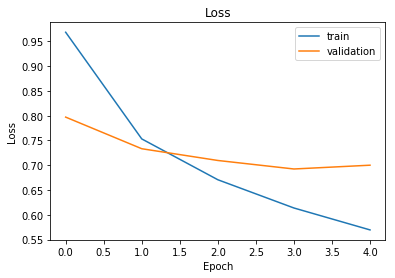

In [273]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

### Sentiment phrase detection ###

In [398]:
len_selected = train.selected_text.apply(lambda x: len(x.split()))

In [399]:
import statistics
print("Training set's selected text statistics:")
print("Min length: {:.2f} ".format(np.min(len_selected)))
print("Max length: {:.2f} ".format(np.max(len_selected)))
print("Mean length: {:.2f} ".format(np.mean(len_selected)))
print("Median length: {:.2f} ".format(np.median(len_selected)))
print("Mode length: {:.2f} ".format(statistics.mode(len_selected.values)))

Training set's selected text statistics:
Min length: 1.00 
Max length: 33.00 
Mean length: 7.10 
Median length: 4.00 
Mode length: 1.00 


**Method 1 - Phrase with largest probability of same prediction as overall text**

In [84]:
def find_sentiment_phrase(data, sentiment, selected_models, model_accuracies, label_encoder, CountVectorizer, baseline=None, max_phrase_len=10, preferred_len='Min'):
    
    #Empty array to store selected phrase from each file in data
    selected_phrases = []    
        
    for i, text in enumerate(data):

        #Empty arrays to store info about different subsets of the full text
        phrases = []
        phrases_lengths = []
        phrases_prob = []
        
        words_full = data[i].split() #split text into individual words
        sentiment_i = le.transform([sentiment[i]]) #encode sentiment label using the same encoding seen by the ensemble classifier
        
        #Create all possible combinations of successive words with length between 1 and max_phrase_len
        for j in range(len(words_full)):
            for k in range(j+1,min(max_phrase_len+j+1,len(words_full)+1)):
                phrase = [words_full[j],*words_full[j+1:k]]
                phrase_length = len(phrase)
                phrase = ' '.join(phrase)
        
            #Add phrase to list of all possible combinations and store its number of words
            phrases.append(phrase)
            phrases_lengths.append(phrase_length)
        
            #Convert phrase to bag of words
            phrase_bow = CountVectorizer.transform([phrase])
            phrase_bow_df = pd.DataFrame(phrase_bow.toarray(), columns = CountVectorizer.get_feature_names())
            
            #Run ensemble model on selected phrase only and store probabilites 
            _,_, phrase_probs = ensemble_model(phrase_bow_df, selected_models, model_accuracies, label_encoder, baseline=baseline)
            
            #Only keep probability of same sentiment as the sentiment of the entire text and append to list of probabilities for all phrases
            phrases_prob.append(phrase_probs[0][sentiment_i])
            
        #Find phrase with highest probability of being classified as the sentiment as the overall text.
        #In case of a tie, pick longest or shortest phrase (depending on input) and then phrase that is as in the middle of the text as possible.
        probs_rank = pd.DataFrame(phrases_prob,phrases).rename(columns={0:'probs'})
        probs_rank['length'] = phrases_lengths
        selected_phrase = probs_rank[probs_rank.probs==max(probs_rank.probs)]
        if preferred_len == 'Min':
            selected_phrase = selected_phrase[selected_phrase.length==min(selected_phrase.length)]
        else:
            selected_phrase = selected_phrase[selected_phrase.length==max(selected_phrase.length)]
        selected_phrase = selected_phrase.index.values[int(len(selected_phrase)/2)]
        
        selected_phrases.append(selected_phrase) #add to list of selected phrases
        
    output = pd.DataFrame(data)
    output['predicted_sentiment'] = sentiment
    output['selected_text'] = selected_phrases
    
    return output

In [85]:
predictions_test = find_sentiment_phrase(test_text_norm[:20], pred[:20], selected_models, model_accuracies, le, count_vector, baseline_model, max_phrase_len=10, preferred_len='Min')

In [86]:
predictions_test

text predicted_sentiment  \
0         Last session of the day httptwitpiccom67ezh             neutral   
1   Shanghai is also really exciting precisely sky...            positive   
2   recession hit Veronique Branquinho she has to ...            negative   
3                                          happy bday            positive   
4                       httptwitpiccom4w75p I like it             neutral   
5                           thats great weee visitors            positive   
6               I think EVERYONE hates ME ON HERE lol            negative   
7   soo wish i could but im in school and myspace ...            negative   
8   and within a short time of the last clue all o...             neutral   
9   What did you get My day is alright havent done...             neutral   
10  My bike was put on holdshould have known that ...            negative   
11                             I checked We didnt win             neutral   
12  and youre on twitter did the tavern bore you t...             neutral   
13  im in va for the weekend my youngest son turns...            negative   
14  Its coming out the socket I feel like my phone...            negative   
15  So hot today dont like it and i hate my new ti...            negative   
16                                           miss you            negative   
17                                             cramps            negative   
18  you guys didnt say hi or answer my questions y...            positive   
19  im going into a spiritual stagnentation its ex...             neutral   

                                        selected_text  
0                                 httptwitpiccom67ezh  
1   also really exciting precisely skyscrapers gal...  
2   recession hit Veronique Branquinho she has to ...  
3                                          happy bday  
4                                                  it  
5                           thats great weee visitors  
6                                hates ME ON HERE lol  
7      im in school and myspace is completely blocked  
8             short time of the last clue all of them  
9   alright havent done anything yet leaving soon ...  
10                       known that argh total bummer  
11                               checked We didnt win  
12                                               much  
13  youngest son turns 2 tomorrowit makes me kinda...  
14         hole is not a virgin thats how loose it is  
15      and i hate my new timetable having such a bad  
16                                           miss you  
17                                             cramps  
18                 questions yesterday but nice songs  
19  going into a spiritual stagnentation its explo...

In [83]:
predictions_test

text predicted_sentiment  \
0         Last session of the day httptwitpiccom67ezh             neutral   
1   Shanghai is also really exciting precisely sky...            positive   
2   recession hit Veronique Branquinho she has to ...            negative   
3                                          happy bday            positive   
4                       httptwitpiccom4w75p I like it             neutral   
5                           thats great weee visitors            positive   
6               I think EVERYONE hates ME ON HERE lol            negative   
7   soo wish i could but im in school and myspace ...            negative   
8   and within a short time of the last clue all o...             neutral   
9   What did you get My day is alright havent done...             neutral   
10  My bike was put on holdshould have known that ...            negative   
11                             I checked We didnt win             neutral   
12  and youre on twitter did the tavern bore you t...             neutral   
13  im in va for the weekend my youngest son turns...            negative   
14  Its coming out the socket I feel like my phone...            negative   
15  So hot today dont like it and i hate my new ti...            negative   
16                                           miss you            negative   
17                                             cramps            negative   
18  you guys didnt say hi or answer my questions y...            positive   
19  im going into a spiritual stagnentation its ex...             neutral   

                                        selected_text  
0                                 httptwitpiccom67ezh  
1   also really exciting precisely skyscrapers gal...  
2   recession hit Veronique Branquinho she has to ...  
3                                          happy bday  
4                                                  it  
5                           thats great weee visitors  
6                       EVERYONE hates ME ON HERE lol  
7   could but im in school and myspace is complete...  
8         within a short time of the last clue all of  
9   alright havent done anything yet leaving soon ...  
10  was put on holdshould have known that argh tot...  
11                             I checked We didnt win  
12                                      you that much  
13  youngest son turns 2 tomorrowit makes me kinda...  
14         hole is not a virgin thats how loose it is  
15      and i hate my new timetable having such a bad  
16                                           miss you  
17                                             cramps  
18              my questions yesterday but nice songs  
19  going into a spiritual stagnentation its explo...

In [426]:
test_predictions = find_sentiment_phrase(test_text_norm, pred, selected_models, model_accuracies, le, count_vector, baseline_model, max_phrase_len=10, preferred_len='Min')

In [428]:
test_predictions.to_csv('test_predictions.csv')

**Method 2 - Phrase which cause largest deterioration of prediction when left out of text**

In [161]:
words_full = test_text_norm[1].split()
sentiment_i = le.transform([test_pred[1]]) #encode sentiment label using the same encoding seen by the ensemble classifier

In [169]:
test_text_norm[1]

'Shanghai is also really exciting precisely skyscrapers galore good tweeps in china sh BJ'

In [162]:
words_full

['Shanghai',
 'is',
 'also',
 'really',
 'exciting',
 'precisely',
 'skyscrapers',
 'galore',
 'good',
 'tweeps',
 'in',
 'china',
 'sh',
 'BJ']

In [163]:
from operator import itemgetter 

#Empty arrays to store info about different subsets of the full text
phrases = []
phrases_lengths = []
phrases_prob = []

preferred_len = 'Min'

for j in range(len(words_full)):
        for k in range(j+1,min(10+j+1,len(words_full)+1)):
            phrase = [words_full[j],*words_full[j+1:k]]
            phrase_length = len(phrase)
            phrase_index = np.arange(j,k)
                       
            phrase = ' '.join(phrase)
            
            if phrase_length < len(words_full):
                remaining_indices = list(list(set(np.arange(0,len(words_full))) ^ set(phrase_index)))
                if len(remaining_indices) > 1:
                    remaining_phrase = list(itemgetter(*remaining_indices)(words_full))
                    remaining_phrase = ' '.join(remaining_phrase)
                else:
                    remaining_phrase = words_full[remaining_indices[0]]
                                
                #Add phrase to list of all possible combinations and store its number of words
                phrases.append(phrase)
                phrases_lengths.append(phrase_length)
                
                #Convert remaining phrase to bag of words
                remaining_phrase_bow = count_vector.transform([remaining_phrase])
                remaining_phrase_bow_df = pd.DataFrame(remaining_phrase_bow.toarray(), columns = count_vector.get_feature_names())
            
                #Run ensemble model on remaining phrase only and store probabilites 
                _,_, phrase_probs = ensemble_model(remaining_phrase_bow_df, selected_models, model_accuracies, le, baseline=baseline_model)
            
                #Only keep probability of same sentiment as the sentiment of the entire text and append to list of probabilities for all phrases
                phrases_prob.append(phrase_probs[0][sentiment_i])
                
            #Find phrase with lowest probability of being classified as the sentiment as the overall text.
            #In case of a tie, pick longest or shortest phrase (depending on input) and then phrase that is as in the middle of the text as possible.
            probs_rank = pd.DataFrame(phrases_prob,phrases).rename(columns={0:'probs'})
            probs_rank['length'] = phrases_lengths
            selected_phrase = probs_rank[probs_rank.probs==min(probs_rank.probs)]
            if preferred_len == 'Min':
                selected_phrase = selected_phrase[selected_phrase.length==min(selected_phrase.length)]
            else:
                selected_phrase = selected_phrase[selected_phrase.length==max(selected_phrase.length)]
            selected_phrase = selected_phrase.index.values[int(len(selected_phrase)/2)]
                

In [167]:
probs_rank.sort_values('probs',ascending=True)

probs  length
really exciting precisely skyscrapers galore go...  0.038062      10
exciting precisely skyscrapers galore good twee...  0.042072      10
exciting precisely skyscrapers galore good twee...  0.042072       9
really exciting precisely skyscrapers galore go...  0.515623       9
also really exciting precisely skyscrapers galo...  0.515623      10
exciting precisely skyscrapers galore good twee...  0.526438       8
is also really exciting precisely skyscrapers g...  0.553202      10
also really exciting precisely skyscrapers galo...  0.553202       8
also really exciting precisely skyscrapers galo...  0.553202       9
really exciting precisely skyscrapers galore go...  0.553202       7
is also really exciting precisely skyscrapers g...  0.553202       9
really exciting precisely skyscrapers galore go...  0.553202       8
Shanghai is also really exciting precisely skys...  0.553202      10
exciting precisely skyscrapers galore good tweeps   0.571867       6
exciting precisely skyscrapers galore good twee...  0.571867       7
really exciting precisely skyscrapers galore good   0.652707       6
is also really exciting precisely skyscrapers g...  0.652707       8
also really exciting precisely skyscrapers galo...  0.652707       7
Shanghai is also really exciting precisely skys...  0.652707       9
exciting precisely skyscrapers galore good          0.681488       5
precisely skyscrapers galore good tweeps in chi...  0.870622       8
precisely skyscrapers galore good tweeps in chi...  0.870622       9
precisely skyscrapers galore good tweeps in china   0.873146       7
precisely skyscrapers galore good tweeps in         0.909937       6
precisely skyscrapers galore good tweeps            0.909937       5
skyscrapers galore good tweeps in china             0.919233       6
galore good tweeps in china                         0.919233       5
galore good tweeps in china sh BJ                   0.924811       7
skyscrapers galore good tweeps in china sh          0.924811       7
skyscrapers galore good tweeps in china sh BJ       0.924811       8
...                                                      ...     ...
tweeps in china                                     0.991781       3
tweeps in china sh BJ                               0.994192       5
tweeps in china sh                                  0.994192       4
tweeps in                                           0.994910       2
tweeps                                              0.994910       1
precisely skyscrapers                               0.995188       2
precisely                                           0.995188       1
galore                                              0.995730       1
skyscrapers galore                                  0.995730       2
china                                               0.996267       1
in china                                            0.996267       2
is also really                                      0.996747       3
really                                              0.996747       1
Shanghai is also really                             0.996747       4
also really                                         0.996747       2
in china sh BJ                                      0.997400       4
china sh                                            0.997400       2
china sh BJ                                         0.997400       3
in china sh                                         0.997400       3
in                                                  0.997699       1
Shanghai                                            0.997699       1
also                                                0.997699       1
is also                                             0.997699       2
is                                                  0.997699       1
Shanghai is also                                    0.997699       3
Shanghai is                                         0.997699       2
skyscrapers                                         0